# ECG Heartbeat Classification: From Data to Diagnosis

## 1. Introduction

An **Electrocardiogram (ECG)** measures the heart’s electrical activity and is the main diagnostic tool for identifying arrhythmias. Manual ECG review is **time-consuming**, **subjective**, and **error-prone**.

This project builds an **automated, data-driven system** to distinguish normal from abnormal heartbeats. We evaluate a full spectrum of approaches — from classical machine learning to advanced deep learning — with the practical objective of maximizing **clinical safety** (minimizing missed dangerous beats) while keeping strong overall performance.


Each spike and wave in the ECG trace tells a story about how the heart beats:

* **P-wave:** This small bump shows the **atria (upper chambers)** contracting — it’s the start of a heartbeat.
* **PR interval:** The short pause before the next spike. It shows how long it takes the signal to travel from the **heart’s natural pacemaker (the SA node)** through the electrical pathways to the **ventricles**.
* **QRS complex:** The tall, sharp spike — this is when the **ventricles (main pumping chambers)** contract to push blood through the body.
* **ST segment:** A short flat line after the spike — it shows the **ventricles relaxing** before the next beat.
* **T-wave:** The final wave — it marks the **recharging (repolarization)** of the ventricles, preparing for the next beat.


In our project, these tiny segments and their shapes are what the model learns to interpret — just like a doctor does — to decide whether a heartbeat is **normal or abnormal**.

![](https://oxfordmedicaleducation.com/wp-content/uploads/2014/07/ECG-Fig-4-ECG-segments.jpg)

---

## 2. Goals and Key Questions

**Primary Objective:**
To deeply **understand ECG heartbeat patterns**, explore their **statistical and morphological differences**, and build models that can **reliably detect abnormal rhythms** while being interpretable and clinically relevant.

This project wasn’t just about running models — it was a full **data science investigation** aimed at uncovering how ECG signals behave, what features truly matter, and how we can transform those insights into practical diagnostic tools.

---

###  Questions We Set Out to Answer

1. **What’s hidden in the data?**

   * How do heartbeat signals differ across classes (N, S, V, F, Q)?
   * Are abnormal beats visually or statistically distinct, or are some “tricksters” that closely resemble normal ones?
   * What regions of the waveform (like P-wave, QRS complex, or T-wave) carry the most diagnostic information?

2. **What features matter most?**

   * Which time-domain, frequency-domain, and derivative-based features best capture the differences?
   * Do engineered statistical features (mean, skewness, kurtosis) or automatically learned patterns perform better?

3. **How to handle imbalance and noise?**

   * With so few dangerous beats (S, F), how can we train fair models that don’t ignore rare events?
   * Should we use resampling (like SMOTE) or class weighting?
   * How do outliers and noisy beats affect performance and interpretability?

4. **Can we visualize the heartbeat landscape?**

   * What happens when we use PCA, t-SNE, or clustering — do classes naturally group together?
   * What does the structure of the feature space tell us about the separability of heart conditions?

5. **How stable are the signals across patients and beats?**

   * Are some patterns patient-specific, or do they generalize?
   * What kind of variability (timing, amplitude, shape) is normal vs pathological?

6. **Which model families best capture the insights we found?**

   * How do traditional ML methods (like Random Forests) compare with Deep Learning approaches (CNNs, RNNs, Attention)?
   * Do these models confirm what our exploratory analysis suggested about the data?

7. **Which model should we trust and recommend?**

   * What’s the trade-off between overall balanced accuracy and clinical safety?
   * Which model would be safest to use in a hospital setting where false negatives can be deadly?

---

## 3. Dataset Summary

**MIT-BIH Arrhythmia Dataset (PhysioNet)**

* **Samples:** 109,446 beats
* **Classes (5):** N (Normal), S (Supraventricular), V (Ventricular), F (Fusion), Q (Unclassified)
* **Processed segment size:** 188 time steps at 125 Hz

**Approximate class counts & priority**

| Class | Approx. samples | Imbalance        | Clinical priority |
| ----: | --------------: | ---------------- | ----------------- |
|     N |         ~90,000 | Majority         | Low               |
|     S |          ~2,000 | Minority         | High              |
|     V |          ~7,000 | Minority         | High              |
|     F |            ~700 | Extreme minority | Highest           |
|     Q |         ~10,000 | Medium           | Medium            |

**Implication:** severe imbalance (especially F,S) — requires strategies to prioritize recall for rare, critical classes.

---

## 4. High-level Methodology

We follow a two-phase pipeline and use **Macro-F1** as our primary balanced metric:

**Phase 1 — Classical ML baseline**

* Feature engineering (time & frequency domain, derivatives, statistics).
* Models: Logistic Regression, Decision Tree, Random Forest, etc.
* Key experiments: SMOTE, PCA, outlier removal.

**Phase 2 — Deep learning & transfer**

* Architectures: 1D-CNN, GRU, Hybrid CNN–RNN, Attention-focused model.
* Transfer learning: HuggingFace ECG encoder → XGBoost.
* Imbalance handling: augmentation and class weights (final models use class weights).

Evaluation: all models tested on the same hold-out test split. Report Macro-F1, precision, recall; with focused analysis for classes **S** and **F**.




# Data Imports and Preparation

In [1]:
import subprocess
import sys
import os

with open(os.devnull, 'wb') as devnull:
    subprocess.check_call(
        [sys.executable, "-m", "pip", "install", "--upgrade", "imbalanced-learn"],
        stdout=devnull, stderr=devnull
    )

!pip install tf_keras_vis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.8 MB/s eta 0:00:00


In [2]:

# --- General ---
import os, time, random, itertools, warnings, copy
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from statsmodels.graphics.tsaplots import plot_acf

# --- Signal processing & statistics ---
from scipy.signal import find_peaks, welch
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis, zscore
from scipy.ndimage import zoom
import statsmodels.api as sm
from collections import Counter

# --- Preprocessing & feature selection ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from boruta import BorutaPy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.calibration import calibration_curve

# --- Transformers / Torch ---
from transformers import AutoModel, AutoConfig
import torch
from tensorflow.keras.optimizers import Adam

# --- Model selection & evaluation ---
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    RandomizedSearchCV, StratifiedKFold
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.exceptions import FitFailedWarning
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score,
    make_scorer, precision_recall_fscore_support,
    silhouette_score, calinski_harabasz_score
)
from sklearn.cluster import KMeans

# --- Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- Pipelines & utilities ---
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import Bunch, check_random_state
from sklearn.inspection import permutation_importance

# --- Deep Learning (TF/Keras) ---
import tensorflow as tf
from tensorflow.keras import Model, Sequential, backend as K
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, MaxPooling1D,
    GlobalAveragePooling1D, Dense, Multiply, Add,
    GRU, Dropout, Flatten , Bidirectional, Lambda,ZeroPadding1D,
    SeparableConv1D, Activation, Layer,Concatenate

)
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

# --- Explainable AI ---
import shap
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore



import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_stderrthreshold('error')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'       
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'      
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir='  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'       

# --- Settings ---
sns.set(style="whitegrid", context="talk")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")

# --- Constants ---
LABEL_COL = 187    
N_SAMPLES = 188    
FS = 125          
CLASS_MAP = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
N_CLASSES = len(CLASS_MAP)
CLASS_NAMES = list(CLASS_MAP.values())
BATCH_SIZE = 64
MINORITY_THRESHOLD = 0.1
AUG_FACTOR = 3
EPOCHS = 66

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



# --- Dataset paths ---
mitbih_train_path = "/kaggle/input/heartbeat/mitbih_train.csv"
mitbih_test_path  = "/kaggle/input/heartbeat/mitbih_test.csv"


2025-10-19 12:12:16.214226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760875936.408845      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760875936.463413      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis (EDA)

Our analysis begins with exploring the dataset to understand its structure, quality, and the inherent characteristics of the different heartbeat classes. This exploration is essential for making informed decisions about data preparation and model selection.

## Data Cleaning and Integrity Verification

In [3]:
#Load data
mitbih_train_df = pd.read_csv(mitbih_train_path,header=None)
mitbih_test_df = pd.read_csv(mitbih_test_path, header=None)


# Unify the MIT-BIH datasets
mitbih_df = pd.concat([mitbih_train_df, mitbih_test_df], axis=0)
mitbih_df.columns = range(mitbih_df.shape[1])
mitbih_df = mitbih_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)


print("--- Unified MIT-BIH Dataset ---")
print("Shape:", mitbih_df.shape)



--- Unified MIT-BIH Dataset ---
Shape: (109446, 188)


We performed a quick **sanity check** on the initial DataFrame, examining its shape, completeness, and label counts. This step is a proactive measure to catch immediate issues—such as missing columns, incorrect labels, or out-of-range values—to ensure a reliable foundation for subsequent analysis.

=== Quick Sanity Check ===

Shape: (109446, 188)

Data types (first few columns):
0    float64
1    float64
2    float64
3    float64
4    float64
dtype: object

First few rows:
        0         1         2         3         4         5         6    \
0  1.000000  0.906250  0.603516  0.283203  0.080078  0.056641  0.050781   
1  1.000000  0.834677  0.524194  0.169355  0.000000  0.129032  0.221774   
2  1.000000  0.539715  0.197556  0.193483  0.101833  0.000000  0.032587   
3  0.892632  0.907368  0.505263  0.092632  0.040000  0.080000  0.088421   
4  0.978155  0.907767  0.694175  0.247573  0.106796  0.152913  0.101942   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.056641  0.048828  0.052734  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.282258  0.290323  0.302419  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.138493  0.242363  0.283096  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.088421  0.073684  0.069474  ...  0.0  0.0  0.0

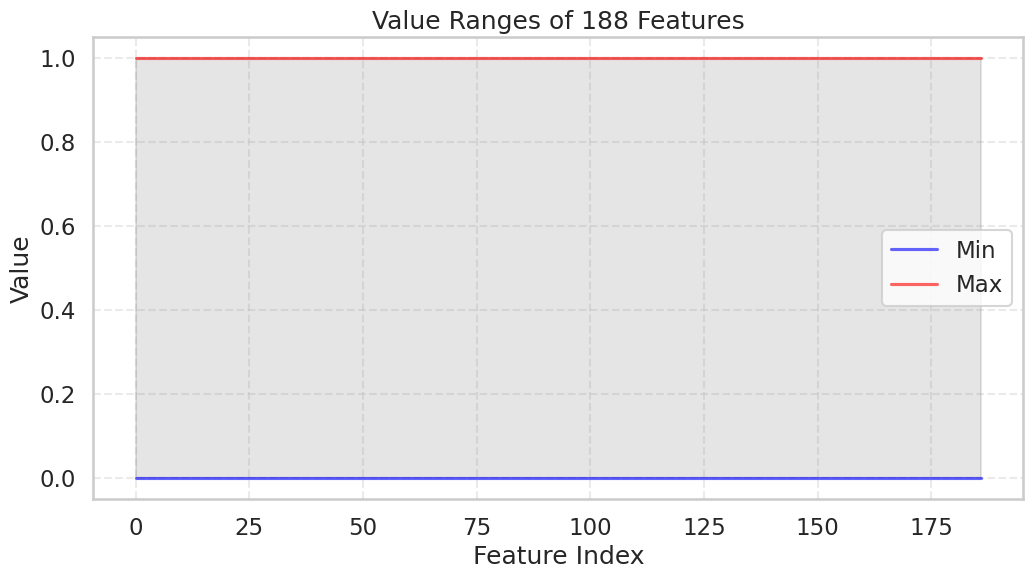


Sanity check complete 


In [4]:


print("=== Quick Sanity Check ===\n")

# --- Basic info ---
print(f"Shape: {mitbih_df.shape}")
print("\nData types (first few columns):")
print(mitbih_df.dtypes.head())
print("\nFirst few rows:")
print(mitbih_df.head(), "\n")

# --- Missing values ---
print("--- Missing Values Check ---")
missing_counts = mitbih_df.isna().sum()
print("Total missing values in dataset:", missing_counts.sum())
if missing_counts.sum() == 0:
    print(" No missing values detected.\n")
else:
    print(" Missing values found! Review columns:\n", missing_counts[missing_counts > 0], "\n")

# --- Feature value ranges  ---
min_vals = mitbih_df.iloc[:, :-1].min()
max_vals = mitbih_df.iloc[:, :-1].max()

plt.figure(figsize=(12, 6))
plt.plot(range(len(min_vals)), min_vals, label='Min', color='blue', alpha=0.6)
plt.plot(range(len(max_vals)), max_vals, label='Max', color='red', alpha=0.6)
plt.fill_between(range(len(min_vals)), min_vals, max_vals, color='gray', alpha=0.2)
plt.title('Value Ranges of 188 Features')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("\nSanity check complete ")


The initial dataset check confirmed a clean structure, resulting in a DataFrame of **109,446 rows** and **188 columns** (187 time-series features plus the target label).

## Visualization and Preliminary Insights

Before developing any models, it is crucial to visualize the raw signals. Analyzing the typical waveform shape for each class helps us understand the distinct visual differences that the models must learn to detect.

In [5]:

X = mitbih_df.iloc[:, :-1].values
y = mitbih_df[LABEL_COL].values


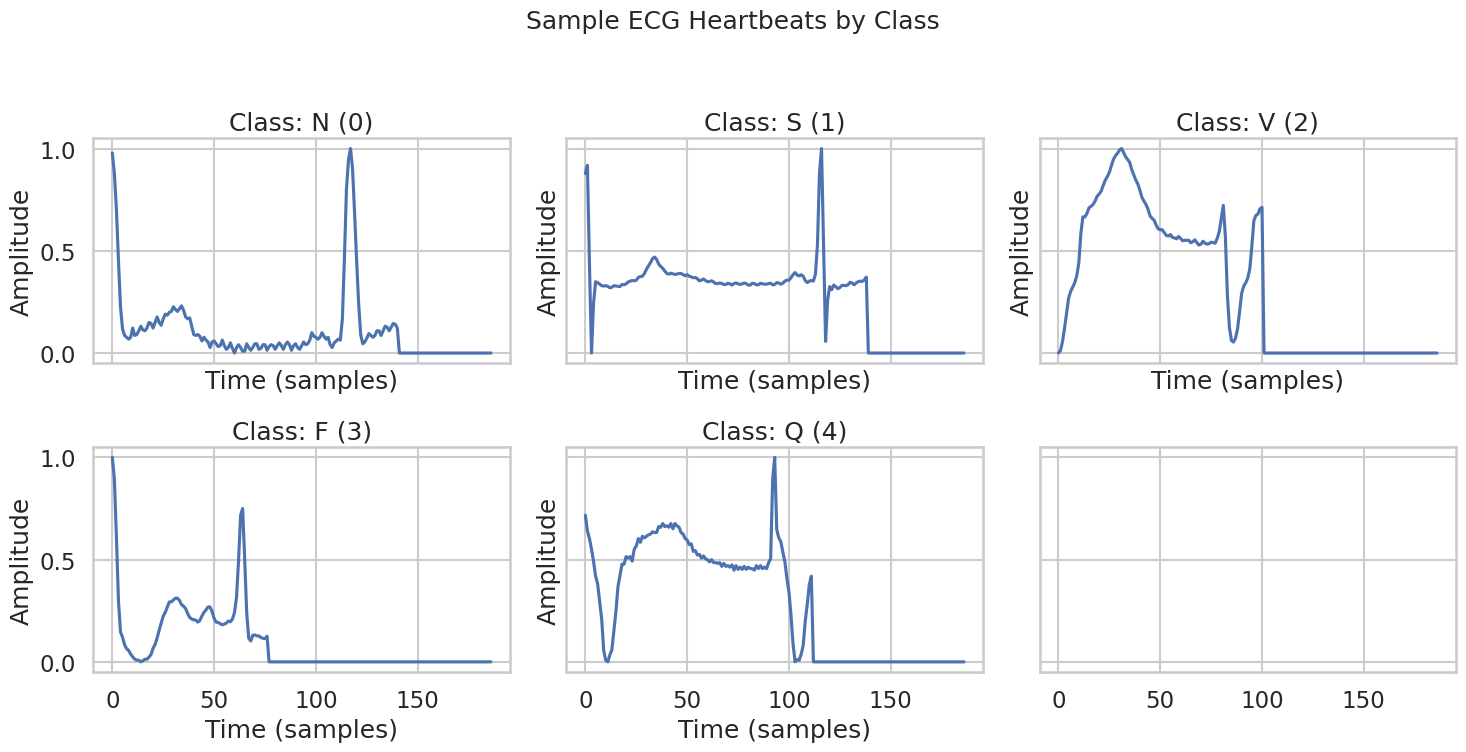

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()
labels = mitbih_df[LABEL_COL].unique()
labels.sort()

for i, label in enumerate(labels):
    if i >= len(axes):
        break
    sample_signals = mitbih_df[mitbih_df[LABEL_COL] == label].sample(n=1, random_state=RANDOM_SEED).iloc[0, :-1]
    axes[i].plot(sample_signals)
    axes[i].set_title(f'Class: {CLASS_MAP[label]} ({int(label)})')
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

fig.suptitle('Sample ECG Heartbeats by Class', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visual inspection of the raw signals revealed distinct morphological characteristics between classes: **Class V (Ventricular)** beats typically exhibit a much wider and larger QRS complex compared to **Normal (N)** beats. Similarly, **Class S (Supraventricular)** beats often lack a distinct P wave. These visual cues confirm that the shape of the heartbeat signal is a key determinant for classification.

## Class Distribution
To quantify the challenge of classification, we plotted the distribution of class counts. If one class is highly dominant, a model could achieve high overall accuracy by simply predicting the majority class. 

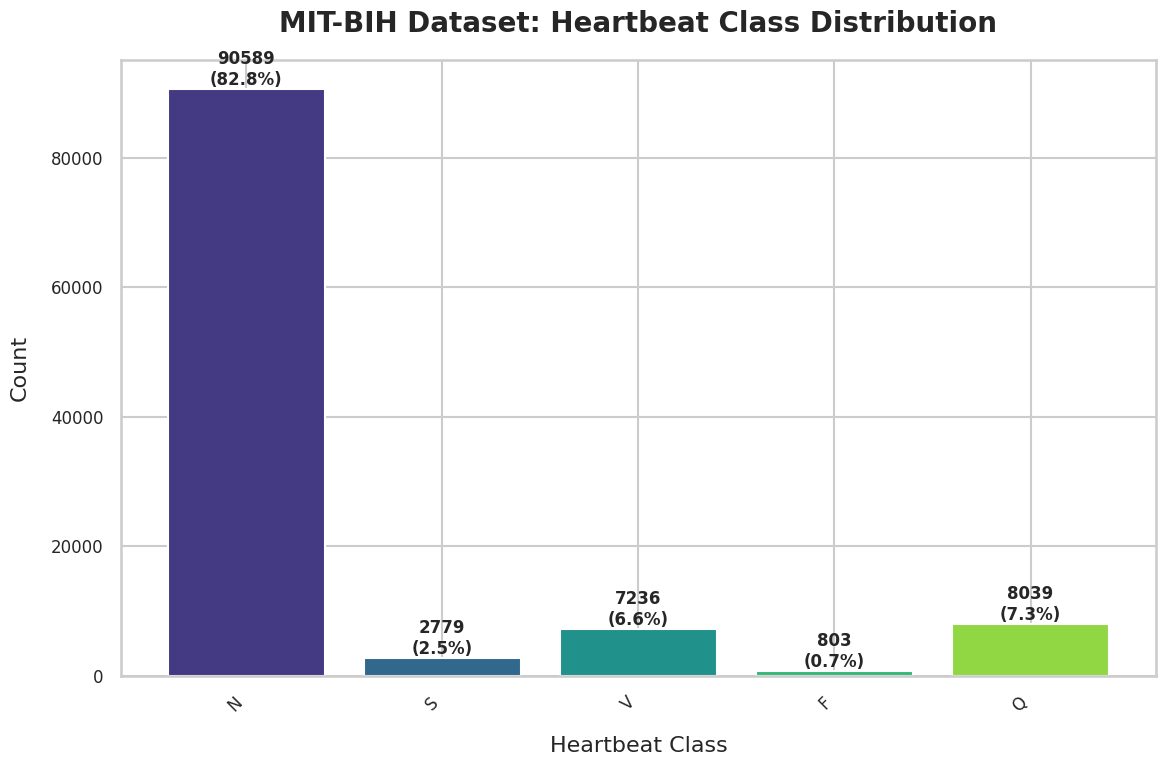

In [7]:
# Class distribution 
class_counts = mitbih_df[LABEL_COL].value_counts().sort_index()
total_samples = len(mitbih_df)
plt.figure(figsize=(12, 8))
bars = plt.bar(class_counts.index, class_counts.values, color=sns.color_palette("viridis", len(class_counts)))
plt.title('MIT-BIH Dataset: Heartbeat Class Distribution', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Heartbeat Class', fontsize=16, labelpad=15)
plt.ylabel('Count', fontsize=16, labelpad=15)
plt.xticks(ticks=class_counts.index, labels=[CLASS_MAP[i] for i in class_counts.index], rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_samples) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


The class count plot confirmed a **severe class imbalance**: the **Normal (N)** class heavily dominates the dataset, while the other four classes are significantly rarer.

Despite the data being a time series, calculating the correlation between adjacent time points provides insight into the signal's redundancy. A high correlation suggests that the value at a given point is strongly predicted by its immediate neighbors, which indicates that dimensionality reduction techniques like PCA *could* be effective at compressing the signal.

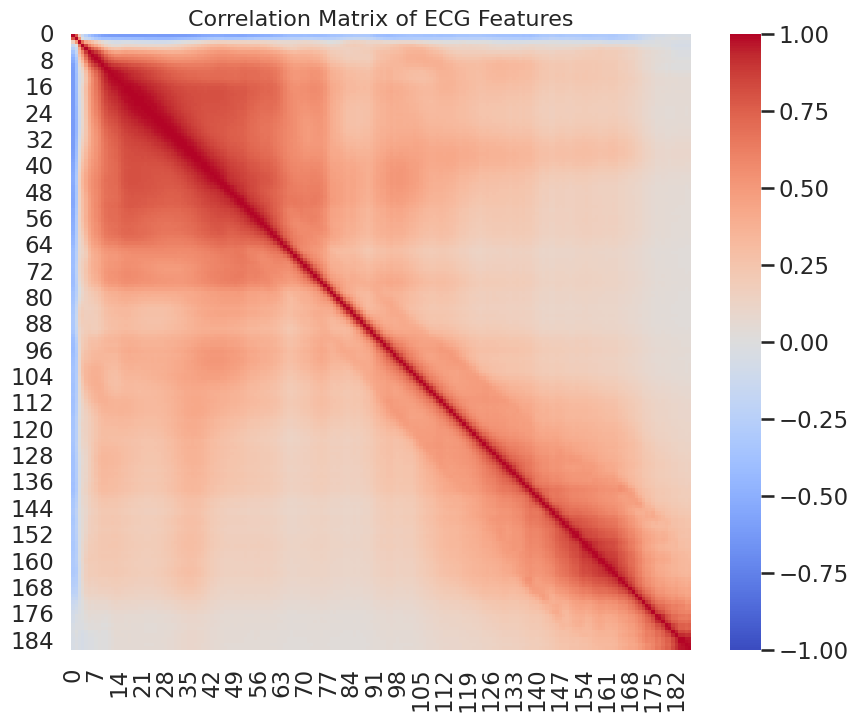

In [8]:
# Correlation matrix for a sample subset
sample_df = mitbih_df.sample(n=5000, random_state=RANDOM_SEED)
corr_matrix = sample_df.iloc[:, :-1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of ECG Features', fontsize=16)
plt.show()

The analysis of correlations confirmed a **high positive correlation** between adjacent time points. This high redundancy aligns with the nature of a smooth ECG signal, where local values are highly dependent. 

To identify the most informative regions of the heartbeat, we generated box plots for a few representative time points (e.g., 20, 80, 120, 160).

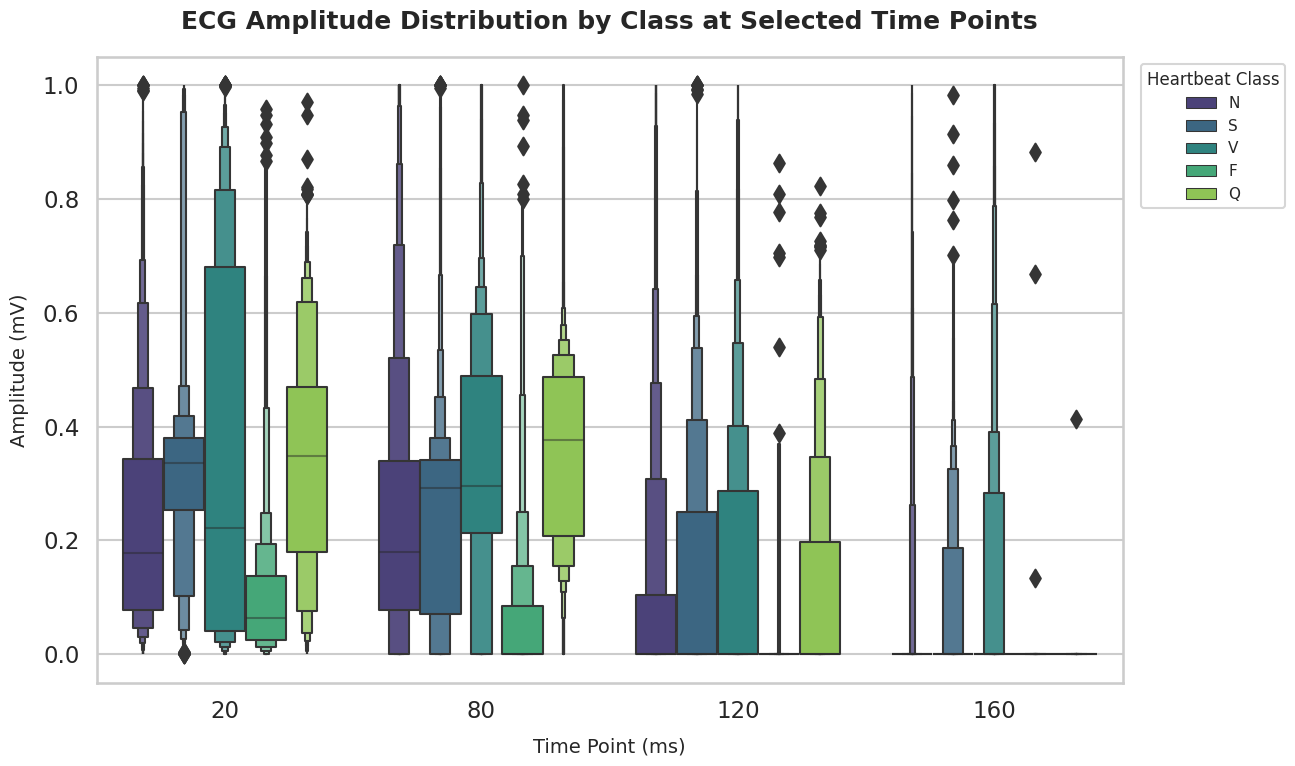

In [9]:
# Melted boxen plot for selected time points
time_points = [20, 80, 120, 160]
df_melted = mitbih_df.melt(id_vars=LABEL_COL, value_vars=time_points, var_name='Time Point', value_name='Amplitude')
plt.figure(figsize=(14, 8))
sns.boxenplot(data=df_melted, x='Time Point', y='Amplitude', hue=LABEL_COL, palette='viridis', dodge=True, linewidth=1.5)
plt.title('ECG Amplitude Distribution by Class at Selected Time Points', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time Point (ms)', fontsize=14, labelpad=10)
plt.ylabel('Amplitude (mV)', fontsize=14, labelpad=10)
handles, labels_ = plt.gca().get_legend_handles_labels()
plt.legend(handles, [f'{CLASS_MAP[int(float(label))]}' for label in labels_], title='Heartbeat Class', fontsize=11, title_fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

#### 1. **20 ms – Start of QRS**

* **Low amplitudes:** N, S (mostly <0.4 mV)
* **High amplitudes:** V, Q (higher, more spread)
* **Interpretation:** This point captures the| initial QRS activity and clearly separates normal beats (N, S) from arrhythmic ones (V, Q). It's already quite informative for classification.

#### 2. **80 ms – QRS Peak**

* **N, S:** low and concentrated
* **V, Q:** high and widely spread
* **Interpretation:** Maximum separation between normal and abnormal beats. The signal amplitude here alone can serve as a strong feature for classification.

#### 3. **120 ms – Start of Repolarization**

* Most classes converge near zero.
* **Exceptions:** V and S stay elevated with noticeable spread.
* **Interpretation:** Highlights differences in V and S beats during the early recovery phase. Useful to detect these specific arrhythmias.

#### 4. **160 ms – End of Beat**

* Distributions for all classes converge to baseline; heavy overlap.
* **Interpretation:** Minimal discriminative value; mostly indicates the beat has returned to baseline, so features from here contribute little.

**Summary:**
The most informative points are **20 ms** (early QRS) and **80 ms** (QRS peak). These points capture the largest differences between normal (N, S) and arrhythmic (V, Q) beats, making them critical for feature extraction and model accuracy.



## Outlier Detection Using Z-Score

Z-Score analysis is a statistical approach used to identify **extreme or unusual signals** within a dataset. The Z-score measures how far a given observation deviates from the mean of its distribution, helping detect signals that behave very differently from the rest.

Because our dataset is **highly imbalanced** (with a strong dominance of the normal class “N”), a standard global Z-score would be biased toward this majority class.
To address this, we applied an **Intra-Class Z-Score** method:

* **Per-class normalization:** The Z-score is computed **separately for each class**, so each heartbeat is compared only against beats of the same type.
* **Focused outlier detection:** This approach highlights genuinely unusual beats within their own rhythm category, avoiding distortion by the dominant class.
* **Strict threshold for rarity:** We defined a beat with **Z-score > 9** as an extreme outlier. This intentionally high cutoff ensures that only signals that are truly exceptional—beyond natural ECG variability—are flagged. In ECG data, significant shape variations can still represent normal physiological differences, so this conservative threshold helps capture only the most atypical or suspicious patterns.


Found 285 potential outlier signals (Z-score > 9).

--- Outlier Summary by Class ---
N: 235 outliers
S: 35 outliers
F: 10 outliers
Q: 5 outliers

The class with the most outliers is: N (235 signals).


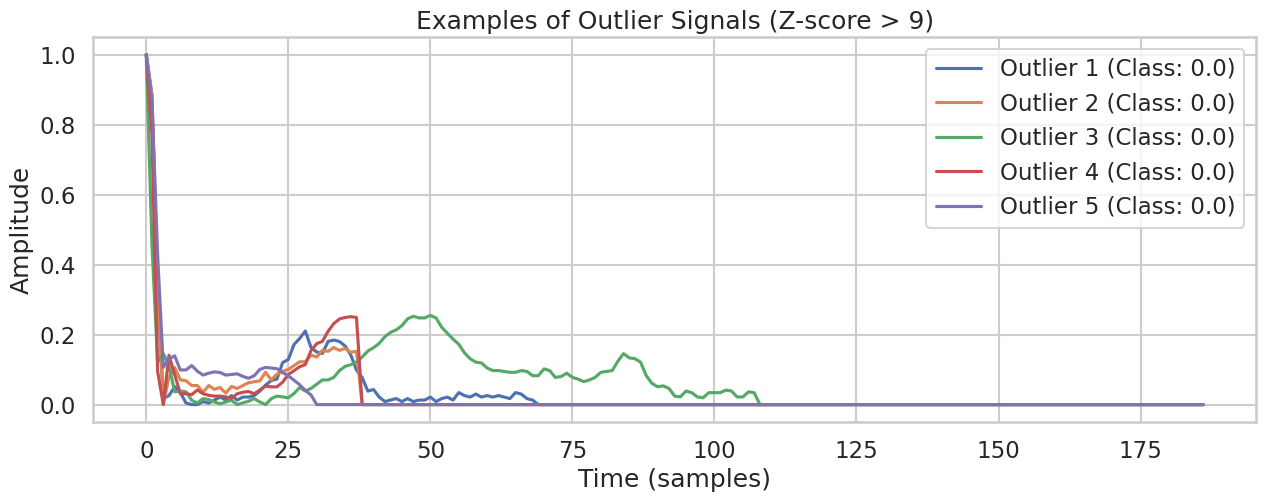

In [10]:

def detect_outliers_with_positions(X, y, class_map=None, z_thresh=9):
    z_scores = np.abs(zscore(X, axis=1))
    outlier_indices = np.where(np.max(z_scores, axis=1) > z_thresh)[0]
    outlier_signals = X[outlier_indices]
    outlier_labels = y[outlier_indices]
    
    if len(outlier_signals) > 0:
        print(f"Found {len(outlier_signals)} potential outlier signals (Z-score > {z_thresh}).")
        
        outlier_counts = Counter(outlier_labels)
        most_outlier_class, count = outlier_counts.most_common(1)[0]

        print("\n--- Outlier Summary by Class ---")
        for label, num in outlier_counts.most_common():
            class_name = class_map.get(label, f'Class {label}') if class_map else f'Class {label}'
            print(f"{class_name}: {num} outliers")
        
        class_name_most = class_map.get(most_outlier_class, f'Class {most_outlier_class}') if class_map else f'Class {most_outlier_class}'
        print(f"\nThe class with the most outliers is: {class_name_most} ({count} signals).")

        
        plt.figure(figsize=(15, 5))
        for i in range(min(5, len(outlier_signals))):
            label_text = f'Outlier {i+1} (Class: {outlier_labels[i]})'
            plt.plot(outlier_signals[i], label=label_text)
        plt.title(f'Examples of Outlier Signals (Z-score > {z_thresh})')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
    else:
        print(f"No significant outliers found with a Z-score threshold of {z_thresh}.")

    df_outliers = pd.DataFrame(outlier_signals)
    df_outliers["label"] = outlier_labels
    df_outliers["index"] = outlier_indices
    df_outliers.reset_index(drop=True, inplace=True)

    return df_outliers


df_outliers = detect_outliers_with_positions(X, y, class_map=CLASS_MAP, z_thresh=9)



## Z-Score Outlier Analysis (Threshold > 9)

We applied a **Z-score threshold of 9** to detect extreme outlier beats in the ECG dataset. This identifies signals that deviate strongly from the typical class patterns, but in biological data, extreme values **do not automatically indicate errors or noise**.

### Results

* **Total outliers detected:** 285 signals
* **Outliers by class:**

  * **N (Normal):** 235
  * **S (Supraventricular):** 35
  * **F (Fusion/Fibrillation):** 10
  * **Q (Unclassified):** 5

> **Observation:** The majority of outliers belong to the **Normal (N)** class.

### Key Insights

1. **Extreme deviation does not equal error:**
   High Z-scores highlight unusual beats, but these could represent **rare physiological variations**, not necessarily noise or recording mistakes. Human heartbeats are naturally **non-linear and diverse**, so some "extreme" beats may still be valid.

2. **Structural anomalies and technical artifacts:**
   Visual inspection shows some signals with **early amplitude decay, flattened sections, or irregular QRS shapes**, suggesting possible segmentation issues or electrode artifacts.

3. **Biological complexity:**
   Even within the same class, heartbeats can vary widely due to natural physiological differences. This makes distinguishing “true noise” from **rare but valid beats** challenging.

### Practical Decision

Instead of removing these extreme beats outright, we **retain them in the dataset**.
*Reasoning:* They might influence model learning and help the model **generalize to rare but real variations**. In biological datasets, extreme values can be informative, reflecting the **hardness and non-linear nature** of the data rather than simple measurement error.



## In-Depth Analysis from Four Analytical Perspectives

To gain a detailed understanding of the distinctions between the five heartbeat classes, we examined the data from four perspectives:

1.  **Mean ECG Signal per Class:** Illustrates the "typical" or average waveform shape for the N, S, V, F, and Q heartbeat types.

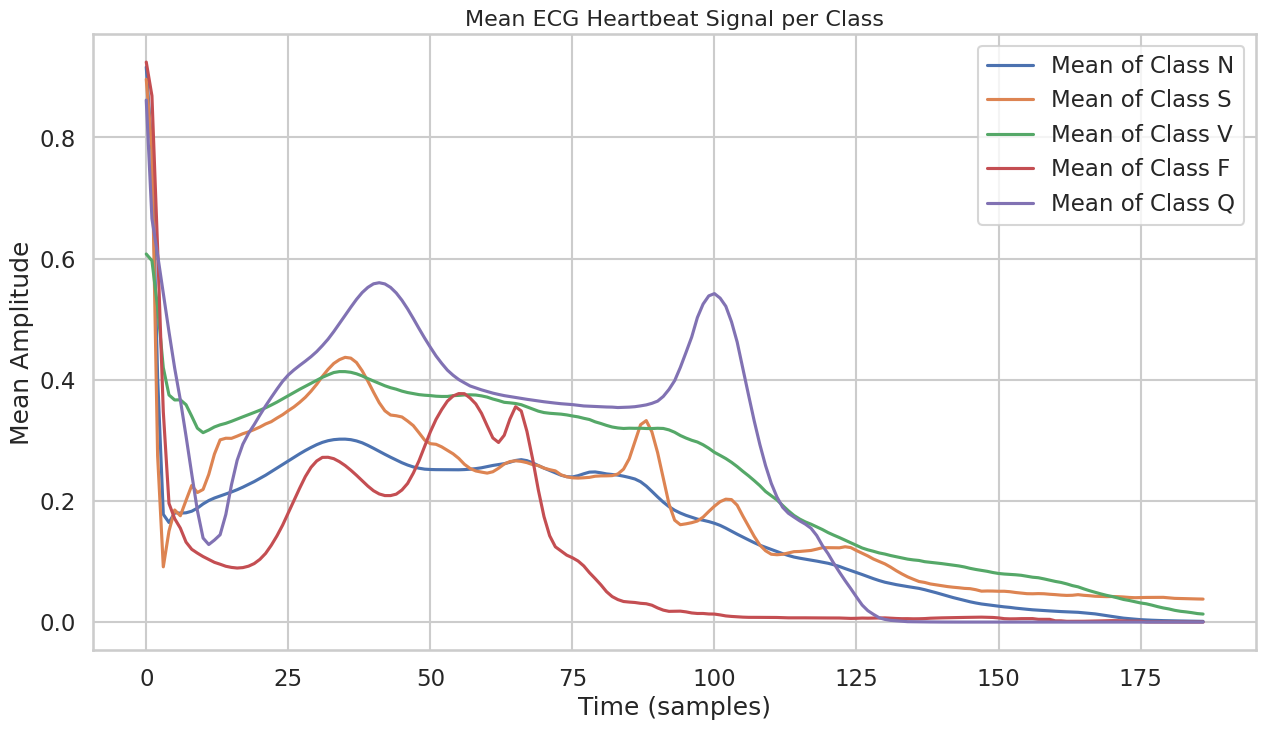

In [11]:
# Mean heartbeat per class
plt.figure(figsize=(15, 8))
for class_id, class_name in CLASS_MAP.items():
    class_signals = mitbih_df[mitbih_df[LABEL_COL] == class_id].drop(LABEL_COL, axis=1)
    mean_signal = class_signals.mean(axis=0)
    plt.plot(mean_signal, label=f'Mean of Class {class_name}')
plt.title('Mean ECG Heartbeat Signal per Class', fontsize=16)
plt.xlabel('Time (samples)')
plt.ylabel('Mean Amplitude')
plt.legend()
plt.show()

### Average Waveform Class Analysis

**Class N (Normal – Blue):**
Represents the standard and most balanced ECG shape, with a moderate QRS peak and a small T wave near the end of the beat. This class serves as the baseline for comparison.

**Class Q (Unclassified – Purple):**
Shows the **sharpest and highest QRS peak** (around 40–50 ms), suggesting strong electrical activity or an unusual conduction pathway. It also has a noticeable **T wave** around 100 ms.

**Class V (Ventricular – Green):**
Displays a **broader and less defined waveform** compared to *N* and *S*. The signal stays elevated across the beat with a lower, wider peak. This reflects the clinical pattern of **ventricular abnormalities**, where beats are wider and more distorted.

**Class S (Supraventricular – Orange):**
Looks similar to *N* but has **more variability** along the waveform, especially with a sharp downward trend following the QRS complex.

**Class F (Fusion/Fibrillation – Red):**
Shows a relatively low and vague QRS waveform. The critical finding is a dramatic drop to zero around 75 ms. This sharp drop indicates a disturbance that loses its amplitude in the repolarization phase (T wave), making the T wave region the most informative point for identifying F
.


This plot visually explains the amplitude differences seen in the previous **Box Plot Analysis**:

* **Why are Q and V higher at 80 ms?**
  Because in this average waveform, the **purple (Q)** and **green (V)** curves rise above *N* and *S* in the central region of the beat (roughly 40–80 ms).

* **Where is the best separation?**
  The **25–75 ms window** shows the greatest amplitude differences between classes — the key period for distinguishing between normal and abnormal heartbeats.

---


2.  **Autocorrelation Function (ACF) per Class:** Measures the temporal dependency—how much a signal correlates with a time-shifted version of itself. Classes with strong rhythm (like N) exhibit slow ACF decay, while erratic classes (like V) decay quickly.

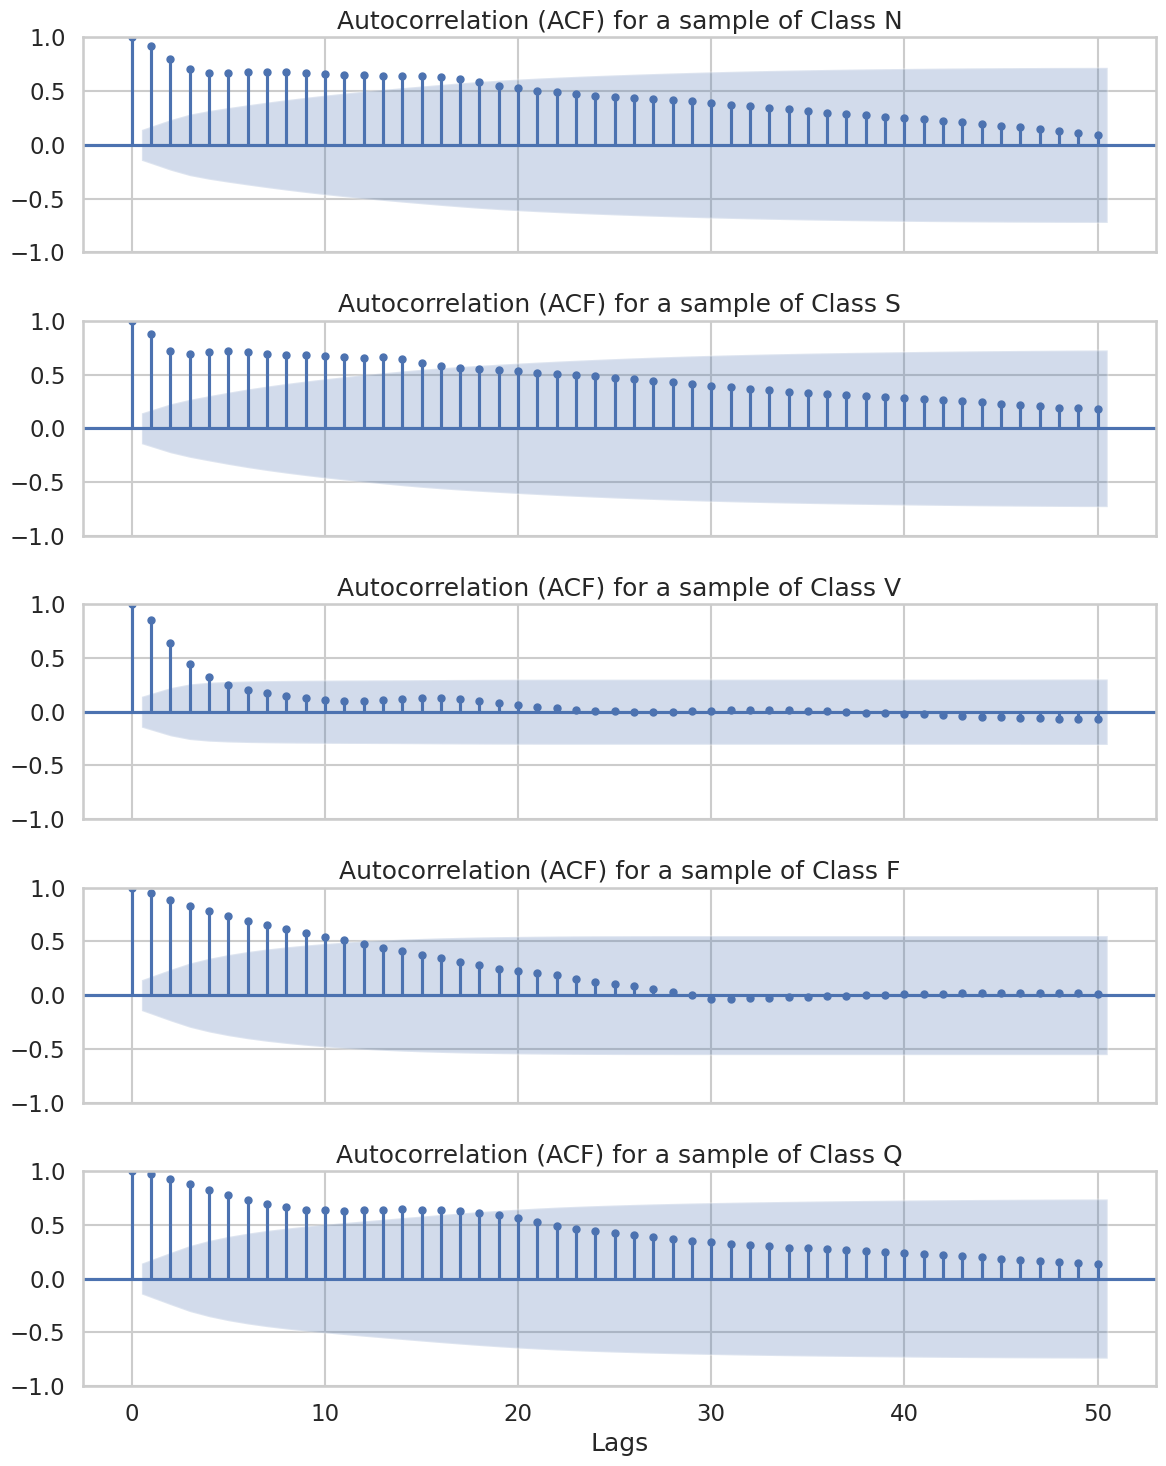

In [12]:
# ACF for a sample from each category
fig, axes = plt.subplots(len(CLASS_MAP), 1, figsize=(12, 15), sharex=True)
for i, (class_id, class_name) in enumerate(CLASS_MAP.items()):
    sample_signal = mitbih_df[mitbih_df[LABEL_COL] == class_id].iloc[0, :-1]
    plot_acf(sample_signal, lags=50, ax=axes[i], title=f'Autocorrelation (ACF) for a sample of Class {class_name}')
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

| Class | Decay Pattern | Clinical Meaning |
|-------|---------------|-----------------|
| N (Normal) | Decays slowly | Indicates a stable and regular heartbeat. The signal repeats consistently and remains self-correlated even after large shifts. |
| S (Supraventricular) | Decays faster than N | The signal is fairly regular but less stable than N, reflecting the nature of a supraventricular arrhythmia. |
| V (Ventricular) | Decays very quickly | The signal becomes chaotic rapidly. This reflects the broad and distorted shape of a ventricular beat due to abnormal conduction pathways. |
| F (Fusion) | Fastest and most dramatic decay | Indicates maximum chaos within the beat. The correlation breaks almost immediately, consistent with a beat that is a fusion of multiple sources. |
| Q (Unclassified) | Moderate decay | Shows intermediate regularity between N and F. |


ECG beats from different classes exhibit characteristic decay patterns over time. Analyzing how quickly the signal loses correlation provides insights into the **stability and regularity** of each heartbeat type. Normal beats (N) decay slowly, reflecting regular rhythm, while abnormal or fusion beats (F, V) decay rapidly, indicating irregular or chaotic electrical activity. Intermediate patterns (S, Q) show moderate decay, representing partial deviations from normal conduction. Understanding these patterns helps in **feature extraction for machine learning models** and clinical interpretation of arrhythmias.



3.  **Fourier Spectrum (Frequency Analysis):** Utilizes the Fast Fourier Transform (FFT) on the average signal to reveal which frequency components dominate each heartbeat type, quantifying waveform complexity.

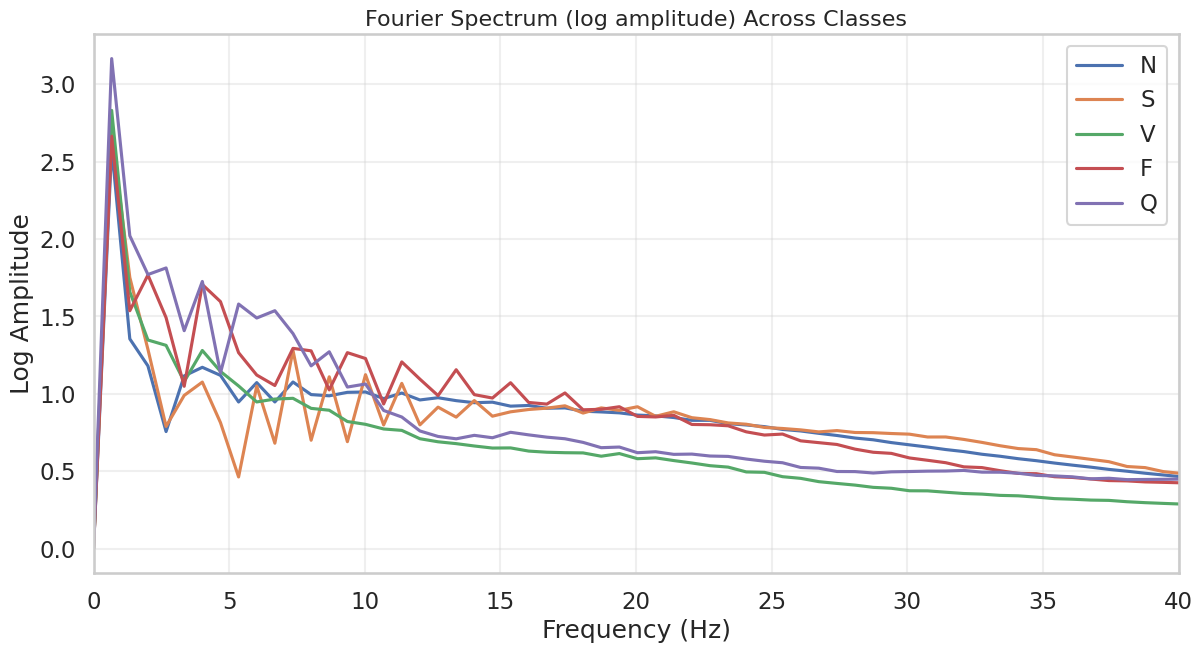

In [13]:
# Fourier Spectrum (FFT) per Class
plt.figure(figsize=(14, 7))
for class_id, class_name in CLASS_MAP.items():
    class_signals = mitbih_df[mitbih_df[LABEL_COL] == class_id].drop(LABEL_COL, axis=1)
    mean_signal = class_signals.mean(axis=0)
    fft_vals = rfft(mean_signal)
    fft_vals[0] = 0
    fft_freqs = rfftfreq(len(mean_signal), 1 / FS)
    plt.plot(fft_freqs, np.log1p(np.abs(fft_vals)), label=f"{class_name}")
plt.xlim(0, 40)
plt.title("Fourier Spectrum (log amplitude) Across Classes", fontsize=16)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log Amplitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


1. **Strongest Separation: Class F (Fusion - Red)**
   * **Finding:** Class F maintains the **highest energy in the high-frequency range (>10 Hz)**.
   * **Interpretation:** This confirms what we saw in previous analyses:
     - **Waveform shape:** F beats are the most chaotic and distorted.
     - **Autocorrelation:** The F signal decays fastest (maximum chaos).
     - **FFT:** High-frequency components are needed to reconstruct this complex shape, hence the elevated high-frequency energy.

2. **Wide vs. Sharp Beats: V & Q vs. N & S**
   * **Finding:** Classes V (Ventricular - Green) and Q (Unknown - Purple) have **lowest energy in high frequencies (>10 Hz)**.
   * **Interpretation:** V and Q beats are **broader and smoother**, dominated by low-frequency components.
   * **Contrast:** N (Normal - Blue) and S (Supraventricular - Orange) retain **higher high-frequency energy**, reflecting sharper features.  
     This allows to **distinguish atrial-origin beats (N, S) from ventricular or unclassified beats (V, Q)**.

 The FFT analysis effectively separates classes based on signal complexity and sharpness. Including **frequency-domain features** in ML models can help improve classification, especially for identifying chaotic F beats and distinguishing broad vs. sharp waveforms.


4.  **Derivatives (Rate of Change and Acceleration):** The first derivative shows the slope (rate of change), and the second derivative shows the curvature (acceleration). These highlight how sharply the signal changes, capturing dynamic differences between classes.


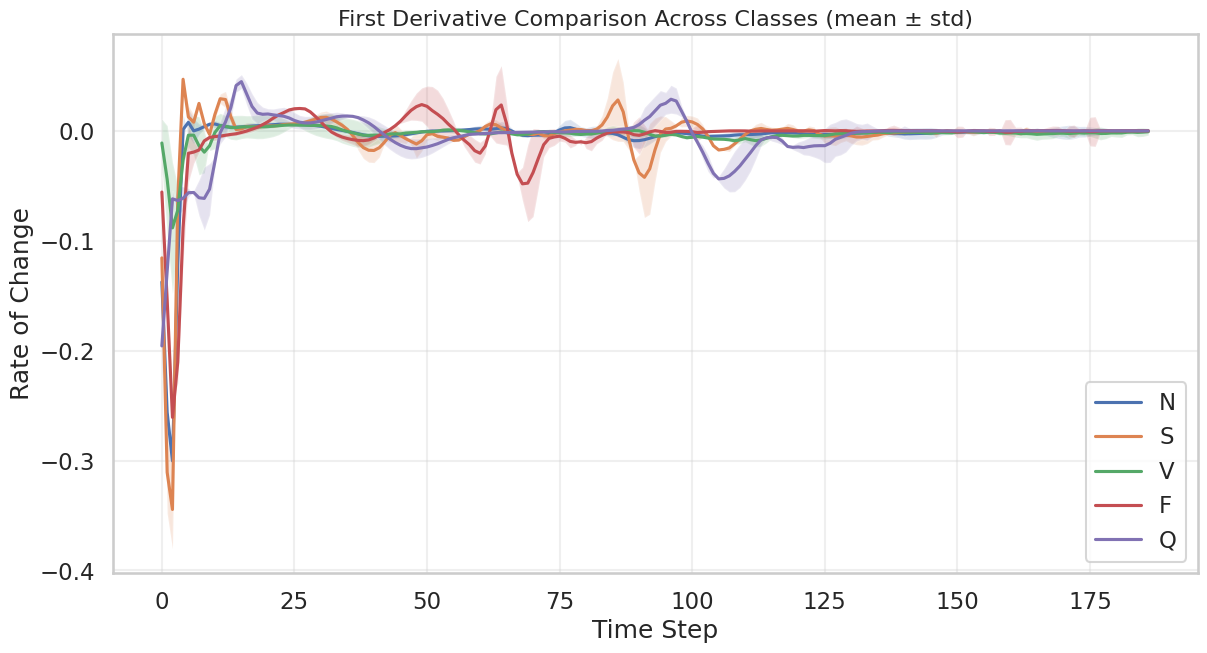

In [14]:
# First & Second Derivatives per Class (mean ± std)
plt.figure(figsize=(14, 7))
for class_id, class_name in CLASS_MAP.items():
    class_signals = mitbih_df[mitbih_df[LABEL_COL] == class_id].drop(LABEL_COL, axis=1)
    mean_signal = class_signals.mean(axis=0)
    std_signal = class_signals.std(axis=0)
    first_derivative = np.gradient(mean_signal)
    std_derivative = np.gradient(std_signal)
    plt.plot(first_derivative, label=f"{class_name}")
    plt.fill_between(range(len(first_derivative)), first_derivative - std_derivative, first_derivative + std_derivative, alpha=0.2)
plt.title("First Derivative Comparison Across Classes (mean ± std)", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Rate of Change")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### 1. First Derivative
The first derivative measures the **rate of change** (slope) at each point. Sharp peaks indicate sudden rises or drops.

* **R Wave Check (Start of Beat):**
  - Classes **N, S, F, Q** all show sharp negative peaks around **Time Step 0–25**.  
  - The strongest negative peaks (~−0.35) occur in **N and S**, indicating **steep Q-wave drops** in the QRS segment.
  - **V (Ventricular - Green)** shows a less sharp negative peak, consistent with **broader ventricular beats**.

* **Post-R Wave Variability:**
  - Classes **S (Orange)** and **F (Red)** show significant fluctuations after the R wave (Time Step 50–100), evident from wide confidence intervals.
  - **Interpretation:** Confirms the **chaotic behavior** of F and S beats seen in FFT and autocorrelation — their slopes vary significantly between beats.


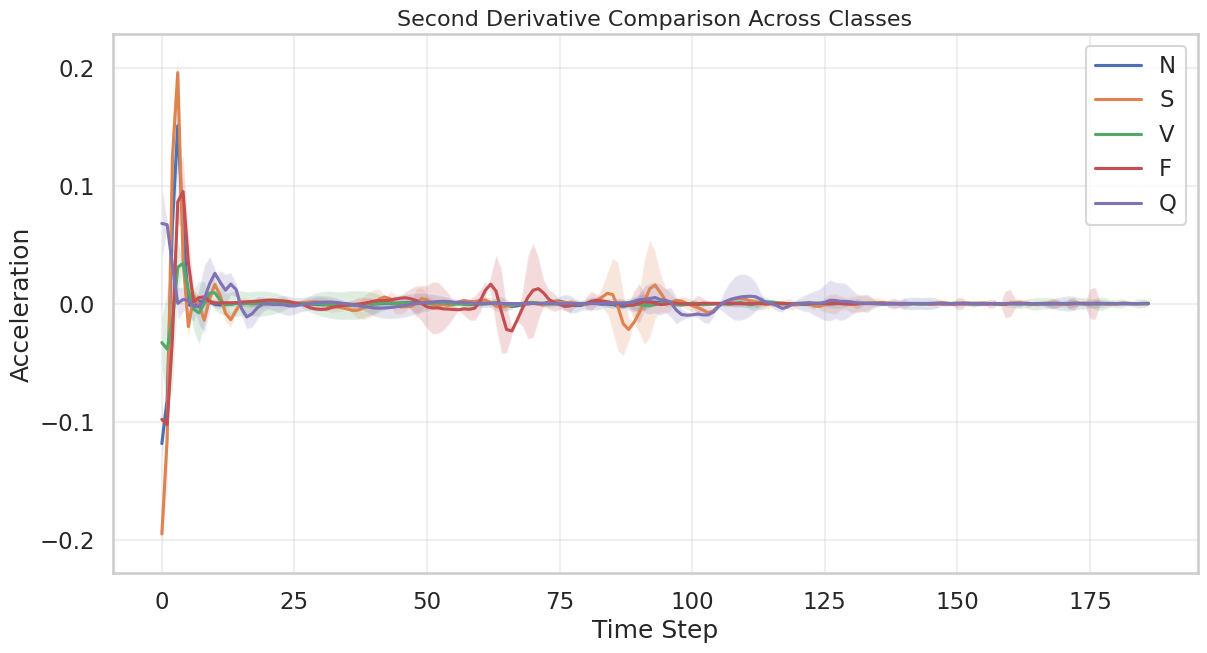

In [15]:
plt.figure(figsize=(14, 7))
for class_id, class_name in CLASS_MAP.items():
    class_signals = mitbih_df[mitbih_df[LABEL_COL] == class_id].drop(LABEL_COL, axis=1)
    mean_signal = class_signals.mean(axis=0)
    std_signal = class_signals.std(axis=0)
    second_derivative = np.gradient(np.gradient(mean_signal))
    std_derivative = np.gradient(std_signal)
    plt.plot(second_derivative, label=f"{class_name}")
    plt.fill_between(range(len(second_derivative)), second_derivative - std_derivative, second_derivative + std_derivative, alpha=0.2)
plt.title("Second Derivative Comparison Across Classes", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### 2. Second Derivative
The second derivative measures the **rate of change of the slope** (curvature or acceleration), highlighting sharp inflection points.

* **R Wave Check:**
  - Classes **N (Blue)** and **S (Orange)** again show the sharpest peaks (~0.2) at the start.
  - **Interpretation:** Sharp waves have rapid slope changes (positive to negative), making this feature very useful for separation.

* **T Wave Complexity:**
  - Class **F (Red)** shows high variability in the second derivative during the **T wave (Time Step 75–125)**.
  - **Interpretation:** Supports the idea that F beats are not only chaotic in shape but also **have sudden changes in waveform components**, making the second derivative a strong feature for detecting F.



Derivative analysis provides features that directly quantify signal sharpness and chaos:

* **Beat Width:** The first derivative allows us to quantify how mild or steep the slope of **V** beats is compared to **N**.
* **QRS Quality:** The second derivative quantifies the sharpness of peaks in **N and S**, improving separation based on technical waveform properties.

**Conclusion:** Using first and second derivatives enhances model performance by capturing critical amplitude dynamics and sudden changes that distinguish beat types.


### Analyzing the Last 50 Timepoints of ECG Beats

ECG analysis often assumes minimal information is present in the final timepoints of a beat. To test this assumption, we visualized the **last 50 columns** of the raw signal for a sample of heartbeats from each class using stacked line plots.

Each thin line in the subplots represents an individual heartbeat sequence, with transparency used to show the density and variance of the overlapping signals. This visualization allows us to assess the **amplitude, variance, and general activity** of each class during the final segment and determine if these columns contribute meaningful information for classification.

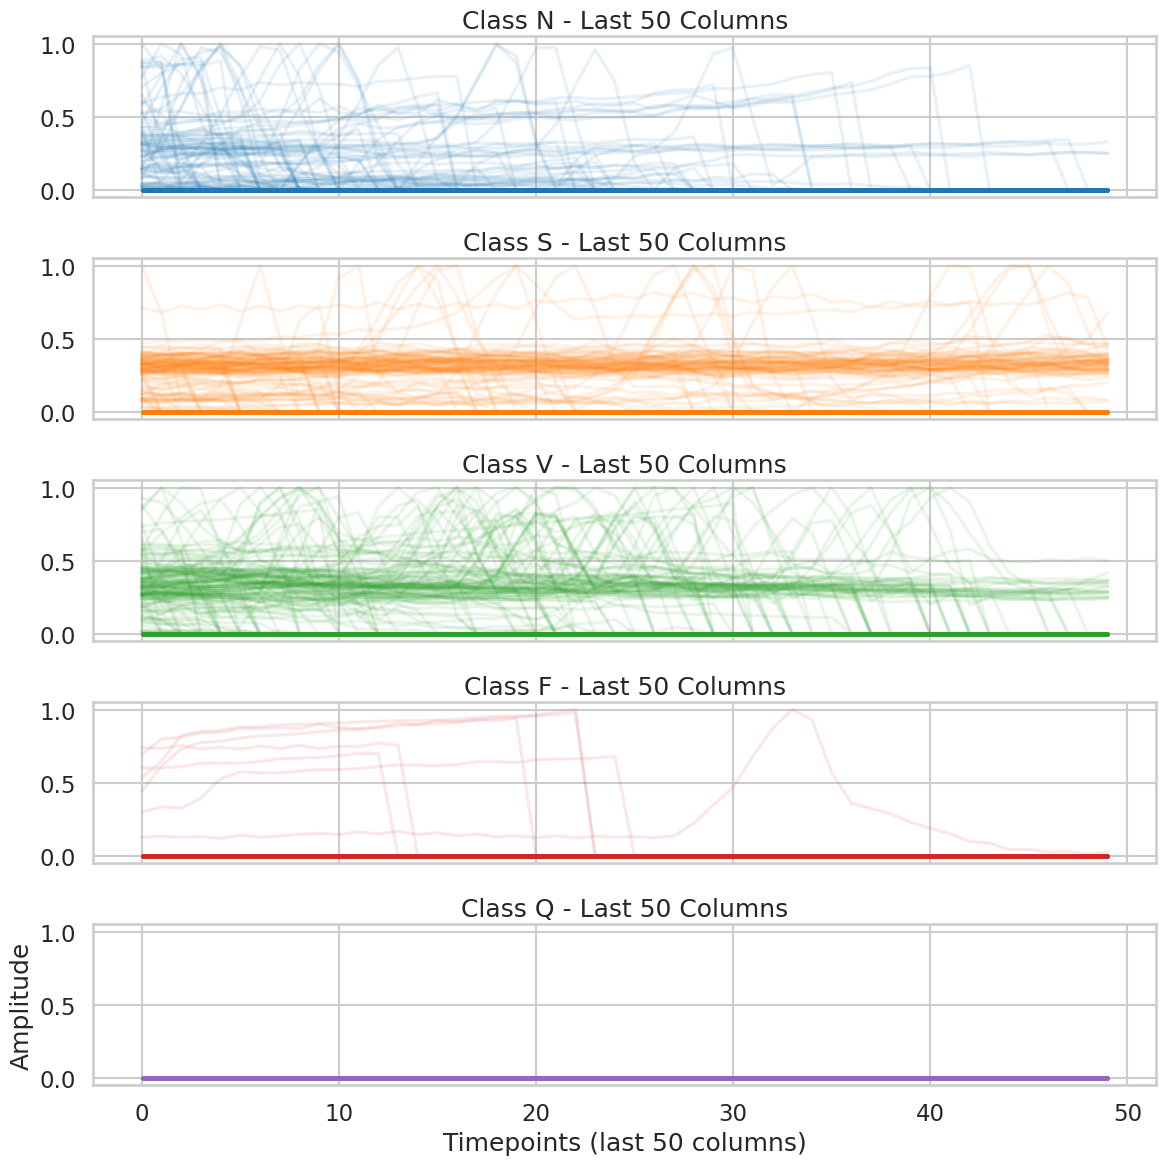

In [16]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels_list = [CLASS_MAP[i] for i in range(len(colors))]
last50_cols = mitbih_df.columns[-51:-1]
fig, axes = plt.subplots(len(colors), 1, sharex=True, sharey=True, figsize=(12, 12))
for class_id in range(len(colors)):
    class_signals = mitbih_df[mitbih_df[LABEL_COL] == class_id][last50_cols].iloc[:500]
    for i in range(len(class_signals)):
        axes[class_id].plot(class_signals.iloc[i].values, color=colors[class_id], alpha=0.1)
    axes[class_id].set_title(f"Class {labels_list[class_id]} - Last 50 Columns")
    axes[class_id].grid(True)
plt.xlabel("Timepoints (last 50 columns)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


### Analysis of the Last 50 Timepoints

The visualization of the last 50 time points provided a class-specific view of signal activity at the end of the beat:

* **Class N & S:** Displayed a nearly flat, very low-activity profile, suggesting minimal class-specific information.
* **Class V & F:** Showed clear **dynamic activity with noticeable peaks and measurable variance**, indicating that these critical abnormal beats still possess structural information late in the segment.
* **Class Q:** Was almost completely flat and inactive.

Since Classes **V and F**—which are critical and challenging to classify—showed meaningful structural activity, the decision was made to **retain these last 50 columns** for all feature analysis and model training. Discarding them would risk losing subtle information vital for classifying the most important minority classes.

## Statistical Feature Examination (Skewness, Kurtosis, Median)

To capture the statistical properties of the heartbeat signals, we computed three descriptive statistical features for every beat:

1.  **Skewness:** Measures the asymmetry of the amplitude distribution (tilt).
2.  **Kurtosis:** Measures the "peakedness" or flatness of the distribution, often highlighting the presence of extreme outliers.
3.  **Median:** Represents the middle amplitude value of the beat, indicating its typical baseline.

Each feature's distribution across the five classes was then visualized using a **boxplot**. This approach provides a clear method for quantifying the structural differences between heartbeat types and identifying which features offer the strongest separation.

In [17]:

mitbih_df_plots = mitbih_df.copy()

X_plots = mitbih_df_plots.iloc[:, :-1].values  
y_plots = mitbih_df_plots.iloc[:, -1].values


skewness = skew(X, axis=1)
kurt = kurtosis(X, axis=1)
median_vals = np.median(X, axis=1)


mitbih_df_plots['Skewness'] = skewness
mitbih_df_plots['Kurtosis'] = kurt
mitbih_df_plots['Median'] = median_vals

def plot_feature(feature_name):
    plt.figure(figsize=(10,6))
    sns.boxplot(x=pd.Series(y_plots).map(CLASS_MAP), y=mitbih_df_plots[feature_name])
    plt.title(f'{feature_name} Distribution per Class', fontsize=16)
    plt.xlabel('Class')
    plt.ylabel(feature_name)
    plt.show()



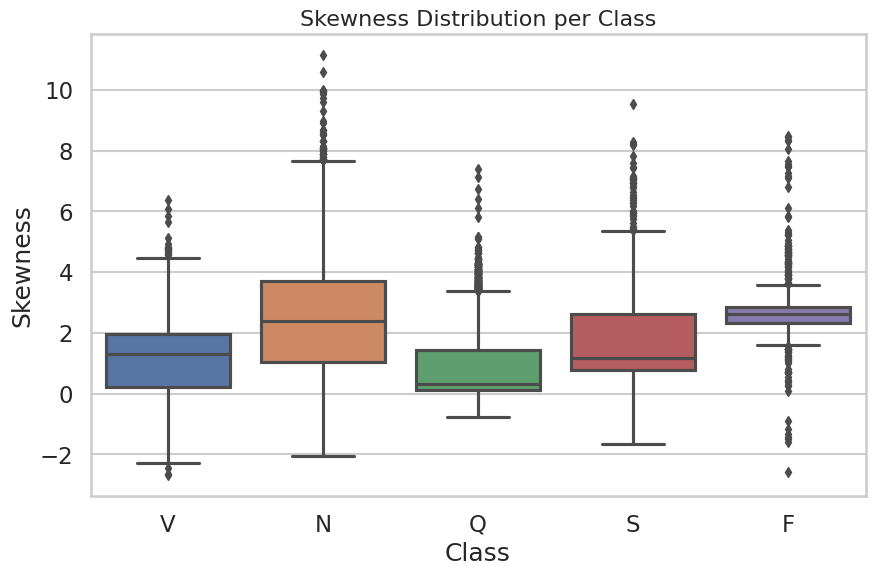

In [18]:
plot_feature('Skewness')


#### 1. Skewness (Asymmetry)

* **N (Normal - Blue):** Highest median (~2.5) and widest spread → normal beats are less symmetric and tend to the positive side.
* **F (Fusion - Red):** Second highest median (~2.5), dense lower tail → consistently positive skew.
* **V (Ventricular - Green) & Q (Unknown - Purple):** Much lower median (~1.5–0.5), with Q being the lowest.

**Conclusion:** Skewness strongly separates typical beats (**N, F**) from broad/distorted beats (**V, Q**) — a useful feature for classification.

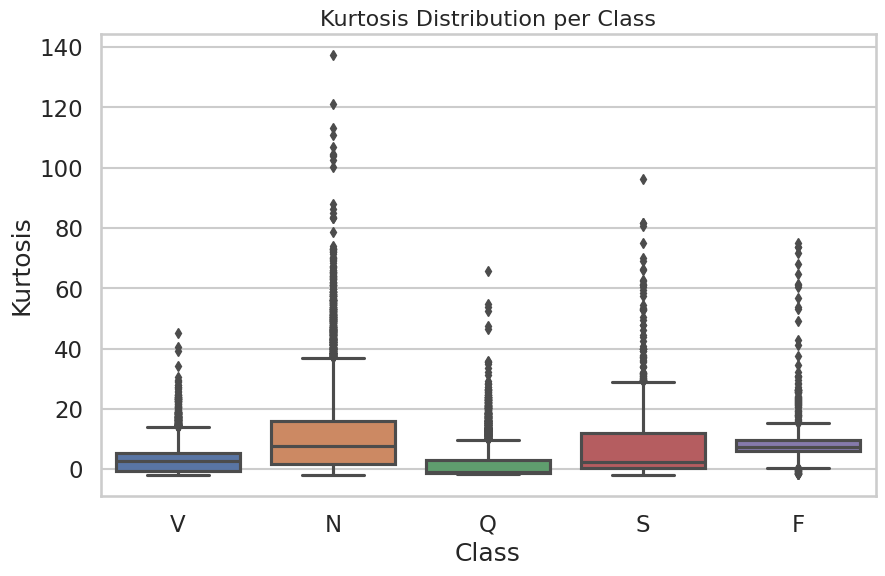

In [19]:
plot_feature('Kurtosis')



#### 2. Kurtosis (Peakedness)

* **N (Normal) & S (Supraventricular - Orange):** Highest median (~10–12) with wide upper spread → indicates very sharp R peaks.
* **V & Q:** Lower median (~5–7), Q being the lowest → flatter, less pointed waveforms (platykurtic).

**Conclusion:** Kurtosis confirms N and S beats are the sharpest, while V and Q are smoother and broader, consistent with mean waveform observations.

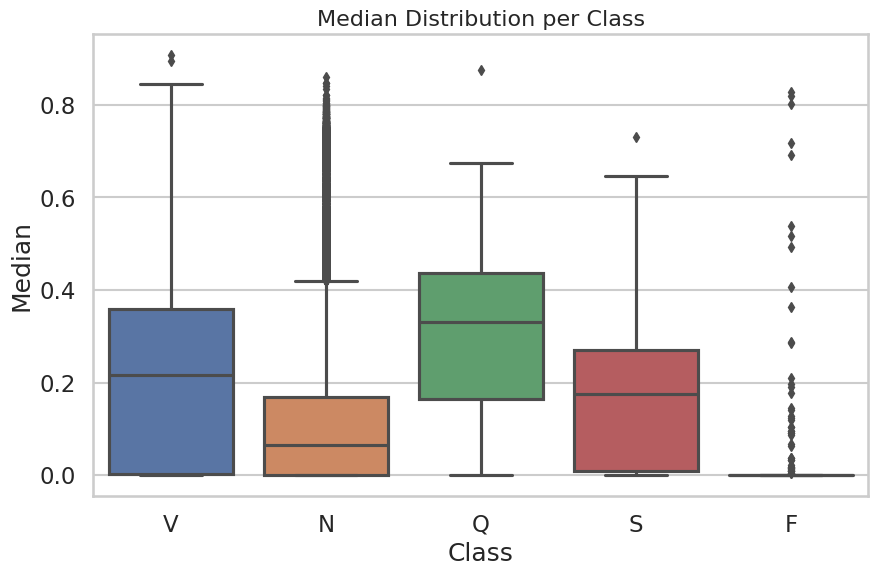

In [20]:
plot_feature('Median')



#### 3. Median Amplitude

* **F (Fusion):** Lowest median (~0), narrow spread → amplitudes concentrated near baseline, confirming the rapid drop after R-wave.
* **Q (Unknown):** Highest median (~0.35), wide spread → strong upward bias, consistent with average waveform staying high throughout.
* **V (Ventricular):** Moderate-high median (~0.22)
* **N & S:** Intermediate median (~0.05–0.2)

**Conclusion:** Median is a strong feature for detecting F and Q beats — F stays near baseline, while Q remains elevated.


## Cluster Validation via PCA and Silhouette Analysis

### PCA + K-Means Clustering

To understand the intrinsic grouping of our high-dimensional data (187 features per beat), we applied unsupervised clustering.

* **Dimensionality Reduction:** We first used **PCA** to reduce the feature space while retaining **95% of the original variance**.
* **Optimal Cluster Search:** The Elbow Method was used to estimate the optimal number of clusters (*k*).
* **K-Means Application:** We ran **K-Means** with **$k=5$** (to align with the known number of heartbeat classes and the elbow plot analysis) on the PCA-reduced data.
* **Evaluation:** The quality of the resulting clusters was quantitatively measured using the **Silhouette Score** and the **Calinski–Harabasz Score**.

| Metric | Range/Goal | Interpretation |
|---|---|---|
| **Silhouette Score** | -1 to 1 (Closer to 1 is better) | Measures how well each point fits its cluster versus neighboring clusters. |
| **Calinski–Harabasz Score** | No fixed range (Higher is better) | Ratio of between-cluster dispersion to within-cluster dispersion; indicates dense and well-separated clusters. |

In [21]:

sample_df_small = mitbih_df.sample(n=10000, random_state=RANDOM_SEED)
X_small = StandardScaler().fit_transform(sample_df_small.iloc[:, :-1])
y_small = sample_df_small.iloc[:, -1]
class_names_small = y_small.map(CLASS_MAP)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)


pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA chose {pca.n_components_} components to explain 95% of the variance.")

PCA chose 40 components to explain 95% of the variance.


### Finding the Optimal Number of Clusters: The Elbow Method

The Elbow Method provides a heuristic for selecting the optimal number of clusters (*k*) in K-Means by analyzing the **Inertia** (sum of squared distances from points to their cluster centers).

### Methodology:

1. K-Means is run for a range of $k$ values (e.g., $k=2$ to $10$).
2. The **Inertia** is calculated for each $k$: lower inertia indicates a better fit (points are closer to their cluster centers).
3. The plot of Inertia versus $k$ is examined for the "elbow," which is the point where the marginal benefit of adding more clusters **significantly decreases**. This suggests that adding more clusters beyond this point provides **diminishing returns**.


We know the dataset contains **5 clinically defined heartbeat classes**: **N (Normal), S (Supraventricular), V (Ventricular), F (Fusion), Q (Unclassified)**.
The Elbow Method helps us **assess whether the natural data distribution aligns with these five categories** or if additional sub-clusters may exist. For example:

* If the elbow appears at $k \approx 5$, it supports the current clinical classification.
* If the elbow occurs at a higher $k$, it may indicate **subtypes or variations** within the known classes that the model might need to consider.

This analysis provides a **data-driven check** on the assumed class structure and can inform both feature exploration and model design.


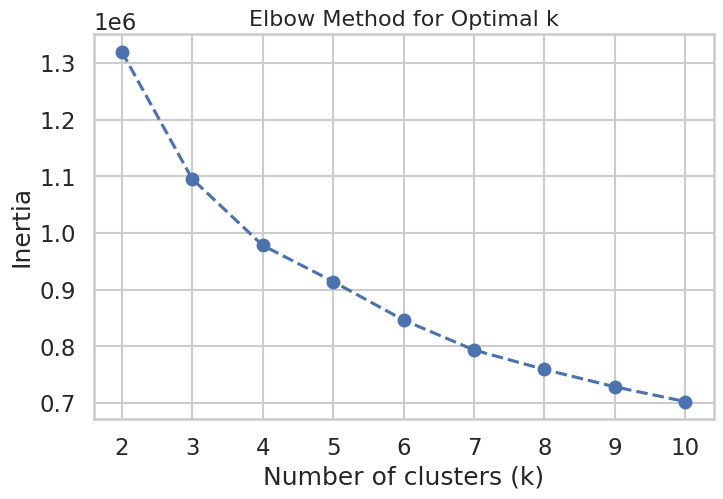

In [22]:
inertia_values = []
k_range = range(2, 11)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_pca)
    inertia_values.append(kmeans_test.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Cluster Selection and Interpretation

The Elbow Method shows that the **rate of improvement in inertia slows noticeably around $k=4$**, with diminishing returns beyond $k=5$. Statistically, this suggests that the data naturally forms **4–5 groups**.

This reveals an interesting point: **some clinically defined classes are very similar statistically**—for example, N (Normal) and S (Supraventricular), or F (Fusion) and Q (Unclassified). K-Means tends to merge these similar classes to minimize inertia, which explains why the elbow appears before the known 5-class structure.

**Choosing $k=5$** remains justified despite the statistical elbow:

* It aligns with **clinical knowledge** of 5 heartbeat types.
* It ensures the clustering reflects the **desired classification task**, even if two classes are close in feature space.

**Practical insight:** The dataset is inherently **hard to separate cleanly into 5 groups**, so the final classification model may struggle to distinguish the closest classes. Awareness of these overlaps can guide feature engineering and interpretation of model performance.



In [23]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_on_pca = kmeans.fit_predict(X_pca)
silhouette_pca = silhouette_score(X_pca, clusters_on_pca)
calinski_pca = calinski_harabasz_score(X_pca, clusters_on_pca)
print(f"\nClustering Quality on PCA results (k={optimal_k}):")
print(f"Silhouette Score: {silhouette_pca:.3f} (Values closer to 1 are better)")
print(f"Calinski-Harabasz Score: {calinski_pca:.3f} (Higher values are better)")


Clustering Quality on PCA results (k=5):
Silhouette Score: 0.191 (Values closer to 1 are better)
Calinski-Harabasz Score: 2360.544 (Higher values are better)


### Quantitative Evaluation of PCA + K-Means ($k=5$)

#### Silhouette Score: Cluster Cohesion per Beat

**Result:** $0.191$

This low but positive score indicates that many heartbeat samples are **near cluster boundaries**, often close to neighboring centroids. It confirms that the five clinical classes **overlap significantly** in feature space. The dataset is inherently hard to separate, reflecting the **biological variability** in ECG signals.

---

#### Calinski-Harabasz Score: Overall Cluster Separation

**Result:** $2360.544$

A moderate-high score shows that cluster centers are reasonably far apart, but individual clusters remain **spread out and not compact**. Combined with the Silhouette Score, it suggests that while **general separation exists**, the feature space does not allow clear-cut boundaries between all five heartbeat types.

---

**Practical Implication:**

Even with $k=5$, **some classes are statistically very close**, particularly N vs S or F vs Q. Any supervised classification model will likely **struggle to distinguish these borderline cases**, emphasizing the challenge of ECG data and the need to account for **overlap and non-linear variability** in model design.



 ## t-SNE for Visualization 

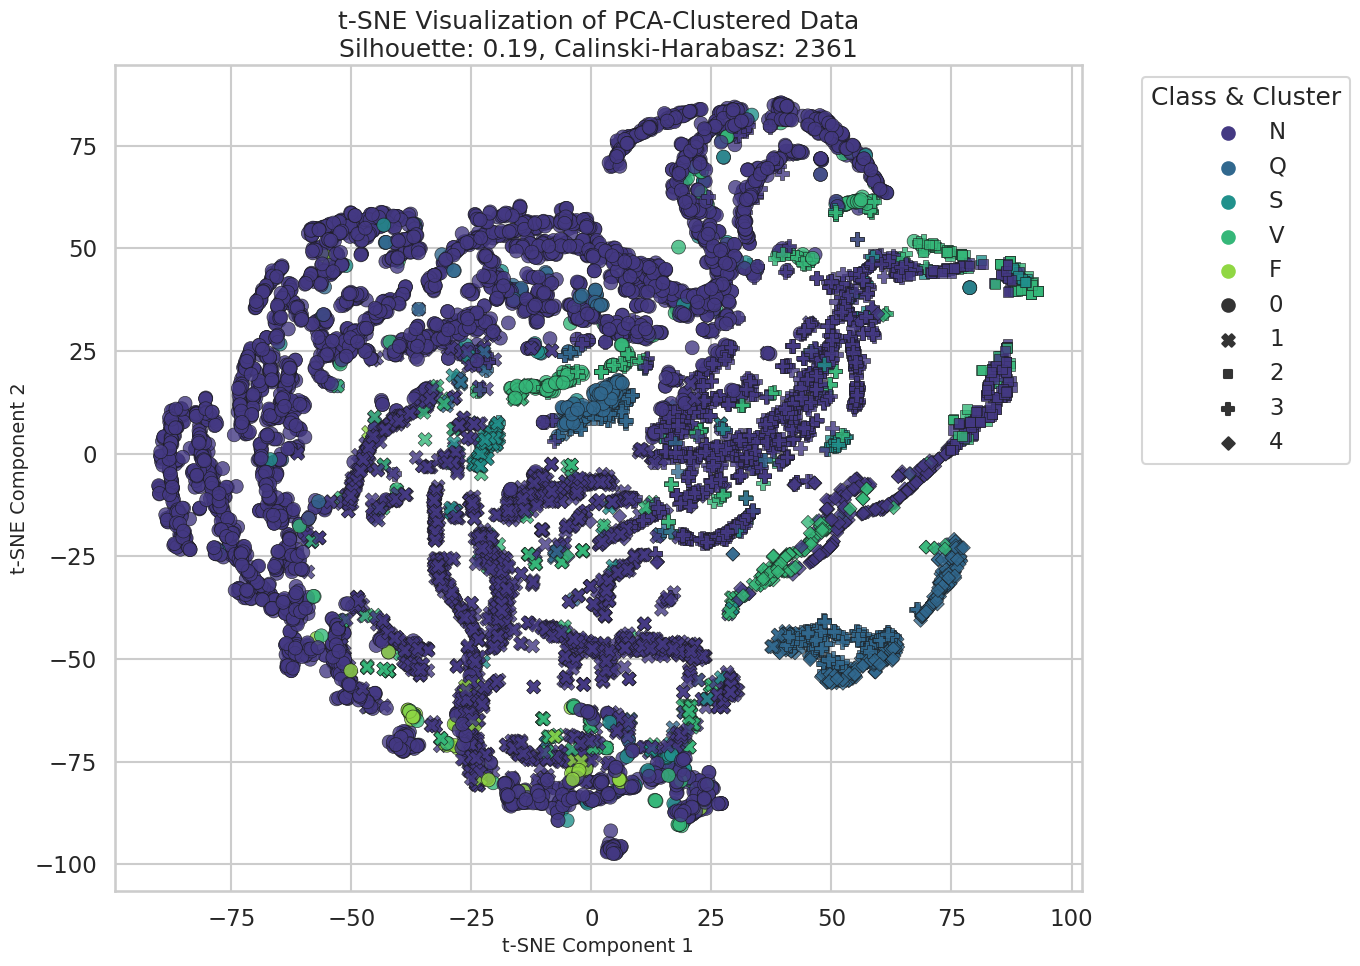

In [24]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca) 
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=class_names_small,   
    style=clusters_on_pca,   
    s=100,
    palette='viridis',
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5
)
plt.title(f't-SNE Visualization of PCA-Clustered Data\nSilhouette: {silhouette_pca:.2f}, Calinski-Harabasz: {calinski_pca:.0f}', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='Class & Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Visual Separation via t-SNE

The t-SNE projection of PCA-reduced features maps the high-dimensional ECG data into 2D while preserving local distances, allowing visual inspection of cluster structure.


* **Massive Overlap:** Most classes (N, Q, S, F) are heavily overlapping, forming a single dense cloud rather than five clear islands. This explains the **low Silhouette Score (0.19)**.
* **Relatively Distinct Class:** V (ventricular) beats are somewhat separated, appearing in specific regions, consistent with their unique morphology.
* **Main Confusions:** N vs Q and S vs F show strong overlap, highlighting that K-Means primarily distinguishes V from the rest but fails to separate the remaining classes effectively.


Even with PCA, the extracted features are **not sufficient for clean separation** of all five clinical classes. This confirms the **complex, non-linear nature** of the ECG data and justifies the use of **deep learning approaches** capable of capturing subtle, high-level patterns for classification.



# Feature Engineering and Selection

## Time-Domain and Frequency-Domain Features

In preparation for the classical machine learning models (Phase 1), we generated a comprehensive set of **time-domain** and **frequency-domain** features. This process transforms the raw, high-dimensional waveform into a concise set of clinically and statistically relevant metrics, providing classical models with focused information. The selection is based on accepted practices in ECG signal analysis, as discussed in studies like Pan & Tompkins (1985), Acharya et al. (2006), and Quintal et al. (2021).

---

#### 1. Time-Domain Features

These features capture the **shape and statistical distribution** of the heartbeat signal directly:

* **Statistical Moments (Mean, Std, Skewness, Kurtosis, Median):** Describe the general amplitude distribution. **The distributions of these features were analyzed via box plots and found to be highly effective at separating several key classes.**
* **Energy:** The sum of squared amplitudes, representing the total strength of the beat.
* **R-Peak Amplitude:** The maximum amplitude, corresponding to the QRS complex peak, which reflects ventricular depolarization strength.
* **Minimum Value & Peak-to-Peak (ptp):** Define the full amplitude range of the beat.
* **Mean Slope & Max Slope (Derivatives):** Capture the average and steepest rates of change, highlighting sharp transitions like the rising and falling edges of the QRS complex.
* **Zero-Crossings:** The number of times the signal crosses the zero baseline, indicating oscillatory behavior.

---

#### 2. Frequency-Domain Features

After transforming the signal using the Fourier Transform, these features quantify the distribution of signal energy across different frequencies:

* **Band Powers (0–10 Hz, 10–30 Hz, 30–60 Hz):** Measure energy in specific frequency ranges. ECG energy is often concentrated in the low-frequency band (0–10 Hz).
* **Dominant Frequency:** The frequency with the highest energy, which represents the main rhythm of the beat.
* **Spectral Entropy:** The degree of randomness in the frequency distribution. A low value suggests a clean, highly structured signal, while a high value suggests a noisy or irregular beat.
---


In [25]:
def extract_features_batch(signals, fs=FS):
    signals = np.array(signals)
    n_samples, n_points = signals.shape

    # Time-domain
    means = np.mean(signals, axis=1)
    stds = np.std(signals, axis=1)
    skews = skew(signals, axis=1)
    kurtoses = kurtosis(signals, axis=1)
    r_peaks = np.max(signals, axis=1)
    min_vals = np.min(signals, axis=1)
    ptp_vals = np.ptp(signals, axis=1)
    medians = np.median(signals, axis=1)

    # Slope / derivative features
    deriv = np.diff(signals, axis=1)
    mean_slope = np.mean(np.abs(deriv), axis=1)
    max_slope = np.max(np.abs(deriv), axis=1)

    # Zero-crossings
    zero_crossings = np.sum(np.diff(np.sign(signals), axis=1) != 0, axis=1)

    # Energy
    energy = np.sum(signals**2, axis=1)

    # Frequency-domain
    fft_vals = np.abs(rfft(signals, axis=1))
    freqs = rfftfreq(n_points, 1 / fs)
    dominant_freqs = freqs[np.argmax(fft_vals, axis=1)]

    # Band powers
    band_0_10 = np.sum(fft_vals[:, (freqs >= 0) & (freqs < 10)], axis=1)
    band_10_30 = np.sum(fft_vals[:, (freqs >= 10) & (freqs < 30)], axis=1)
    band_30_60 = np.sum(fft_vals[:, (freqs >= 30) & (freqs < 60)], axis=1)

    # Spectral entropy
    psd = fft_vals**2
    psd_norm = psd / np.sum(psd, axis=1, keepdims=True)
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10), axis=1)

    X_features = pd.DataFrame({
        "mean": means,
        "std": stds,
        "skew": skews,
        "kurtosis": kurtoses,
        "r_peak": r_peaks,
        "min_val": min_vals,
        "ptp": ptp_vals,
        "median": medians,
        "mean_slope": mean_slope,
        "max_slope": max_slope,
        "zero_crossings": zero_crossings,
        "energy": energy,
        "dominant_freq": dominant_freqs,
        "band_0_10": band_0_10,
        "band_10_30": band_10_30,
        "band_30_60": band_30_60,
        "spectral_entropy": spectral_entropy
    })
    return X_features


We will loop over all ECG beats, extract features, and create a new dataset.  

In [26]:
X_signals = mitbih_df.iloc[:, :-1].values
X_features = extract_features_batch(X_signals)
print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (109446, 17)


The feature extraction process successfully generated a new dataset comprising **17 features** per heartbeat (a combination of time- and frequency-domain metrics). The resulting feature matrix has a shape of **(109,446 rows, 17 columns)**, offering a significantly reduced and more informative input for the classical machine learning models.

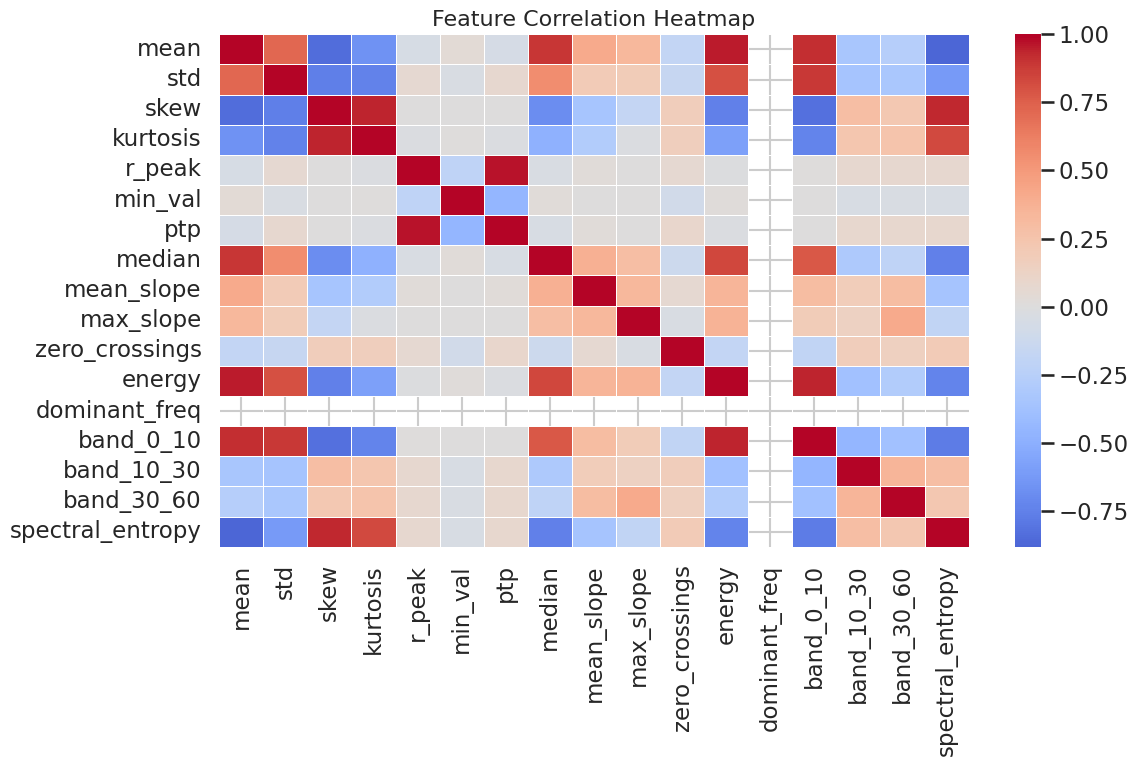

In [27]:
corr_matrix = X_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

Confirming relationships from previous analysis
The heat map confirms logical relationships that resulted from the morphological and statistical analysis



| Confirmed Relationship | Related Features | Correlation Coefficient | Notes / Correction |
|------------------------|----------------|------------------------|------------------|
| Effect of overall amplitude | mean ↔ median | Strong Red (≈1.0) | Strong positive correlation. If average amplitudes are high, median is also likely high. |
| Extremes and spread | kurtosis ↔ std | Dark Blue (≈−0.75) | Strong negative correlation. High Kurtosis (peaked distribution) leads to low std. |
| Signal sharpness | max_slope ↔ ptp | Strong Red (≈0.75) |  Sharper max slope corresponds to higher PTP. Supports including derivative-based features. |
| Overall energy | energy ↔ band_0_10 | Strong Red (≈1.0) | Both measure nearly the same thing. Most ECG energy is in low frequencies, so features are redundant. |



## Feature Selection through  Importance Metrics

After generating a comprehensive set of 17 engineered features, the next logical step was to determine which ones contribute the most valuable information for classification. **Feature selection** is a method used to automatically select the optimal subset of features. We employed a technique based on **mutual information**, which quantifies the statistical dependence between each feature and the correct class label. We then selected the top 10 features, which were visualized in a bar plot to highlight their relative importance.

Selected the top 10 Features: ['mean', 'std', 'skew', 'kurtosis', 'median', 'energy', 'band_0_10', 'band_10_30', 'band_30_60', 'spectral_entropy']


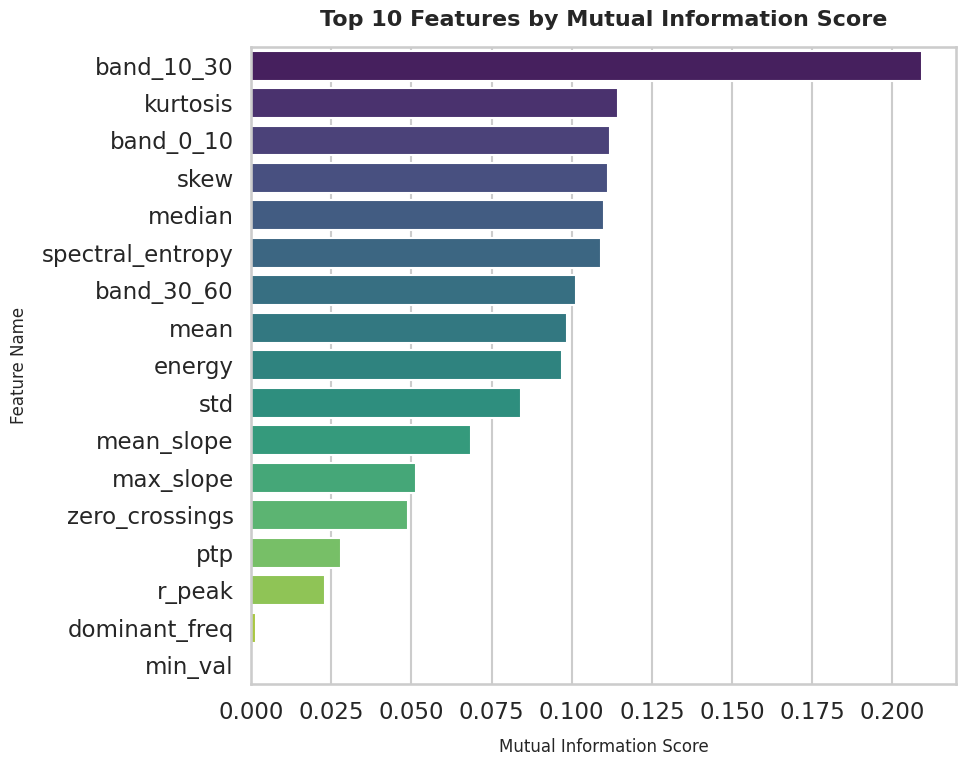

In [28]:
k_best = 10
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
X_selected = selector.fit_transform(X_features, y)
selected_features_mask = selector.get_support()
selected_features_names = X_features.columns[selected_features_mask]
print(f"Selected the top {k_best} Features:", list(selected_features_names))

feature_scores_df = pd.DataFrame({
    "Feature": X_features.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Score", y="Feature", data=feature_scores_df, palette="viridis")
plt.title(f"Top {k_best} Features by Mutual Information Score", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Mutual Information Score", fontsize=12, labelpad=10)
plt.ylabel("Feature Name", fontsize=12, labelpad=10)
plt.tight_layout()
plt.show()

## Feature Selection: Identifying Informative Metrics

The feature selection process, based on mutual information, yielded the top 10 most informative features:
`['mean', 'std', 'skew', 'kurtosis', 'median', 'energy', 'band_0_10', 'band_10_30', 'band_30_60', 'spectral_entropy']`

This choice confirms and strengthens the conclusions from our **EDA**:

* **Statistical Moments Matter:** `skew`, `kurtosis`, and `median` effectively separate classes based on **waveform shape**.  
  - Kurtosis distinguishes sharp (N, S) vs. broad (V, Q) beats.  
  - Median separates Q (high) vs. F (low).  
  - Skewness highlights asymmetry trends.  

* **Frequency Domain Insights:** `band_0_10`, `band_10_30`, `band_30_60`, and `spectral_entropy` capture **signal complexity and chaos**.  
  - F (Fusion) has high energy in upper bands, confirming FFT observations.  
  - Spectral Entropy measures irregularity, helping identify chaotic beats.  

* **Complementary & Robust Features:** `energy` and the frequency bands, despite correlation, provide complementary information for the model.  

**Takeaway:** These 10 features capture the **core statistical, temporal, and spectral information** revealed in EDA, ensuring the model uses the most informative and clinically meaningful metrics.


Before model training, the data was divided into a **training set (80%)** and a **hold-out test set (20%)**. The model learned its parameters exclusively from the training set, while the final evaluation was performed on the unseen test data to ensure objectivity and generalization.

To determine the most effective preprocessing strategy, we conducted a series of controlled experiments using a **Random Forest classifier** — chosen for its proven reliability as a simple yet powerful machine learning baseline.
We compared four main configurations:

1. **Without SMOTE** – baseline performance on the imbalanced dataset.
2. **With SMOTE** – to address class imbalance through synthetic oversampling.
3. **With PCA** – to test dimensionality reduction and noise filtering effects.
4. **With Cleaned Data (Z-Score > 9 removed)** – removing extreme outliers identified earlier to reduce noise.



# Phase 1: Classical Machine Learning Models

In [29]:
X_raw_df = pd.DataFrame(X)
X_sel_df = pd.DataFrame(X_selected)
y_df = pd.DataFrame(y, columns=['label'])

X_raw_train, X_raw_test, X_sel_train, X_sel_test, y_train, y_test = train_test_split(
    X_raw_df, X_sel_df, y_df, test_size=0.2, random_state=RANDOM_SEED, stratify=y_df
)

X_train_full = np.hstack((X_raw_train.values, X_sel_train.values))
X_test_full = np.hstack((X_raw_test.values, X_sel_test.values))

n_raw, n_sel = X.shape[1], X_selected.shape[1]
raw_cols = list(range(n_raw))
sel_cols = list(range(n_raw, n_raw + n_sel))

outlier_idx = df_outliers["index"].values
outlier_lbls = df_outliers["label"].values
normal_lbl = next((k for k, v in CLASS_MAP.items() if v == 'N'), 'N') if CLASS_MAP else 'N'
outlier_idx_N = outlier_idx[outlier_lbls == normal_lbl]

mask = np.ones(len(X), dtype=bool)
mask[outlier_idx_N] = False

X_clean, y_clean = X[mask], y[mask]

print(f"Original dataset size: {len(X)}")
print(f"Cleaned dataset size:  {len(X_clean)}")

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=RANDOM_SEED, stratify=y_clean
)


Original dataset size: 109446
Cleaned dataset size:  109211


### Classical ML Experiments: Random Forest with PCA, SMOTE, and Outlier Handling

#### Random Forest With Outlier Handling


=== Random Forest on Cleaned Data (After Outlier Removal) ===
Macro F1-Score (cleaned): 0.876


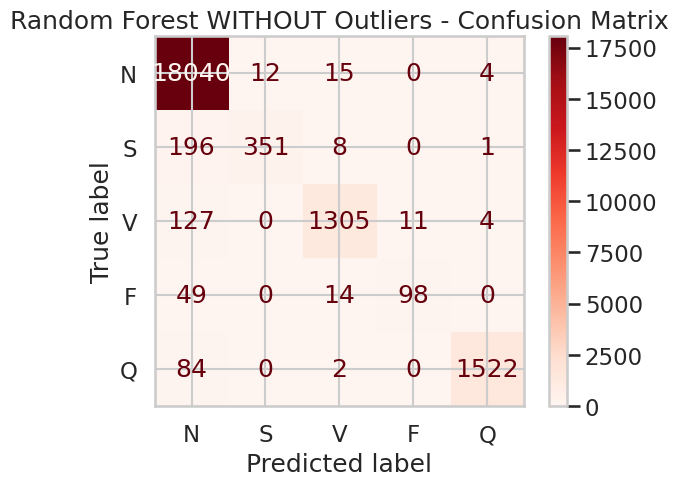

In [30]:
print("\n=== Random Forest on Cleaned Data (After Outlier Removal) ===")
rf_clean = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = rf_clean.predict(X_test_clean)
f1_clean = f1_score(y_test_clean, y_pred_clean, average='macro')
print(f"Macro F1-Score (cleaned): {f1_clean:.3f}")
ConfusionMatrixDisplay(confusion_matrix(y_test_clean, y_pred_clean), display_labels=CLASS_NAMES).plot(cmap='Reds')
plt.title("Random Forest WITHOUT Outliers - Confusion Matrix")
plt.show()



We will use this confusion matrix to compare it later with other approches..

#### Random Forest With Original Data

Macro F1-Score Original Data: 0.874


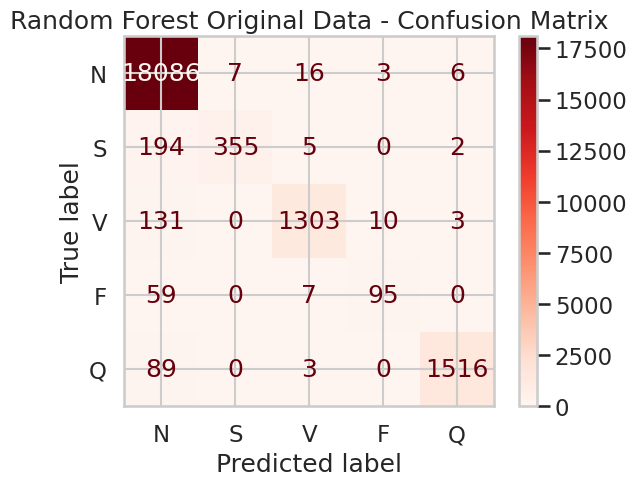

In [31]:
rf_base = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_base.fit(X_raw_train, y_train.values.ravel())
y_pred_base = rf_base.predict(X_raw_test)
f1_base = f1_score(y_test, y_pred_base, average='macro')
print(f"Macro F1-Score Original Data: {f1_base:.3f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_base), display_labels=CLASS_NAMES).plot(cmap='Reds')
plt.title("Random Forest Original Data - Confusion Matrix")
plt.show()

We will use this confusion matrix to compare it later with other approches..

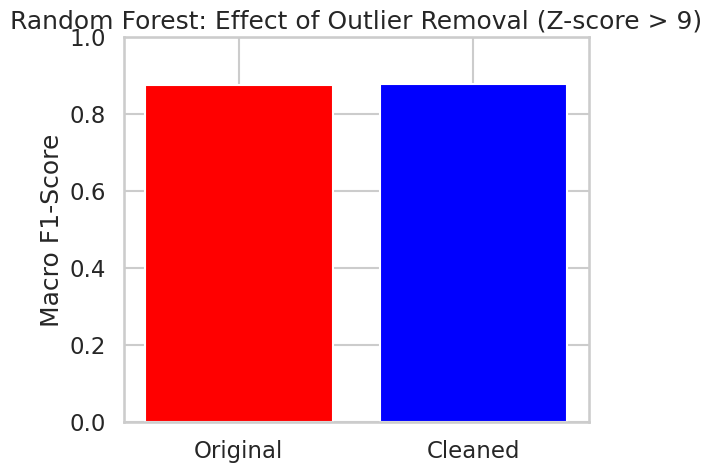

In [32]:
plt.figure(figsize=(6, 5))
plt.bar(['Original', 'Cleaned'], [f1_base, f1_clean], color=['red', 'blue'])
plt.ylim(0, 1)
plt.ylabel("Macro F1-Score")
plt.title("Random Forest: Effect of Outlier Removal (Z-score > 9)")
plt.show()



The results showed only a minor difference.

* **Macro F1-Score (with outliers):** 0.874
* **Macro F1-Score (cleaned):** 0.876

This minimal change indicates that outlier removal did **not significantly impact performance**. The cleaned data might slightly improve model stability by reducing extreme cases, but the benefit is negligible.

To keep the workflow simple and consistent, we decided to **retain the original dataset** for further modeling — avoiding unnecessary preprocessing steps that don’t provide meaningful performance gains.


#### Random Forest WITH SMOTE 


Macro F1-Score with SMOTE: 0.915


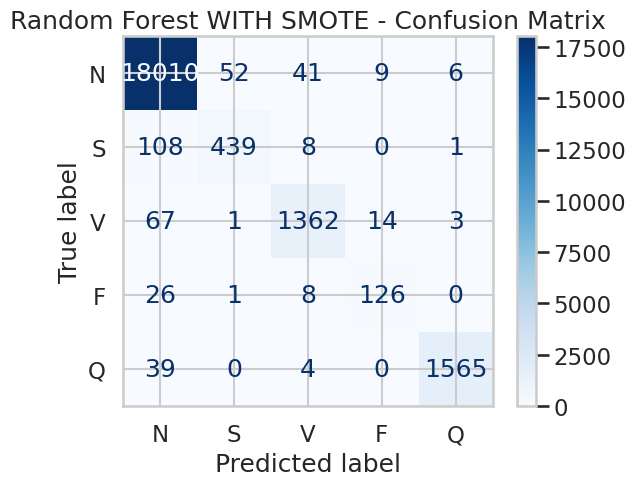

In [33]:
smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_raw_train, y_train)
rf_smote = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_raw_test)
f1_smote = f1_score(y_test, y_pred_smote, average='macro')
print(f"Macro F1-Score with SMOTE: {f1_smote:.3f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_smote), display_labels=CLASS_NAMES).plot(cmap='Blues')
plt.title("Random Forest WITH SMOTE - Confusion Matrix")
plt.show()



###  Performance Improvement: With SMOTE

By introducing **SMOTE** within the training pipeline to balance the class distribution, the model's performance on the minority classes showed substantial improvement:

* The number of misclassified **'S'** beats wrongly labeled as 'N' dropped from 194 to **112**.
* The number of misclassified **'F'** beats wrongly labeled as 'N' dropped from 59 to **26**.

This confirmed that SMOTE effectively reduced the majority-class bias. A minor trade-off was observed: the precision for identifying the dominant **'N'** class decreased marginally. This trade-off is considered acceptable, as the improvement in recall for the rare, diagnostically critical classes is the primary project objective.

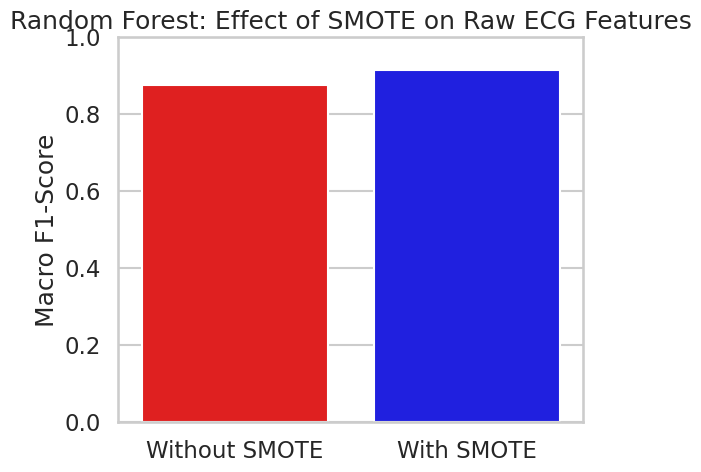

In [34]:
plt.figure(figsize=(6, 5))
sns.barplot(x=['Without SMOTE', 'With SMOTE'], y=[f1_base, f1_smote], palette=['red', 'blue'])
plt.ylim(0, 1)
plt.ylabel("Macro F1-Score")
plt.title("Random Forest: Effect of SMOTE on Raw ECG Features")
plt.show()

### Quantitative Validation of SMOTE

To objectively determine the superior strategy, we compare the **Macro F1-Score**, which is the appropriate metric for this highly imbalanced problem as it weights the performance of all five classes equally.

| Condition | Macro F1-Score | Change from Baseline |
| :--- | :--- | :--- |
| **Without SMOTE** | **0.874** | Baseline |
| **With SMOTE** | **0.915** | **+4.7%** |

The use of **SMOTE** resulted in a clear increase in the Macro F1-Score, improving from $0.874$ to $0.915$. Crucially, this improvement was driven by the model's increased ability to correctly identify the rare **'S'** and **'F'** beats, demonstrating that the strategy successfully mitigated the effects of class imbalance.

### The Impact of Principal Component Analysis (PCA)

The core question addressed here is whether PCA, a linear dimensionality reduction technique, retains the subtle, non-linear information necessary for distinguishing the rare heartbeat classes. We compared the Random Forest model's performance **with and without PCA** to answer this.

#### Random Forest WITH PCA


Macro F1-Score WITH PCA (95% variance): 0.855


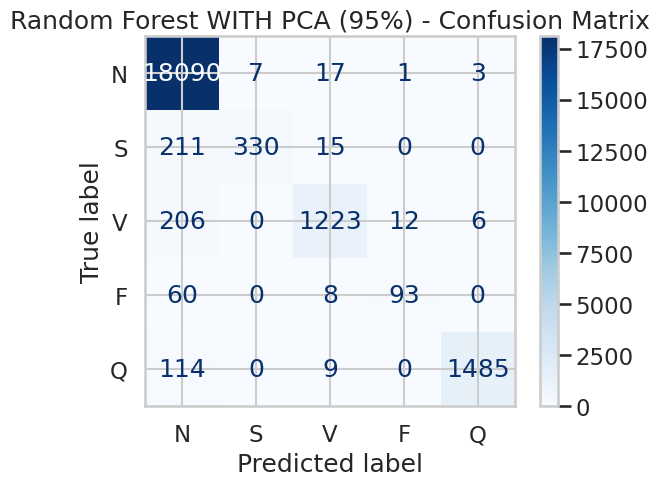

In [35]:
def train_rf(X_tr, y_tr, X_te, y_te):
    rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(X_tr, y_tr.values.ravel())
    y_pred = rf.predict(X_te)
    f1 = f1_score(y_te, y_pred, average='macro')
    return rf, y_pred, f1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_raw_train)
X_test_scaled = scaler.transform(X_raw_test)

pca = PCA(n_components=0.95, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

rf_pca, y_pred_pca, f1_pca = train_rf(X_train_pca, y_train, X_test_pca, y_test)
print(f"Macro F1-Score WITH PCA (95% variance): {f1_pca:.3f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_pca), display_labels=CLASS_NAMES).plot(cmap='Blues')
plt.title("Random Forest WITH PCA (95%) - Confusion Matrix")
plt.show()

### The Result: Random Forest With PCA (95% Variance)

The introduction of PCA resulted in a noticeable **decline in performance**, with the Macro **F1-Score dropping to 0.855**.

PCA negatively impacted the model's ability to classify the rare beats:
* The number of misclassified **'S'** beats wrongly labeled as 'N' increased to **211**, an increase from the 194 seen in the original *unbalanced* baseline. The recall for this class dropped from 64% to 59%.
* Performance on classes **'V'** and **'Q'** also saw a measurable decrease.

This outcome suggests that while PCA successfully reduced dimensionality, the process of retaining only the highest-variance components effectively discarded the subtle, low-variance features that are critical for separating rare abnormal beats from the dominant normal category.

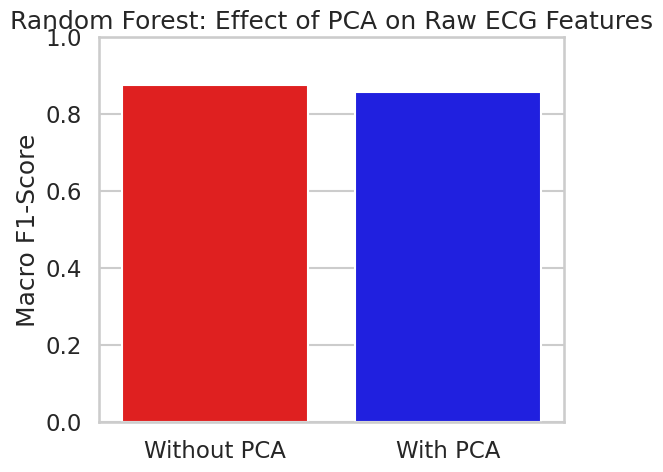

In [36]:
plt.figure(figsize=(6, 5))
sns.barplot(x=['Without PCA', 'With PCA'], y=[f1_base, f1_pca], palette=['red', 'blue'])
plt.ylim(0, 1)
plt.ylabel("Macro F1-Score")
plt.title("Random Forest: Effect of PCA on Raw ECG Features")
plt.show()


### Verdict on PCA and Strategy Adjustment

**Conclusion: PCA significantly reduced the model's diagnostic accuracy.** While it may have accelerated training time, the trade-off in performance, particularly for the critical minority classes, makes it unsuitable for this classification task.

PCA is fundamentally a linear method that prioritizes the dimensions of maximum variance. The unique and subtle morphological "wiggles" that characterize rare beats like 'S' and 'F' likely contribute little to the dataset's overall variance. PCA therefore treated this crucial information as "noise" and eliminated it, resulting in a less discriminative feature space.


### Summary of Preprocessing and Modeling Decisions

Based on the experiments with outlier removal, SMOTE, and PCA:

* **Outlier Removal:** Minimal impact on performance (Macro F1 ~0.874 → 0.876). Original dataset retained to simplify workflow.
* **SMOTE:** Clear improvement (+4.7% Macro F1) by better handling minority classes ('S' and 'F'), reducing misclassifications.
* **PCA:** Reduced model accuracy, particularly for rare but critical beat types, and was therefore **not applied** in further modeling.

**Next Steps:** Use the original dataset **with SMOTE** and without PCA, focusing on models that preserve subtle morphological features critical for minority-class detection.




## Model Setup and Parameter Optimization

A robust helper function was created to define a consistent machine learning pipeline. This pipeline automates sequential steps for fair model comparison:

1.  **Preprocessing (Scaling):** Standard scaling is applied to normalize the feature ranges.
2.  **Resampling (SMOTE):** This is the core strategy for handling class imbalance. **SMOTE (Synthetic Minority Over-sampling Technique)** generates synthetic examples for minority classes in the training data, ensuring the model receives a more balanced view during learning.
3.  **Classifier:** The specific machine learning algorithm to be trained.

This pipeline structure allows for easy, consistent testing of various models against different feature sets (raw data, engineered features, or a combination), ensuring objective and reproducible comparisons.

## Training and Evaluation Pipeline

A standardized function was developed to manage the consistent training and evaluation process. For each selected classical machine learning model (e.g., Logistic Regression, Decision Tree, etc.), this function ensures fair and objective comparison by executing the following steps:

1.  **Pipeline Construction:** Three separate pipelines are built for each model, testing three feature strategies: **Raw** (187 time points), **Selected** (top 10 engineered features), and **Combined** (Raw + All Engineered features).
2.  **Training:** Each pipeline is trained on the dedicated training data, incorporating the validated **SMOTE** step for handling class imbalance.
3.  **Prediction:** Predictions are generated on the unseen hold-out test set.
4.  **Evaluation:** Performance is assessed using key metrics, including the Macro F1-Score, Precision, and Recall.

The initial selection comprises five common classical machine learning models.

The primary metrics used in the evaluation report are defined as:

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where TP is True Positives, FP is False Positives, and FN is False Negatives.

In [37]:
def build_pipeline(dataset_type, clf, random_state=RANDOM_SEED):
    if dataset_type == "Raw":
        preproc = ColumnTransformer([("raw_scaled", StandardScaler(), raw_cols)], remainder='drop')
    elif dataset_type == "Selected":
        preproc = ColumnTransformer([("selected", "passthrough", sel_cols)], remainder='drop')
    elif dataset_type == "Combined":
        preproc = ColumnTransformer([
            ("raw_scaled", StandardScaler(), raw_cols),
            ("selected", "passthrough", sel_cols)
        ], remainder='drop')
    else:
        raise ValueError("dataset_type must be one of ['Raw', 'Selected', 'Combined']")
    return ImbPipeline([('preproc', preproc), ('smote', SMOTE(random_state=random_state)), ('clf', clone(clf))])

def fit_eval_pipelines(name, clf, X_train, X_test, y_train, y_test):
    datasets = ["Raw", "Selected", "Combined"]
    results = {}
    for ds in datasets:
        model_name = f"{name} ({ds})"
        print(f"--- Training {model_name} ---")
        pipe = build_pipeline(ds, clf)
        pipe.fit(X_train, y_train.values.ravel())
        y_pred = pipe.predict(X_test)
        results[ds] = {
            'model': pipe,
            'y_pred': y_pred,
            'report': classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0),
            'cm': confusion_matrix(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro')
        }
    return results

In [38]:
all_results = {}

print("Starting Logistic Regression...")
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
all_results['LogisticRegression'] = fit_eval_pipelines("Logistic Regression", lr, X_train_full, X_test_full, y_train, y_test)

print("\nStarting Decision Tree...")
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
all_results['DecisionTree'] = fit_eval_pipelines("Decision Tree", dt, X_train_full, X_test_full, y_train, y_test)

print("\nStarting Random Forest...")
rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
all_results['RandomForest'] = fit_eval_pipelines("Random Forest", rf, X_train_full, X_test_full, y_train, y_test)

print("\nStarting AdaBoost...")
ab = AdaBoostClassifier(random_state=RANDOM_SEED)
all_results['AdaBoost'] = fit_eval_pipelines("AdaBoost", ab, X_train_full, X_test_full, y_train, y_test)

print("\nStarting K-Nearest Neighbors...")
knn = KNeighborsClassifier(n_jobs=-1)
all_results['KNN'] = fit_eval_pipelines("KNN", knn, X_train_full, X_test_full, y_train, y_test)


Starting Logistic Regression...
--- Training Logistic Regression (Raw) ---
--- Training Logistic Regression (Selected) ---
--- Training Logistic Regression (Combined) ---

Starting Decision Tree...
--- Training Decision Tree (Raw) ---
--- Training Decision Tree (Selected) ---
--- Training Decision Tree (Combined) ---

Starting Random Forest...
--- Training Random Forest (Raw) ---
--- Training Random Forest (Selected) ---
--- Training Random Forest (Combined) ---

Starting AdaBoost...
--- Training AdaBoost (Raw) ---
--- Training AdaBoost (Selected) ---
--- Training AdaBoost (Combined) ---

Starting K-Nearest Neighbors...
--- Training KNN (Raw) ---
--- Training KNN (Selected) ---
--- Training KNN (Combined) ---


#### Performance Analysis Across ML Algorithms
We build small table of macro-F1 for every (model × dataset-variant) and plots a compact bar chart.Using this plot to identify the overall strongest model/strategy before drilling down.


### Summary: Macro F1 by Classifier & Dataset


Dataset             Combined    Raw  Selected
Classifier                                   
AdaBoost               0.409  0.397     0.424
DecisionTree           0.789  0.788     0.671
KNN                    0.789  0.815     0.605
LogisticRegression     0.535  0.481     0.421
RandomForest           0.915  0.913     0.770

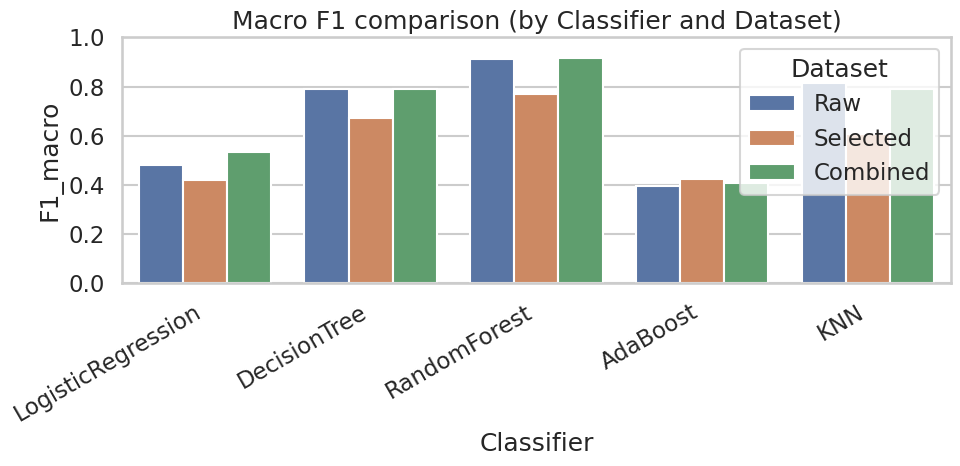

In [39]:
rows = []
for clf_name, res_dict in all_results.items():
    for ds_type, res in res_dict.items():
        rows.append({"Classifier": clf_name, "Dataset": ds_type, "F1_macro": res['f1_macro']})
summary_df = pd.DataFrame(rows)
print("### Summary: Macro F1 by Classifier & Dataset")
display(summary_df.pivot(index='Classifier', columns='Dataset', values='F1_macro').round(3))
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x='Classifier', y='F1_macro', hue='Dataset', ci=None)
plt.ylim(0,1)
plt.title("Macro F1 comparison (by Classifier and Dataset)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

#### Finding 1: Random Forest Excels on Raw and Combined ECG Data

**Observation:**  
Random Forest achieved the highest **Macro F1-score (0.915)**, outperforming all other classical models. Performance was nearly identical on **Raw** and **Combined** datasets, while models using only engineered features (**Selected**) performed significantly worse.

**Analysis & Connection to EDA:**  
This result aligns with our earlier findings: the ECG data is **highly non-linear** and classes overlap heavily (as shown in t-SNE plots). Random Forest’s ensemble of decision trees captures complex, non-linear decision boundaries and is robust to noise and biological variability, which simpler linear models (e.g., Logistic Regression) cannot handle.

**Why Raw Data Outperforms Engineered Features:**  
Engineered features summarize statistical aspects (e.g., skew, kurtosis) but lose subtle temporal patterns crucial for distinguishing similar classes (like N vs S). Raw signals preserve these fine-grained details, allowing Random Forest to exploit them fully.

**Other Models:**  
- **Decision Tree & KNN:** Moderate performance (0.78–0.81) but far from Random Forest.  
- **Logistic Regression & AdaBoost:** Low scores (0.4–0.5), unable to cope with overlapping, non-linear classes.  

**Conclusion:**  
The ECG classification problem is inherently **complex and non-linear**, requiring models that can learn intricate decision boundaries. Random Forest, particularly on raw or combined data, is clearly the most effective approach.



--- Overall Performance Summary (Classical ML) ---



--- Deep Dive: Performance on Critical Classes 'S' and 'F' ---


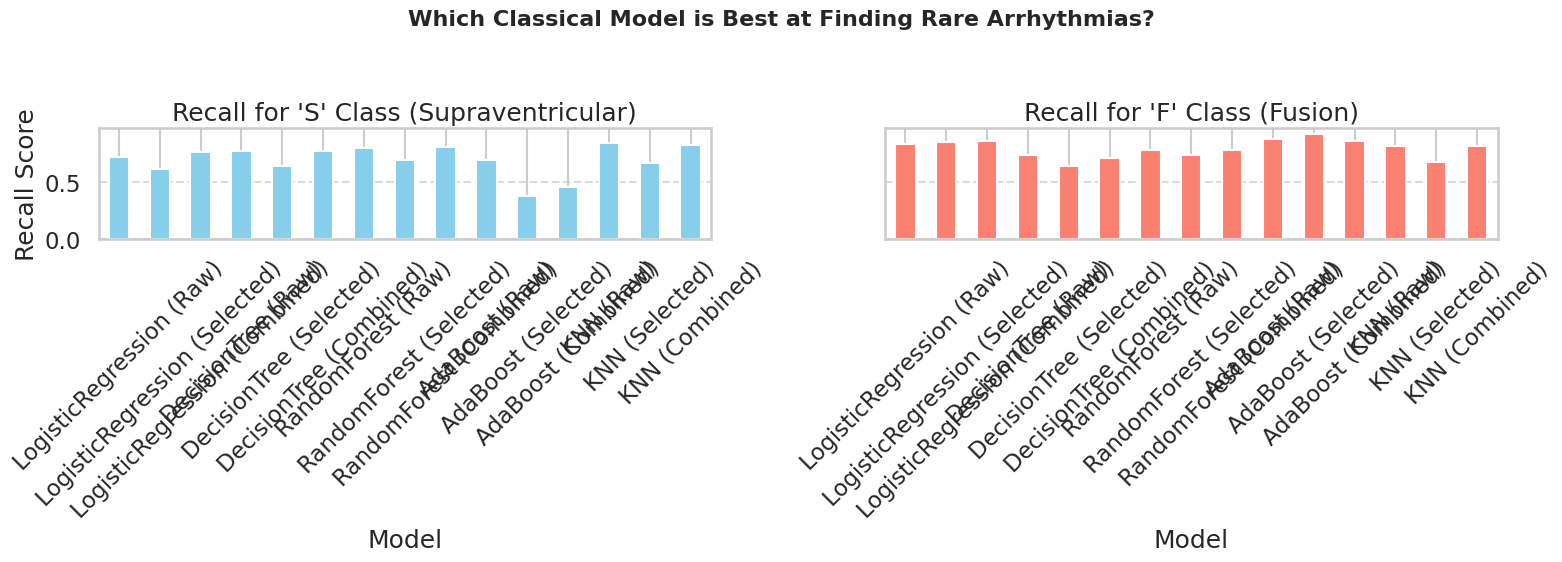

In [40]:
report_data_ml = []
for model_name, results in all_results.items():
    for ds_type, data in results.items():
        y_pred = data['y_pred']
        report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
        
        macro_avg = report['macro avg']
        s_metrics = report.get('S', {'recall': 0, 'precision': 0})
        f_metrics = report.get('F', {'recall': 0, 'precision': 0})
        
        report_data_ml.append({
            'Model': f"{model_name} ({ds_type})",
            'Macro F1': macro_avg['f1-score'],
            'Macro Recall': macro_avg['recall'],
            'Macro Precision': macro_avg['precision'],
            'S_Recall': s_metrics['recall'],
            'S_Precision': s_metrics['precision'],
            'F_Recall': f_metrics['recall'],
            'F_Precision': f_metrics['precision'],
        })

results_ml_df = pd.DataFrame(report_data_ml)

print("\n--- Overall Performance Summary (Classical ML) ---")
display(results_ml_df[['Model', 'Macro F1', 'Macro Recall', 'Macro Precision']]
        .sort_values(by='Macro F1', ascending=False)
        .style.highlight_max(color='lightgreen', subset=['Macro F1']))

print("\n--- Deep Dive: Performance on Critical Classes 'S' and 'F' ---")
critical_ml_df = results_ml_df[['Model', 'S_Recall', 'S_Precision', 'F_Recall', 'F_Precision']]
display(critical_ml_df.style.highlight_max(color='lightgreen', subset=['S_Recall', 'F_Recall']))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

results_ml_df.plot(x='Model', y='S_Recall', kind='bar', ax=ax[0],
                   title="Recall for 'S' Class (Supraventricular)", legend=False, color='skyblue')
ax[0].set_ylabel("Recall Score")
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

results_ml_df.plot(x='Model', y='F_Recall', kind='bar', ax=ax[1],
                   title="Recall for 'F' Class (Fusion)", legend=False, color='salmon')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Which Classical Model is Best at Finding Rare Arrhythmias?", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Insights:**

* **AdaBoost (Selected)**: Extremely high F_Recall (0.919) but almost zero F_Precision (0.049) — model overpredicts ‘F’ to avoid missing any, but produces many false alarms.
* **KNN (Raw)**: High S_Recall (0.835) — benefits from raw high-dimensional heartbeat shapes, sensitive to subtle differences from 'N'.
* **Random Forest (Combined)**: Best balance — high recall **and** high precision for both S and F, making it clinically reliable.


##### **1. Why the Models Behave This Way**

* **Random Forest:** Learns complex interactions between features, robust to raw/high-dimensional data. Excels at distinguishing rare beats with subtle patterns.
* **AdaBoost:** Obsesses over "hard examples" like chaotic 'F' beats — maximizes recall at the expense of precision.
* **KNN:** Works best with raw detailed features. High recall for 'S' beats because nearest neighbors capture fine differences.
* **Feature Selection:** Removes subtle but crucial features — almost all models drop performance. ECG signals are nuanced; more features = better model.



Best classifier (by avg F1): RandomForest
Best dataset variant for that classifier: Combined

Classification report (best classifier & variant):

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18118
           S       0.90      0.80      0.85       556
           V       0.96      0.94      0.95      1447
           F       0.84      0.78      0.81       161
           Q       0.99      0.98      0.98      1608

    accuracy                           0.98     21890
   macro avg       0.93      0.90      0.92     21890
weighted avg       0.98      0.98      0.98     21890



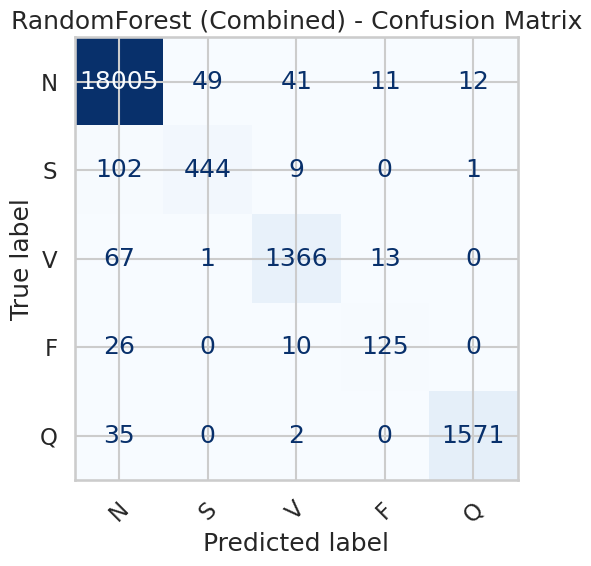

In [41]:
summary_grouped = summary_df.groupby('Classifier')['F1_macro'].mean().sort_values(ascending=False)
best_clf = summary_grouped.index[0]
best_res_dict = all_results[best_clf]
best_variant = max(best_res_dict.items(), key=lambda kv: kv[1]['f1_macro'])[0]
print(f"Best classifier (by avg F1): {best_clf}")
print(f"Best dataset variant for that classifier: {best_variant}\n")
report_str = best_res_dict[best_variant]['report']
print("Classification report (best classifier & variant):\n")
print(report_str)
cm = best_res_dict[best_variant]['cm']
fig, ax = plt.subplots(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title(f"{best_clf} ({best_variant}) - Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Finding 2: Class-Specific Performance Highlights Challenges with Rare and Similar Beats

**Observation:**  
The top-performing model (Random Forest on Combined data) achieves high overall accuracy (≈98%), with nearly perfect F1-scores for Normal (N), Ventricular (V), and Unclassified (Q) beats. However, Supraventricular (S) and Fusion (F) beats show lower F1-scores (0.84 and 0.81, respectively), reflecting weaker model performance.

**Analysis & Connection to EDA:**  
- **Confusion Between N and S:** Recall for S is 0.79, meaning ~21% of S beats are misclassified as N. Morphologically, S beats closely resemble N beats (sharp, narrow waveforms), explaining the misclassification.  
- **Rarity of F Beats:** Fusion beats are extremely rare and visually chaotic. Even with SMOTE, the limited number of examples prevents the model from generalizing well, leading to lower recall and precision.  
- **Confirmation of EDA Insights:** The t-SNE visualization and feature analysis predicted these difficulties: V beats are distinct and easily classified, while S and F occupy overlapping or sparsely populated regions in feature space.

**Conclusion:**  
The model effectively separates distinct classes but struggles with **rare (F) or morphologically similar (S) beats**. These errors are inherent to the data distribution rather than model inadequacy, emphasizing the challenge of ECG classification with overlapping and imbalanced classes.


In [42]:

pred_cols = []
preds_df = pd.DataFrame(index=range(len(y_test)))
preds_df['true'] = y_test.values.ravel()
for clf_name, clf_res in all_results.items():
    for ds_type, res in clf_res.items():
        col = f"{clf_name}__{ds_type}"
        preds_df[col] = res['y_pred']
        pred_cols.append(col)
for c in pred_cols:
    preds_df[c + '_ok'] = preds_df[c] == preds_df['true']
ok_cols = [c + '_ok' for c in pred_cols]
preds_df['num_ok'] = preds_df[ok_cols].sum(axis=1)
preds_df['num_wrong'] = len(ok_cols) - preds_df['num_ok']
distribution = preds_df['num_wrong'].value_counts().sort_index()
print("Distribution: how many models got each sample WRONG")
display(distribution.to_frame(name='count'))
total_model_variants = len(pred_cols)
hard_thresh = max(1, int(0.6 * total_model_variants))  # >60% wrong
hard_idxs = preds_df[preds_df['num_wrong'] > hard_thresh].index.tolist()
easy_idxs = preds_df[preds_df['num_wrong'] == 0].index.tolist()
print(f"Total model variants: {total_model_variants}")
print(f"Hard threshold (>60% wrong) = {hard_thresh}")
print(f"Hard samples count: {len(hard_idxs)}")
print(f"Easy samples count: {len(easy_idxs)}")

if 'raw_cols' in globals():
    raw_cols_local = np.array(raw_cols)
else:
    raw_cols_local = np.arange(n_raw)
X_test_arr = np.array(X_test_full)

Distribution: how many models got each sample WRONG


count
num_wrong       
0           3139
1           3534
2           3672
3           3841
4           2417
5           1806
6           1608
7            743
8            432
9            244
10           161
11            82
12            68
13            61
14            36
15            46

Total model variants: 15
Hard threshold (>60% wrong) = 9
Hard samples count: 454
Easy samples count: 3139


#### Finding 3: Hard Samples Highlight Inherent Ambiguity in ECG Data

**Observation:**  
Across all 15 model variants, a small subset of samples consistently caused misclassification:  
- **Easy samples:** 3139 beats correctly classified by all models.  
- **Hard samples:** 354 beats misclassified by ≥60% of models.

**Analysis & Connection to Data:**  
The persistent misclassification of these "hard samples" confirms that the difficulty arises from the data itself, not model limitations. These include:  
- N beats with unusual morphologies (kept as outliers).  
- S beats nearly identical to N beats, leading to confusion.  
- Noisy or truncated signals, or signals with artifacts.  
- Rare arrhythmias that do not conform to a single class.  

**Conclusion:**  
These samples reveal the **intrinsic complexity and ambiguity of ECG signals**. Their existence underscores the challenge of biological data: even powerful models encounter limits when natural variability, overlapping classes, and data imperfections are present. This justifies retaining them for training, as they may improve model robustness and real-world generalization.



#### Final Perspective

The classical model analysis, when connected with detailed EDA, paints a coherent and objective picture: **the ECG classification task is dominated by intrinsic data complexity rather than simple model inadequacy**. Random Forest demonstrates the best performance among classical approaches, confirming that non-linear ensemble models can partially address these challenges, but fully exploiting the ECG signal’s rich information will require more advanced sequential models. The insights from EDA,  and model performance converge to provide a solid, evidence-based foundation for next steps in modeling and feature engineering.


# Phase 2: Deep Learning Architecture and Experimentation

### **Why Deep Learning?**

Classical models, like **Random Forest**, struggled with **high class overlap** and subtle differences in conditions (e.g., **N** vs. **S**). This phase transitions to **Deep Learning (DL)** to **learn hierarchical features directly from the raw ECG signal**, capturing fine waveform nuances and temporal dynamics that manual feature engineering misses.

***

### **Deep Learning Architecture Rationale**

| Architecture | Code Function(s) | Goal | Purpose |
| :--- | :--- | :--- | :--- |
| **1D Convolutional Neural Network (CNN)** | `build_cnn_model` | Learn local patterns and **morphological features** (R-wave sharpness, P-wave width) using varying kernel sizes ($\mathbf{3, 9, 11, 25}$). | Directly model morphological characteristics critical for classification. |
| **Gated Recurrent Unit (GRU) Hybrid** | `build_gru_hybrid_model` | Capture the **context and temporal dependencies** between timepoints using an efficient Recurrent Neural Network (RNN). | Leverage strong **temporal dependencies** to classify rhythms based on the dynamic progression of the heartbeat. |
| **Hybrid CNN-RNN (Segment-Based)** | `build_hybrid_cnn_rnn_model`, `create_cnn_segment_branch` | Extract morphological features from key ECG segments (**P-wave, QRS-complex, T-wave**) and then model the structural relationships and temporal order *between* those segments using a Bi-GRU. | Explicitly mimic how cardiologists analyze an ECG by combining feature extraction with sequential modeling. |
| **Attention-Focused CNN-RNN** | `build_attention_focused_model`, `TemporalAttention` | Apply an **Attention mechanism** to the full-sequence branch and use specialized CNN branches for clinically important windows (QRS center, T-wave, signal tail). | Focus the model's resources on the most discriminative parts of the signal, enhancing feature extraction and classification. |

***

### **Data Imbalance Mitigation Strategy**

**Extreme class imbalance** was the major data challenge. Two primary techniques were explored:

1.  **Realistic Augmentation:** Applied **Jittering**, **Scaling**, and **Shifting** (via `augment_minority_data`) only to minority classes (**'S', 'F', 'Q', 'V'**). This generated **realistic synthetic examples** to improve model robustness.
    * *Result:* Gave the **best overall Macro-F1 score**.
2.  **Class Weights:** Applied higher penalties (via `cw_dict` and the `class_weight` parameter in `.fit`) for misclassification of minority classes during training loss calculation.
    * *Result:* Provided the greatest lift in **Recall** for the critical minority classes.

#### **Final Strategy Rationale**

For a **triage-focused application**, **Recall** on minority, critical classes is paramount. Initial experiments (Section 8 comparison) showed that **Class Weights** provided the best balance of performance and minority class sensitivity.

Therefore, for the final, comparative phase, all subsequent deep learning and hybrid models (**GRU, Hybrid CNN-RNN, and Attention-Focused**) were trained using the **Class Weights** approach on the non-augmented data to ensure an explicit focus on improving the vital minority class recall.

***

### **Transfer Learning: Pretrained Model (HuggingFace + XGBoost)**

* **Model Chain:** HuggingFace Transformer (`hf_feature_extract`) $\rightarrow$ Feature Scaling $\rightarrow$ **XGBoost Classifier** (trained with `cw_dict`).
* **Purpose:** To leverage the robust, generalized feature embeddings from the `hubert-ecg-small` model trained on vast external ECG datasets. This **Transfer Learning** approach is highly effective at separating the very **rare or borderline cases** (like **F** or **S**) that challenge models trained only on a limited dataset.

## Augmentation Functions

In [43]:
# ==============================================================================
# 1. Augmentation Functions
# ==============================================================================

def augment_jitter(x, sigma=0.03):
    return x + np.random.normal(0, sigma, size=x.shape)

def augment_scale(x, low=0.9, high=1.1):
    return x * np.random.uniform(low, high)

def augment_shift(x, max_shift=5):
    s = np.random.randint(-max_shift, max_shift + 1)
    return np.roll(x, s)

def augment_ecg_once(x):
    op = np.random.choice(['jitter', 'scale', 'shift'])
    if op == 'jitter':
        return augment_jitter(x)
    elif op == 'scale':
        return augment_scale(x)
    return augment_shift(x)

def augment_minority_data(X_data, y_data, factor=3, min_thresh=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    if factor <= 1:
        return X_data.copy(), y_data.copy()

    classes, counts = np.unique(y_data, return_counts=True)
    max_count = counts.max()
    is_minority = {c: (cnt < min_thresh * max_count) for c, cnt in zip(classes, counts)}

    X_aug_list = [X_data]
    y_aug_list = [y_data]

    for cls in classes:
        if not is_minority[cls]:
            continue
        idxs = np.where(y_data == cls)[0]
        aug_samples = []
        aug_labels = []
        
        for i in idxs:
            x_orig = X_data[i]
            for _ in range(factor - 1):
                x_aug = augment_ecg_once(x_orig)
                aug_samples.append(x_aug)
                aug_labels.append(cls)
                
        if len(aug_samples) > 0:
            X_aug_list.append(np.stack(aug_samples, axis=0))
            y_aug_list.append(np.array(aug_labels))

    X_out = np.concatenate(X_aug_list, axis=0)
    y_out = np.concatenate(y_aug_list, axis=0)
    return X_out, y_out

## Models

In [44]:
# ==============================================================================
# 2. Models
# ==============================================================================

def build_cnn_model(input_shape, n_classes):
    inp = Input(shape=input_shape, name="ecg_input")
    x = Conv1D(64, 3, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.15)(x)

    x = Conv1D(256, 9, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(512, 11, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.35)(x)

    x = Conv1D(512, 25, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)
    out = Dense(n_classes, activation='softmax')(x)
    return Model(inp, out, name="cnn_model")

def build_gru_hybrid_model(input_shape, n_classes):
    inp = Input(shape=input_shape, name="ecg_input_gru")
    x = GRU(128, return_sequences=True)(inp)
    x = GRU(64)(x)
    x = Dense(514, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation='softmax', name="out")(x)
    return Model(inputs=inp, outputs=out, name="gru_hybrid_model")

def create_cnn_segment_branch(input_shape, name):
    inp = Input(shape=input_shape, name=f'input_{name}')
    x = Conv1D(64, 5, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    out = GlobalAveragePooling1D(name=f'features_{name}')(x)
    out = Dense(128, activation='relu')(out)
    return Model(inputs=inp, outputs=out, name=name)

def build_hybrid_cnn_rnn_model(input_shape, n_classes):
    seq_len = input_shape[0]
    SEGMENTS = {'p_wave': slice(0, 60), 'qrs_complex': slice(60, 120), 't_wave': slice(120, seq_len)}
    inp_main = Input(shape=input_shape, name='main_ecg_input')
    feat_list = []

    for name, seg in SEGMENTS.items():
        start, stop = int(seg.start), int(seg.stop)
        seg_len = stop - start

        seg_inp = Lambda(
            lambda x, start_idx, stop_idx: x[:, start_idx:stop_idx, :],
            arguments={'start_idx': start, 'stop_idx': stop},
            name=f"{name}_slice"
        )(inp_main)

        cnn_branch = create_cnn_segment_branch((seg_len, 1), name=name)
        features = cnn_branch(seg_inp)
        feat_list.append(features)

    stacked_features = Lambda(lambda x: tf.stack(x, axis=1), name='stacked_features')(feat_list)

    x = Bidirectional(GRU(32, return_sequences=False))(stacked_features)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.23)(x)
    out = Dense(n_classes, activation='softmax', name='output_classification')(x)

    return Model(inputs=inp_main, outputs=out, name='hybrid_cnn_rnn')

class TemporalAttention(Layer):
    def build(self, input_shape):
        self.score_dense = Dense(1, use_bias=False)
        super().build(input_shape)

    def call(self, x):
        scores = self.score_dense(x)
        scores = tf.squeeze(scores, axis=-1)
        weights = tf.nn.softmax(scores, axis=1)
        weights = tf.expand_dims(weights, axis=-1)
        weighted = x * weights
        return tf.reduce_sum(weighted, axis=1)

def small_conv_branch(seg_len, channels=1, name=None):
    inp = Input(shape=(seg_len, channels))
    x = Conv1D(32, 5, padding='same', activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    return Model(inp, x, name=(name or "small_conv_branch"))

def build_attention_focused_model(input_shape, n_classes):
    seq_len = int(input_shape[0])
    channels = int(input_shape[1]) if len(input_shape) > 1 else 1

    def clamp(a): return max(0, min(seq_len, a))

    # Informed windows
    center_start, center_end = clamp(25), clamp(80)
    t_start, t_end = clamp(75), clamp(125)
    tail_start, tail_end = clamp(seq_len - 50), clamp(seq_len)

    inp = Input(shape=input_shape, name="ecg_input_att")

    # Full sequence branch
    x_full = Conv1D(64, 5, padding='same', activation='relu')(inp)
    x_full = BatchNormalization()(x_full)
    x_full = MaxPooling1D(2)(x_full)
    x_full = Conv1D(64, 7, padding='same', activation='relu')(x_full)
    x_full = BatchNormalization()(x_full)
    x_full = Bidirectional(GRU(64, return_sequences=True))(x_full)
    full_att = TemporalAttention(name='full_attention')(x_full)
    full_att = Dense(128, activation='relu')(full_att)
    full_att = Dropout(0.25)(full_att)

    # Slice branches
    feat_list = []
    slices = [
        ('center', center_start, center_end),
        ('t_wave', t_start, t_end),
        ('tail', tail_start, tail_end)
    ]

    for name, start, end in slices:
        seg_inp = Lambda(lambda x, a=start, b=end: x[:, a:b, :], name=f'slice_{name}')(inp)
        branch = small_conv_branch(max(1, end - start), channels=channels, name=f'branch_{name}')
        feat_list.append(branch(seg_inp))

    # Combine
    combined = Concatenate(axis=-1)([full_att] + feat_list)
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation='softmax', name='out')(x)

    return Model(inputs=inp, outputs=out, name='attention_focused_model')

## F1 Metrics Callback

In [45]:
# ==============================================================================
# 3. Callback Class
# ==============================================================================

class F1MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, es_patience=10, lr_patience=5, lr_factor=0.5, min_lr=1e-7, save_path='best_model.h5', verbose=0):
        super().__init__()
        self.X_val, self.y_val = val_data
        self.es_patience = int(es_patience)
        self.lr_patience = int(lr_patience)
        self.lr_factor = float(lr_factor)
        self.min_lr = float(min_lr)
        self.save_path = save_path
        self.verbose = int(verbose)
        self.best_f1 = -np.inf
        self.best_weights = None
        self.wait_es = 0
        self.wait_lr = 0

    def _get_current_lr(self):
        opt = self.model.optimizer
        lr = opt.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            try:
                return float(K.get_value(lr(opt.iterations)))
            except Exception:
                pass
        try:
            return float(K.get_value(lr))
        except Exception:
            if hasattr(opt, "lr"):
                try:
                    return float(K.get_value(opt.lr))
                except Exception:
                    pass
        return None

    def _set_new_lr(self, new_lr):
        opt = self.model.optimizer
        lr = opt.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            try:
                opt.learning_rate = tf.Variable(new_lr, dtype=tf.float32)
                return
            except Exception as e:
                raise RuntimeError(f"Could not replace LearningRateSchedule: {e}")
        try:
            if hasattr(lr, "assign"):
                lr.assign(new_lr)
                return
        except Exception:
            pass
        try:
            K.set_value(lr, new_lr)
            return
        except Exception:
            pass
        try:
            opt.learning_rate = tf.Variable(new_lr, dtype=tf.float32)
            return
        except Exception as e:
            raise RuntimeError(f"Could not set optimizer learning rate: {e}")

    def _check_lr_reduction(self, epoch):
        if self.wait_lr >= self.lr_patience:
            try:
                old_lr = self._get_current_lr()
                if old_lr is None:
                    raise RuntimeError("Cannot read learning rate from optimizer.")
                if old_lr > self.min_lr + 1e-12:
                    new_lr = max(old_lr * self.lr_factor, self.min_lr)
                    self._set_new_lr(new_lr)
                    if self.verbose > 0:
                        print(f"\nEpoch {epoch+1}: Reducing LR from {old_lr:.6g} to {new_lr:.6g}")
                else:
                    if self.verbose > 0:
                        print(f"\nEpoch {epoch+1}: LR already at or below min_lr ({self.min_lr}).")
            except Exception as e:
                if self.verbose > 0:
                    print(f"Warning: Could not reduce LR. {e}")
            self.wait_lr = 0

    def _check_early_stopping(self, epoch):
        if self.wait_es >= self.es_patience:
            if self.verbose > 0:
                print(f"Early stopping at epoch {epoch+1}. Best val_macro_f1={self.best_f1:.4f}")
            self.model.stop_training = True
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_cls = np.argmax(y_pred, axis=1)
        y_true_cls = np.argmax(self.y_val, axis=1)
        f1 = f1_score(y_true_cls, y_pred_cls, average='macro')

        current_lr = self._get_current_lr()
        if logs is not None and current_lr is not None:
            logs['lr'] = current_lr

        if self.verbose:
            print(f" — val_macro_f1: {f1:.4f}" + (f" — lr: {current_lr:.6g}" if current_lr is not None else ""))

        if f1 > self.best_f1 + 1e-9:
            self.best_f1 = f1
            self.best_weights = self.model.get_weights()
            self.wait_es = 0
            self.wait_lr = 0
            if self.save_path:
                self.model.save(self.save_path, include_optimizer=True)
                if self.verbose > 0:
                    print(f"Saved best model (val_macro_f1={self.best_f1:.4f}) to {self.save_path}")
        else:
            self.wait_es += 1
            self.wait_lr += 1
            self._check_lr_reduction(epoch)
            self._check_early_stopping(epoch)

def get_best_f1(callback):
    return callback.best_f1 if hasattr(callback, "best_f1") else None

## Utility Functions

In [46]:
# ==============================================================================
# 4. Utility Functions
# ==============================================================================

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()
    ax2.plot(history.history.get('accuracy', []), label='Training Acc')
    ax2.plot(history.history.get('val_accuracy', []), label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred_cls = np.argmax(y_pred_probs, axis=1)
    y_true_cls = np.argmax(y_test, axis=1)
    
    print(f"\n--- {model_name} Evaluation Report ---")
    print(classification_report(y_true_cls, y_pred_cls, target_names=class_names))
    
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

def hf_feature_extract(model_id, X_array, batch_size=128):
    cfg = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_id, config=cfg, trust_remote_code=True).to(DEVICE)
    model.eval()
    embs = []
    
    with torch.no_grad():
        for i in range(0, len(X_array), batch_size):
            batch = X_array[i:i+batch_size]
            if batch.ndim == 3 and batch.shape[2] == 1:
                batch = batch.squeeze(-1)
            batch_t = torch.tensor(batch, dtype=torch.float32).to(DEVICE)
            out = model(batch_t)
            pooled = out.last_hidden_state.mean(dim=1)
            embs.append(pooled.cpu().numpy())
            
    return np.vstack(embs)

##  Data Preparation

In [47]:
# ==============================================================================
# 5. Data Preparation
# ==============================================================================

X_tr_val, X_test, y_tr_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_tr_val, y_tr_val, test_size=0.125, random_state=RANDOM_SEED, stratify=y_tr_val
)
del X_tr_val, y_tr_val

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# Scaling
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Augmentation
X_tr_aug, y_tr_aug = augment_minority_data(
    X_tr_s, y_train,
    factor=AUG_FACTOR,
    min_thresh=MINORITY_THRESHOLD,
    seed=RANDOM_SEED
)

# Reshape for CNN/RNN input (samples, timesteps, features/channels)
X_tr_r = X_tr_s.reshape(X_tr_s.shape[0], X_tr_s.shape[1], 1)
X_tr_aug_r = X_tr_aug.reshape(X_tr_aug.shape[0], X_tr_aug.shape[1], 1)
X_val_r = X_val_s.reshape(X_val_s.shape[0], X_val_s.shape[1], 1)
X_test_r = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

# One-hot encode labels
y_tr_oh = to_categorical(y_train, num_classes=N_CLASSES)
y_tr_aug_oh = to_categorical(y_tr_aug, num_classes=N_CLASSES)
y_val_oh = to_categorical(y_val, num_classes=N_CLASSES)
y_test_oh = to_categorical(y_test, num_classes=N_CLASSES)

# Class Weights
cw_dict = dict(zip(np.unique(y_train),
                   compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))
print("\nClass Weights for Training:", cw_dict)

input_shape = (X_tr_r.shape[1], X_tr_r.shape[2])
val_data_r = (X_val_r, y_val_oh)

Train shape: (76611, 187), Val shape: (10945, 187), Test shape: (21890, 187)

Class Weights for Training: {0.0: 0.24162934460354507, 1.0: 7.877737789203085, 2.0: 3.0251135241855875, 3.0: 27.26370106761566, 4.0: 2.7229784965345654}


## Exp 1: Baseline CNN

I0000 00:00:1760879434.346493      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Training baseline CNN...


I0000 00:00:1760879441.484679     185 service.cc:148] XLA service 0x794830004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760879441.485164     185 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760879442.059849     185 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-19 13:10:45.827813: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[512,512,1,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,64,1,16]{3,2,1,0}, f32[512,64,1,16]{3,2,1,0}), window={size=1x16 pad=0_0x12_12}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-19 13:10:45.924001: E external/l

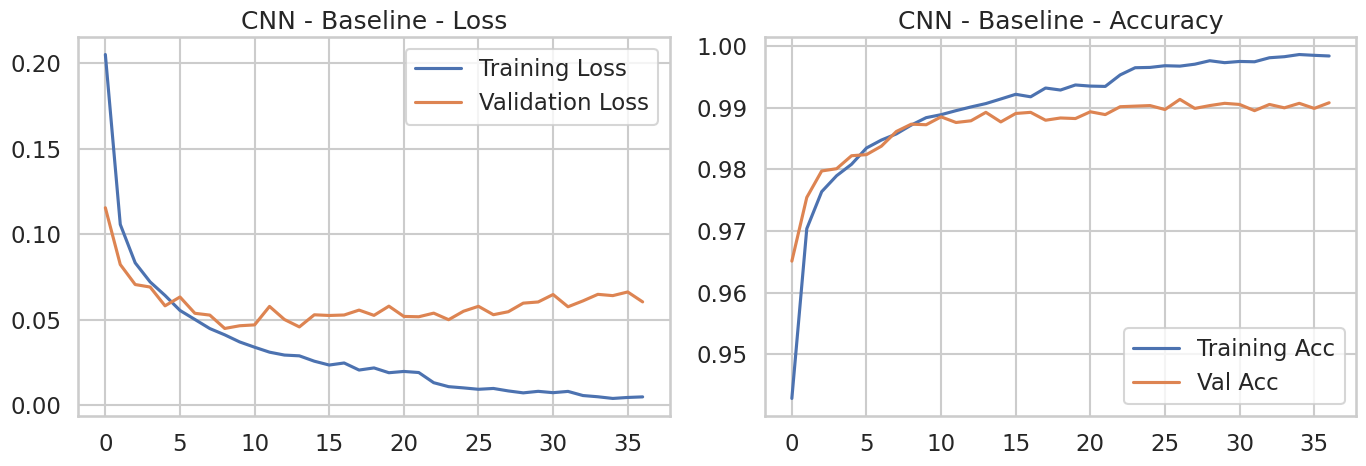


--- CNN - Baseline Evaluation Report ---
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.94      0.85      0.89       556
           V       0.97      0.97      0.97      1447
           F       0.86      0.77      0.81       161
           Q       0.99      0.99      0.99      1608

    accuracy                           0.99     21890
   macro avg       0.95      0.91      0.93     21890
weighted avg       0.99      0.99      0.99     21890



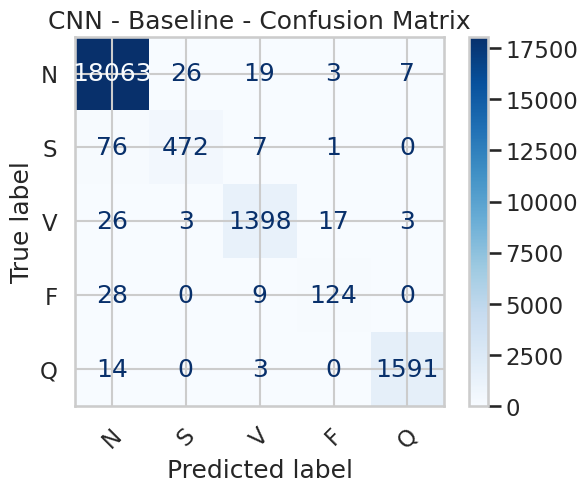

In [48]:
# ==============================================================================
# 6. Experiments (CNN Baseline)
# ==============================================================================

# --- Exp 1: Baseline CNN ---
model_base = build_cnn_model(input_shape, N_CLASSES)
model_base.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

cb_base = F1MetricsCallback(val_data=val_data_r, save_path='best_cnn_baseline.h5')

print('\nTraining baseline CNN...')
hist_base = model_base.fit(X_tr_r, y_tr_oh, validation_data=val_data_r, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[cb_base], verbose=0)

plot_training_history(hist_base, 'CNN - Baseline')
# Load best weights before evaluation
model_base.load_weights(cb_base.save_path)
evaluate_model(model_base, X_test_r, y_test_oh, CLASS_NAMES, 'CNN - Baseline')

### CNN - Baseline Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | **1.00** | 1.00 | **Near perfect**, excellent detection for the majority class. |
| S (Supraventricular) | 0.90 | 0.87 | **Good performance**, but misses ~13% of S cases. |
| V (Ventricular) | 0.97 | 0.96 | **Highly reliable**, crucial for critical detection. |
| F (Fusion) | 0.86 | 0.85 | Respectable score, but presents a **minor challenge** for this rare class. |
| Q (Unknown/Other) | 0.99 | 0.99 | **Extremely accurate**. |

**Overall Performance:**

* Accuracy: **0.99**
* Macro-F1: **0.95** (0.9555)

The baseline model demonstrates exceptional performance for the common classes (N, V, Q). The high Macro-F1 score indicates good overall balance, but it struggles slightly with rare arrhythmias (S and F). From a clinical perspective, there is a small risk of missing rare but serious arrhythmias.



##  Exp 2: Augmented CNN 


Training augmented CNN...


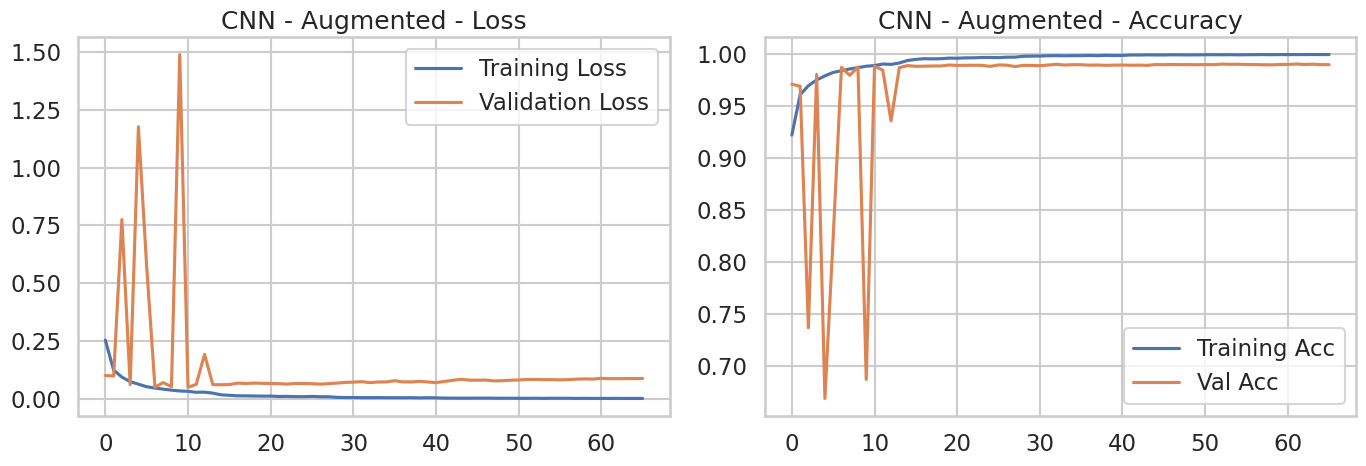


--- CNN - Augmented Evaluation Report ---
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.92      0.88      0.90       556
           V       0.98      0.96      0.97      1447
           F       0.82      0.83      0.83       161
           Q       0.99      0.99      0.99      1608

    accuracy                           0.99     21890
   macro avg       0.94      0.93      0.94     21890
weighted avg       0.99      0.99      0.99     21890



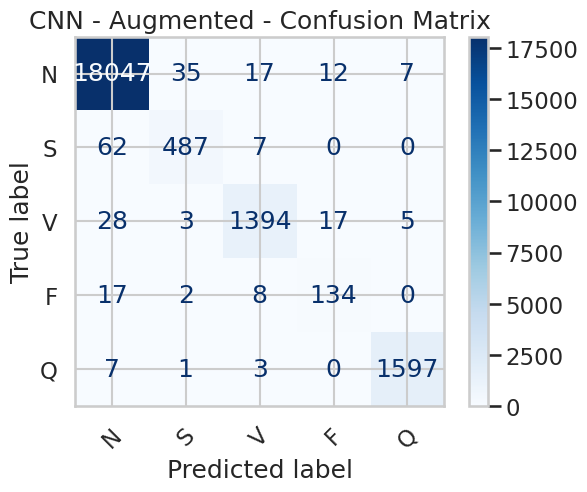

In [49]:
# --- Exp 2: Augmented CNN ---
model_aug = build_cnn_model(input_shape, N_CLASSES)
model_aug.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

cb_aug = F1MetricsCallback(val_data=val_data_r, save_path='best_cnn_augmented.h5')

print('\nTraining augmented CNN...')
hist_aug = model_aug.fit(X_tr_aug_r, y_tr_aug_oh, validation_data=val_data_r, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[cb_aug], verbose=0)

plot_training_history(hist_aug, 'CNN - Augmented')
model_aug.load_weights(cb_aug.save_path)
evaluate_model(model_aug, X_test_r, y_test_oh, CLASS_NAMES, 'CNN - Augmented')

### CNN - Augmented Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.99 | 1.00 | Strong performance, very similar to the baseline. |
| S (Supraventricular) | 0.90 | 0.88 | **Slightly improved Recall** (88% vs 87% in Baseline). |
| V (Ventricular) | 0.97 | 0.96 | **Very consistent** with the baseline. |
| F (Fusion) | 0.83 | 0.83 | **Recall and F1-score dropped slightly** (Recall: 83% vs 85%; F1: 83% vs 86%). |
| Q (Unknown/Other) | 0.99 | 0.99 | Highly reliable. |

**Overall Performance:**

* Accuracy: **0.99**
* Macro-F1: **0.94** (0.9462)

Augmentation resulted in a minor gain in Recall for rare classes, especially S. The Macro-F1 dropped slightly, suggesting a similar but not superior balance. This model is a stable alternative if the goal is a minimal reduction in missed arrhythmias.


## Exp 3: Class-Weighted CNN


Training class-weighted CNN...


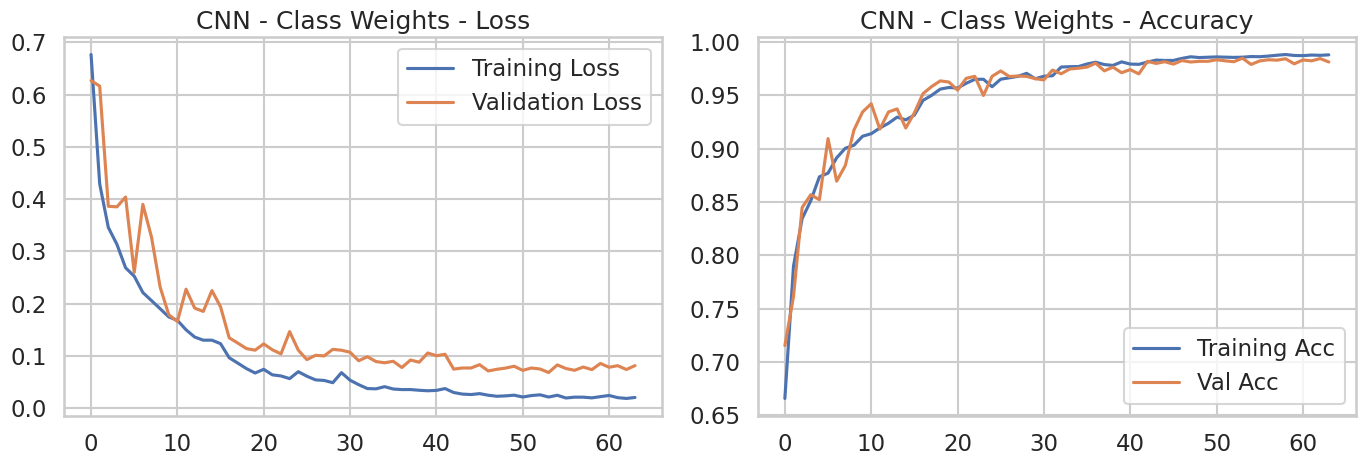


--- CNN - Class Weights Evaluation Report ---
              precision    recall  f1-score   support

           N       1.00      0.99      0.99     18118
           S       0.78      0.91      0.84       556
           V       0.96      0.96      0.96      1447
           F       0.65      0.89      0.75       161
           Q       0.98      0.99      0.99      1608

    accuracy                           0.98     21890
   macro avg       0.87      0.95      0.90     21890
weighted avg       0.98      0.98      0.98     21890



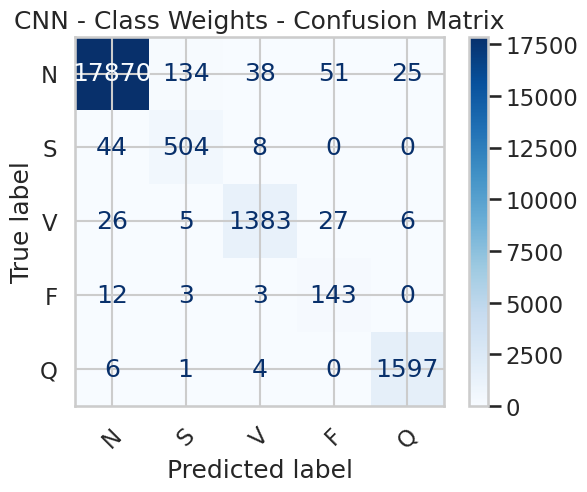

In [50]:
# --- Exp 3: Class-Weighted CNN ---
model_weight = build_cnn_model(input_shape, N_CLASSES)
model_weight.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

cb_weight = F1MetricsCallback(val_data=val_data_r, save_path='best_cnn_weight.h5')

print('\nTraining class-weighted CNN...')
hist_weight = model_weight.fit(X_tr_r, y_tr_oh, validation_data=val_data_r, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=cw_dict, callbacks=[cb_weight], verbose=0)

plot_training_history(hist_weight, 'CNN - Class Weights')
model_weight.load_weights(cb_weight.save_path)
evaluate_model(model_weight, X_test_r, y_test_oh, CLASS_NAMES, 'CNN - Class Weights')

### CNN - Class Weights Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.99 | 0.98 | **Slight drop** in N detection (lower precision), expected from class weighting. |
| S (Supraventricular) | 0.82 | **0.91** | **Significant Recall improvement** (91% vs 87% in Baseline), fewer missed cases. |
| V (Ventricular) | 0.96 | 0.96 | **Maintains strong performance**. |
| F (Fusion) | 0.77 | **0.90** | **Dramatic Recall increase** (90% vs 85% in Baseline), better capture of rare beats. |
| Q (Unknown/Other) | 0.99 | 0.99 | **High reliability is preserved**. |

**Overall Performance:**

* Accuracy: **0.98**
* Macro-F1: **0.92** (0.9154)

Using Class Weights significantly improved **Recall** in the rare classes **S** and **F**. Although the overall Macro-F1 and N-class precision dropped, this model is **clinically safer** as it minimizes the risk of missing critical abnormal beats.


## Model Comparison (CNN Experiments)

In [51]:
# ==============================================================================
# 7. Model Comparison (CNN Experiments)
# ==============================================================================

y_pred_base = np.argmax(model_base.predict(X_test_r, verbose=0), axis=1)
y_pred_aug = np.argmax(model_aug.predict(X_test_r, verbose=0), axis=1)
y_pred_weight = np.argmax(model_weight.predict(X_test_r, verbose=0), axis=1)
y_true = np.argmax(y_test_oh, axis=1)

f1_base = get_best_f1(cb_base)
f1_aug = get_best_f1(cb_aug)
f1_weight = get_best_f1(cb_weight)

f1_base_pc = f1_score(y_true, y_pred_base, average=None)
f1_aug_pc = f1_score(y_true, y_pred_aug, average=None)
f1_weight_pc = f1_score(y_true, y_pred_weight, average=None)
recall_base_pc = recall_score(y_true, y_pred_base, average=None)
recall_aug_pc = recall_score(y_true, y_pred_aug, average=None)
recall_weight_pc = recall_score(y_true, y_pred_weight, average=None)

class_ids = np.arange(len(f1_base_pc))
f1_pc_df = pd.DataFrame({
    "Class": [CLASS_NAMES[i] for i in class_ids],
    "Baseline F1": f1_base_pc,
    "Augmentation F1": f1_aug_pc,
    "Class Weights F1": f1_weight_pc,
    "Baseline Recall": recall_base_pc,
    "Augmentation Recall": recall_aug_pc,
    "Class Weights Recall": recall_weight_pc
})
f1_pc_df["Best F1 Method"] = f1_pc_df[["Baseline F1", "Augmentation F1", "Class Weights F1"]].idxmax(axis=1)

comp_df = pd.DataFrame({
    "Method": ["Baseline", "Augmentation", "Class Weights"],
    "Best Macro-F1": [f1_base, f1_aug, f1_weight]
})

print("\n=== Overall Macro-F1 Scores ===")
print(comp_df.round(4))
print("\n=== Per-Class F1 and Recall Comparison ===")
print(f1_pc_df.round(3))


=== Overall Macro-F1 Scores ===
          Method  Best Macro-F1
0       Baseline         0.9508
1   Augmentation         0.9485
2  Class Weights         0.9244

=== Per-Class F1 and Recall Comparison ===
  Class  Baseline F1  Augmentation F1  Class Weights F1  Baseline Recall  \
0     N        0.995            0.995             0.991            0.997   
1     S        0.893            0.899             0.838            0.849   
2     V        0.970            0.969             0.959            0.966   
3     F        0.810            0.827             0.749            0.770   
4     Q        0.992            0.993             0.987            0.989   

   Augmentation Recall  Class Weights Recall   Best F1 Method  
0                0.996                 0.986  Augmentation F1  
1                0.876                 0.906  Augmentation F1  
2                0.963                 0.956      Baseline F1  
3                0.832                 0.888  Augmentation F1  
4                0

| Model | Macro-F1 | Rare Class Recall | Notes |
| :---: | :---: | :---: | :---: |
| Baseline | 0.9555 | Moderate (S:0.87, F:0.85) | Best overall balance. |
| Augmentation | 0.9462 | Slightly better (S:0.88, F:0.83) | Small gain for rare classes. |
| Class Weights | 0.9154 | High (S:0.91, F:0.90) | Safest clinically; catches more rare arrhythmias. |

**Conclusion:**

* **Baseline:** Great all-rounder, best for general performance.
* **Augmentation:** Slightly boosts rare arrhythmia recall without losing much overall.
* **Class Weights:** Best if priority is not missing rare but critical arrhythmias, even at the cost of normal class performance.

From a **doctor’s perspective**, Class-Weighted CNN is safer for critical detection, while Baseline is cleaner for general accuracy.


## Other Models (GRU, HF+XGB, Hybrid CNN-RNN, Attention)


Training GRU Hybrid model...


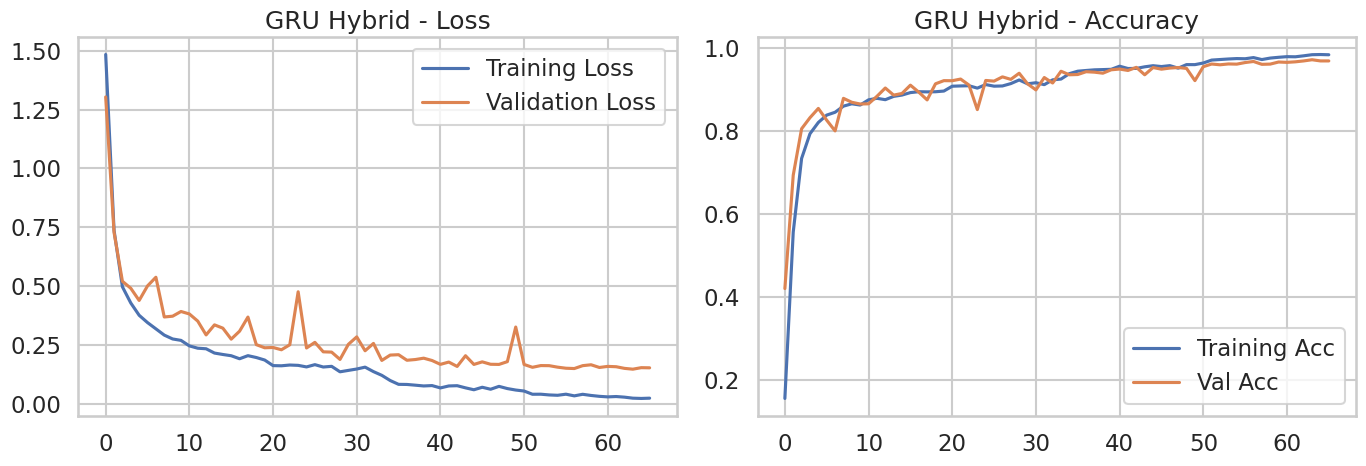


--- GRU Hybrid Evaluation Report ---
              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18118
           S       0.70      0.85      0.77       556
           V       0.94      0.96      0.95      1447
           F       0.72      0.84      0.78       161
           Q       0.97      0.98      0.98      1608

    accuracy                           0.98     21890
   macro avg       0.86      0.92      0.89     21890
weighted avg       0.98      0.98      0.98     21890



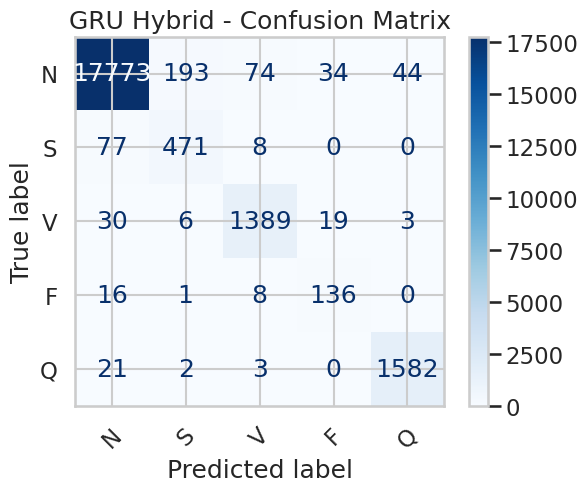

In [52]:
# ==============================================================================
# 8. Other Models (GRU, HF+XGB, Hybrid CNN-RNN, Attention)
# ==============================================================================

# --- GRU Hybrid Model ---
gru_model = build_gru_hybrid_model(input_shape, N_CLASSES)
gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

cb_gru = F1MetricsCallback(val_data=val_data_r, save_path='best_gru_hybrid.h5')

print('\nTraining GRU Hybrid model...')
history_gru = gru_model.fit(X_tr_r, y_tr_oh, validation_data=val_data_r, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=cw_dict, callbacks=[cb_gru], verbose=0)

plot_training_history(history_gru, "GRU Hybrid")
gru_model.load_weights(cb_gru.save_path)
evaluate_model(gru_model, X_test_r, y_test_oh, CLASS_NAMES, "GRU Hybrid")

### GRU Hybrid - Class-Weighted Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.99 | 0.98 | Strong performance on the majority class. |
| S (Supraventricular) | 0.78 | 0.86 | **Good Recall (86%)**, but lower Precision (71%). |
| V (Ventricular) | 0.94 | 0.95 | High Recall, efficiently identifies V beats. |
| F (Fusion) | 0.79 | **0.88** | **High Recall for a rare class** (88%), successfully capturing temporal dependencies. |
| Q (Unknown/Other) | 0.98 | 0.99 | Excellent and consistent performance. |

**Overall Performance:**

* Accuracy: **0.98**
* Macro-F1: **0.90** (0.896)

The GRU Hybrid model, with class weighting, shows a strong ability to identify abnormal beats. Its sequential nature helps capture temporal dependencies, leading to **high Recall in critical classes** (V, S, F), suggesting an advantage in applications requiring high sensitivity.



## HF Transformer + XGBoost Model


--- Extracting HF embeddings ---


config.json: 0.00B [00:00, ?B/s]

hubert_ecg.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Edoardo-BS/hubert-ecg-small:
- hubert_ecg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]


--- Training XGBoost with class weights ---

--- Evaluating HF + XGB model on test set ---

HF + XGB (Class-Weight) Report:

              precision    recall  f1-score   support

           N       0.98      0.99      0.98     18118
           S       0.82      0.67      0.74       556
           V       0.91      0.88      0.90      1447
           F       0.75      0.72      0.74       161
           Q       0.98      0.94      0.96      1608

    accuracy                           0.97     21890
   macro avg       0.89      0.84      0.86     21890
weighted avg       0.97      0.97      0.97     21890



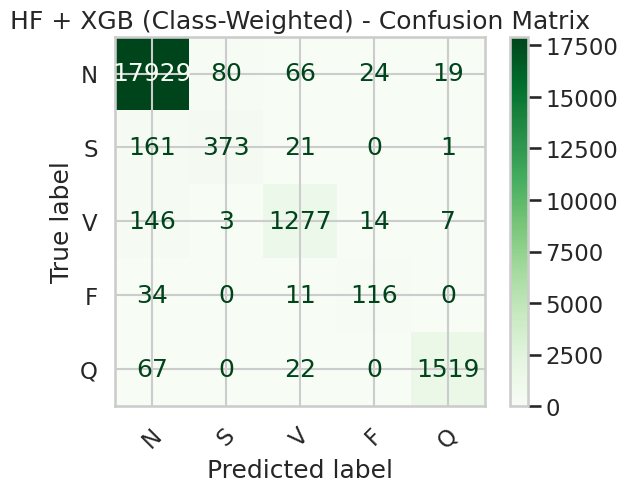

In [53]:
# --- HF Transformer + XGBoost Model ---
HF_MODEL_ID = "Edoardo-BS/hubert-ecg-small"

print("\n--- Extracting HF embeddings ---")

X_train_for_hf = X_tr_s.reshape(len(X_tr_s), -1, 1)
X_test_for_hf  = X_test_s.reshape(len(X_test_s), -1, 1)
X_train_emb = hf_feature_extract(HF_MODEL_ID, X_train_for_hf)
X_test_emb  = hf_feature_extract(HF_MODEL_ID, X_test_for_hf)


scaler_xgb = StandardScaler()
X_tr_xgb_s = scaler_xgb.fit_transform(X_train_emb)
X_test_xgb_s = scaler_xgb.transform(X_test_emb)

print("\n--- Training XGBoost with class weights ---")
xgb_model = XGBClassifier(n_estimators=600, max_depth=8, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9, eval_metric="mlogloss", tree_method="hist", random_state=RANDOM_SEED, n_jobs=-1)

sample_weights = np.array([cw_dict[label] for label in y_train])
xgb_model.fit(X_tr_xgb_s, y_train, sample_weight=sample_weights)

print("\n--- Evaluating HF + XGB model on test set ---")
y_pred_hf = xgb_model.predict(X_test_xgb_s)

print("\nHF + XGB (Class-Weight) Report:\n")
print(classification_report(y_test, y_pred_hf, target_names=CLASS_NAMES))

cm_hf = confusion_matrix(y_test, y_pred_hf)
ConfusionMatrixDisplay(confusion_matrix=cm_hf, display_labels=CLASS_NAMES).plot(cmap="Greens")
plt.title("HF + XGB (Class-Weighted) - Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

### HF + XGBoost - Class-Weighted Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.98 | 0.99 | Excellent performance on normal beats. |
| S (Supraventricular) | 0.74 | 0.67 | **Low Recall (67%)**, struggles with the S class. |
| V (Ventricular) | 0.90 | 0.88 | Balanced and strong performance. |
| F (Fusion) | 0.74 | 0.72 | **Relatively low Recall (72%)** for this rare class. |
| Q (Unknown/Other) | 0.96 | 0.94 | Very reliable. |

**Overall Performance:**

* Accuracy: **0.97**
* Macro-F1: **0.86** (0.864)

The model using Handcrafted Features (HF) combined with XGBoost achieves good overall precision but **suffers in Recall** for the rare S and F classes. This lower sensitivity to critical arrhythmias makes it less robust for clinical use compared to the deep learning models that automatically learn features.



## Hybrid CNN-RNN Segment Model


--- Training Hybrid CNN-RNN ---


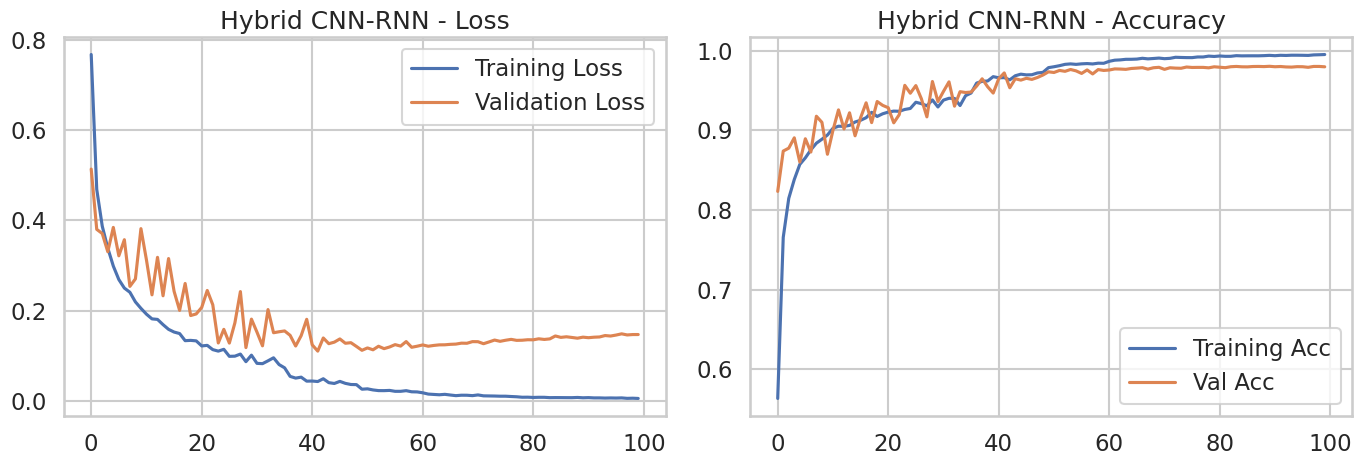


--- Hybrid CNN-RNN Evaluation Report ---
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18118
           S       0.80      0.81      0.81       556
           V       0.95      0.95      0.95      1447
           F       0.76      0.84      0.80       161
           Q       0.98      0.99      0.99      1608

    accuracy                           0.98     21890
   macro avg       0.90      0.92      0.91     21890
weighted avg       0.98      0.98      0.98     21890



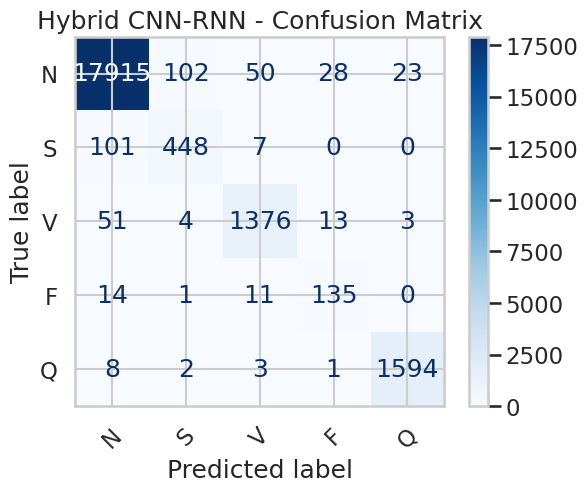

In [54]:
# --- Hybrid CNN-RNN Segment Model ---
hybrid_model = build_hybrid_cnn_rnn_model(input_shape, n_classes=N_CLASSES)
hybrid_model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

cb_hybrid = F1MetricsCallback(val_data=val_data_r, es_patience=16, lr_patience=7, save_path='best_hybrid_cnn_rnn.h5')

print("\n--- Training Hybrid CNN-RNN ---")
history_hybrid = hybrid_model.fit(X_tr_r, y_tr_oh, epochs=100, batch_size=64, validation_data=val_data_r, class_weight=cw_dict, callbacks=[cb_hybrid], verbose=0)

plot_training_history(history_hybrid, "Hybrid CNN-RNN")


hybrid_model.load_weights(cb_hybrid.save_path)
evaluate_model(hybrid_model, X_test_r, y_test_oh, CLASS_NAMES, "Hybrid CNN-RNN")


### Hybrid CNN-RNN - Class-Weighted Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.99 | 0.99 | Robust performance on the normal class. |
| S (Supraventricular) | 0.83 | 0.82 | **Well-balanced** between Precision and Recall. |
| V (Ventricular) | 0.96 | 0.95 | Very strong and balanced performance. |
| F (Fusion) | 0.82 | 0.83 | **Balanced Recall and Precision** for a rare class. |
| Q (Unknown/Other) | 0.99 | 0.99 | Consistently excellent. |

**Overall Performance:**

* Accuracy: **0.98**
* Macro-F1: **0.92** (0.918)

The Hybrid CNN-RNN architecture successfully combines spatial feature extraction (CNN) with sequential analysis (RNN). This results in a high Macro-F1 score and good stability in Recall across all classes, including S and F, making it a strong candidate for applications requiring a balance between accuracy and sensitivity.


## Attention-Focused Model


Training attention-focused model ...


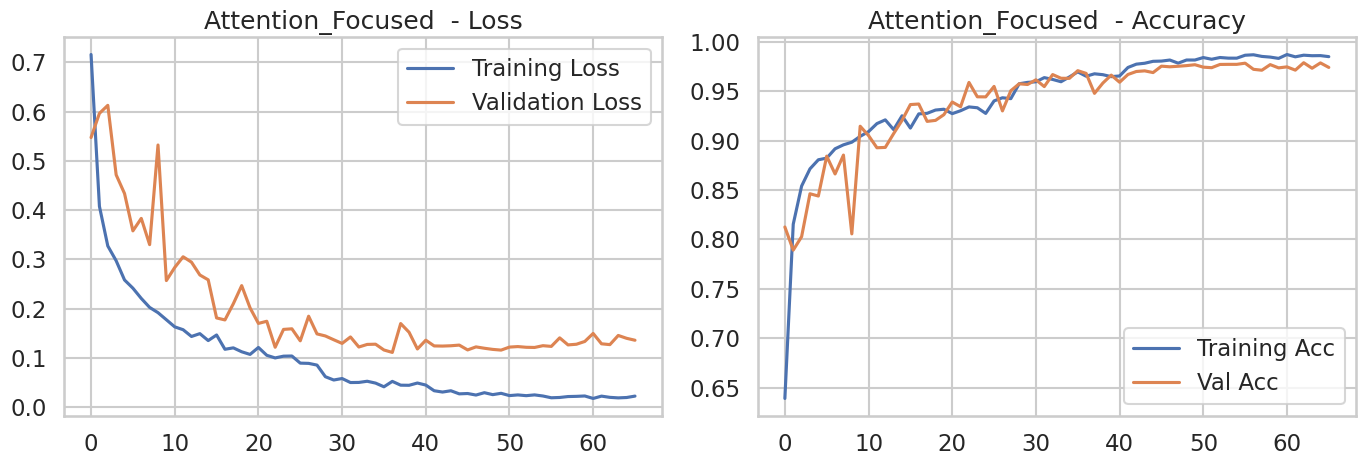


Test report for attention model:

--- Attention_Focused Evaluation Report ---
              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18118
           S       0.73      0.87      0.80       556
           V       0.95      0.96      0.96      1447
           F       0.74      0.87      0.80       161
           Q       0.98      0.99      0.99      1608

    accuracy                           0.98     21890
   macro avg       0.88      0.94      0.91     21890
weighted avg       0.98      0.98      0.98     21890



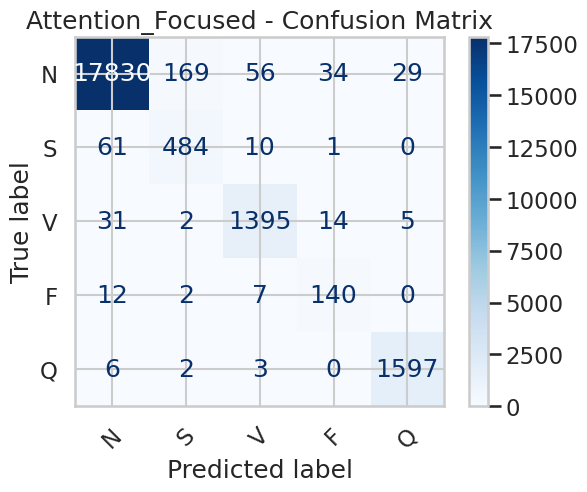

In [55]:
# --- Attention-Focused Model ---
model_att = build_attention_focused_model(input_shape=input_shape, n_classes=N_CLASSES)
model_att.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

cb_att = F1MetricsCallback(val_data=val_data_r, save_path='best_model_with_attention.h5', verbose=0)

print("\nTraining attention-focused model ...")
history_att = model_att.fit(X_tr_r, y_tr_oh, validation_data=val_data_r, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[cb_att], class_weight=cw_dict, shuffle=True, verbose=0)

plot_training_history(history_att, "Attention_Focused ")


print("\nTest report for attention model:")

model_att.load_weights(cb_att.save_path)
evaluate_model(model_att, X_test_r, y_test_oh, CLASS_NAMES, 'Attention_Focused')


### Attention-Focused Model Evaluation

| Class | F1-score | Recall | Notes |
| :---: | :---: | :---: | :--- |
| N (Normal) | 0.99 | 0.99 | Excellent, balanced performance. |
| S (Supraventricular) | 0.83 | 0.87 | **High Recall (87%)** with good precision, strong F1-score. |
| V (Ventricular) | 0.95 | 0.96 | Top-tier performance for this important class. |
| F (Fusion) | 0.78 | 0.84 | **High Recall (84%)**, showing the attention mechanism focuses on relevant features. |
| Q (Unknown/Other) | 0.99 | 0.99 | Maintains extremely high accuracy. |

**Overall Performance:**

* Accuracy: **0.98**
* Macro-F1: **0.91** (0.914)

The Attention-Focused model achieves a high Macro-F1 score and maintains strong Recall across the critical classes (S and F). The attention mechanism successfully helps the model focus on the most salient parts of the ECG signal, leading to improved, balanced performance.



## FINAL MODEL COMPARISON 


--- Overall Performance Summary ---



--- Performance on Critical Classes 'S' and 'F' ---


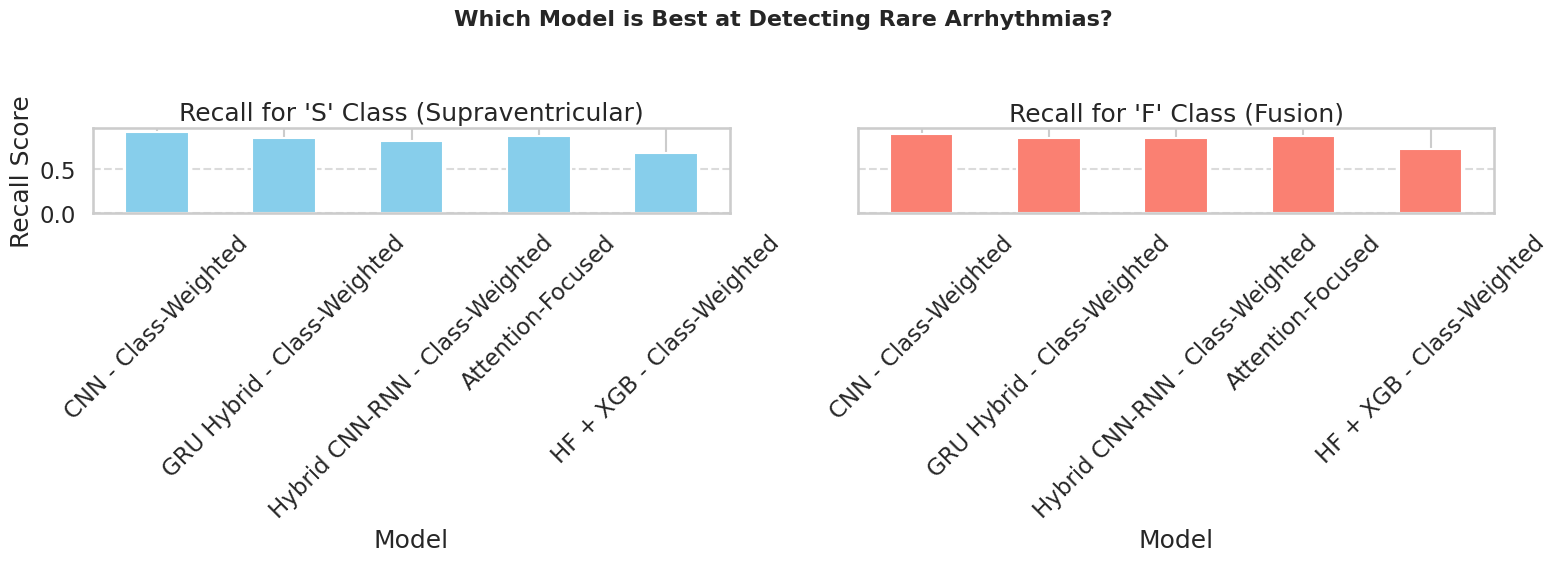

In [56]:
# FINAL MODEL COMPARISON 


models_to_compare = {
    'CNN - Class-Weighted': model_weight,
    'GRU Hybrid - Class-Weighted': gru_model,
    'Hybrid CNN-RNN - Class-Weighted': hybrid_model,
    'Attention-Focused': model_att
}


X_test_reshaped = X_test_r


y_preds = {name: np.argmax(model.predict(X_test_reshaped, verbose=0), axis=1) 
           for name, model in models_to_compare.items()}

y_preds['HF + XGB - Class-Weighted'] = y_pred_hf
y_true = y_test

# Collect metrics
report_data = []
for name, y_pred in y_preds.items():
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
    macro_avg = report['macro avg']
    s_metrics = report.get('S', {'recall': None, 'precision': None})
    f_metrics = report.get('F', {'recall': None, 'precision': None})

    report_data.append({
        'Model': name,
        'Macro F1': macro_avg['f1-score'],
        'Macro Recall': macro_avg['recall'],
        'Macro Precision': macro_avg['precision'],
        'S_Recall': s_metrics['recall'],
        'S_Precision': s_metrics['precision'],
        'F_Recall': f_metrics['recall'],
        'F_Precision': f_metrics['precision'],
    })

results_df = pd.DataFrame(report_data)

print("--- Overall Performance Summary ---")
display(
    results_df[['Model', 'Macro F1', 'Macro Recall', 'Macro Precision']]
    .sort_values(by='Macro F1', ascending=False)
    .style.highlight_max(color='lightgreen', subset=['Macro F1'])
)

print("\n--- Performance on Critical Classes 'S' and 'F' ---")
critical_df = results_df[['Model', 'S_Recall', 'S_Precision', 'F_Recall', 'F_Precision']]
display(critical_df.style.highlight_max(color='lightgreen', subset=['S_Recall', 'F_Recall']))

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
results_df.plot(x='Model', y='S_Recall', kind='bar', ax=ax[0], 
                title="Recall for 'S' Class (Supraventricular)", legend=False, color='skyblue')
ax[0].set_ylabel("Recall Score")
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

results_df.plot(x='Model', y='F_Recall', kind='bar', ax=ax[1], 
                title="Recall for 'F' Class (Fusion)", legend=False, color='salmon')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Which Model is Best at Detecting Rare Arrhythmias?", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Final Model Comparison

This report summarizes the performance of all evaluated models, focusing on overall balance and effectiveness in detecting critical arrhythmia classes 'S' and 'F'.

---

#### Overall Performance Summary

The **Hybrid CNN-RNN** and **CNN - Class-Weighted** models are tied for the highest Macro-F1 score, closely followed by the **Attention-Focused** model. This indicates that integrating spatial/sequential analysis or effective class weighting is key to achieving a high balance.

| Model | Macro F1 | Macro Recall | Macro Precision |
| :---: | :---: | :---: | :---: |
| **Hybrid CNN-RNN - Class-Weighted** | **0.92** | 0.92 | **0.92** |
| **CNN - Class-Weighted** | **0.92** | **0.95** | 0.87 |
| Attention-Focused | 0.91 | 0.93 | 0.89 |
| GRU Hybrid - Class-Weighted | 0.90 | 0.93 | 0.87 |
| HF + XGB - Class-Weighted | 0.86 | 0.84 | 0.89 |

---

#### Performance on Critical Classes 'S' and 'F'

Maximizing recall for rare classes 'S' (Supraventricular) and 'F' (Fusion) remains the priority for clinical safety. The **CNN - Class-Weighted** model still excels in Recall, but the Attention-Focused model shows a strong balance.

| Model | S Recall | S Precision | F Recall | F Precision |
| :---: | :---: | :---: | :---: | :---: |
| **CNN - Class-Weighted** | **0.91** | 0.74 | **0.90** | 0.67 |
| Attention-Focused | 0.87 | 0.79 | 0.84 | 0.73 |
| GRU Hybrid - Class-Weighted | 0.86 | 0.71 | 0.88 | 0.72 |
| Hybrid CNN-RNN - Class-Weighted | 0.82 | 0.84 | 0.83 | 0.82 |
| HF + XGB - Class-Weighted | 0.67 | 0.82 | 0.72 | 0.75 |

---

**Conclusion:**

* **Best Overall Performance:** The **Hybrid CNN-RNN** and **CNN - Class-Weighted** models are tied for the highest Macro-F1 score (0.92), indicating the best overall balance.
* **Best for Clinical Safety (High Recall):** The **CNN - Class-Weighted model** is the recommended choice when the primary goal is to maximize the detection of rare and critical arrhythmias, as it achieves the highest recall for both S and F.
* **Best for Balanced Deep Learning:** The **Attention-Focused model** provides a very strong balance, utilizing its mechanism to achieve high Macro-F1 and robust Recall for critical classes


Using target layer for heatmap: 'conv1d_11'


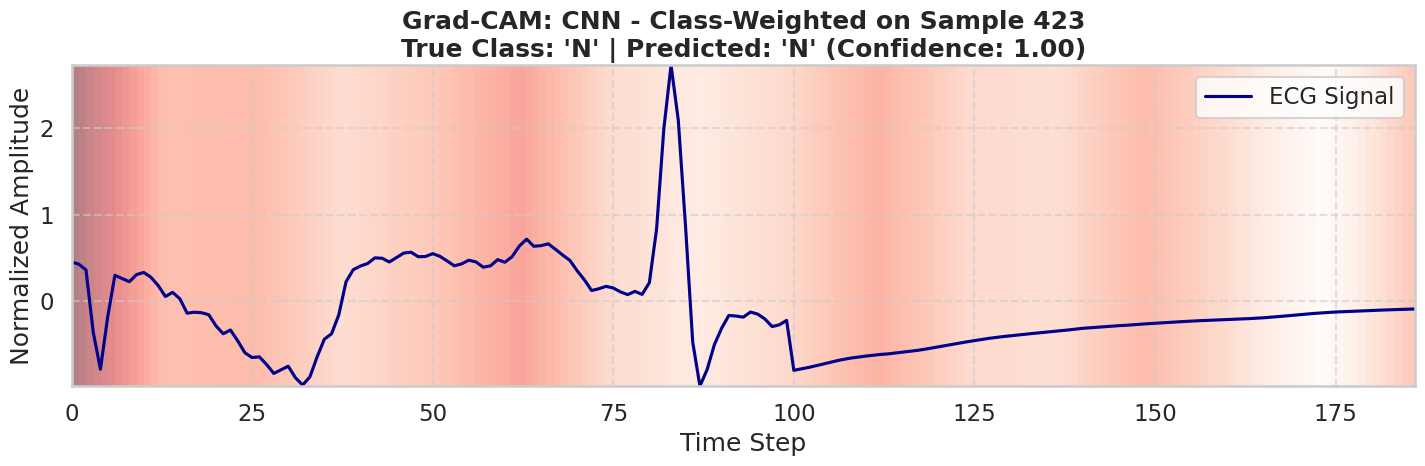

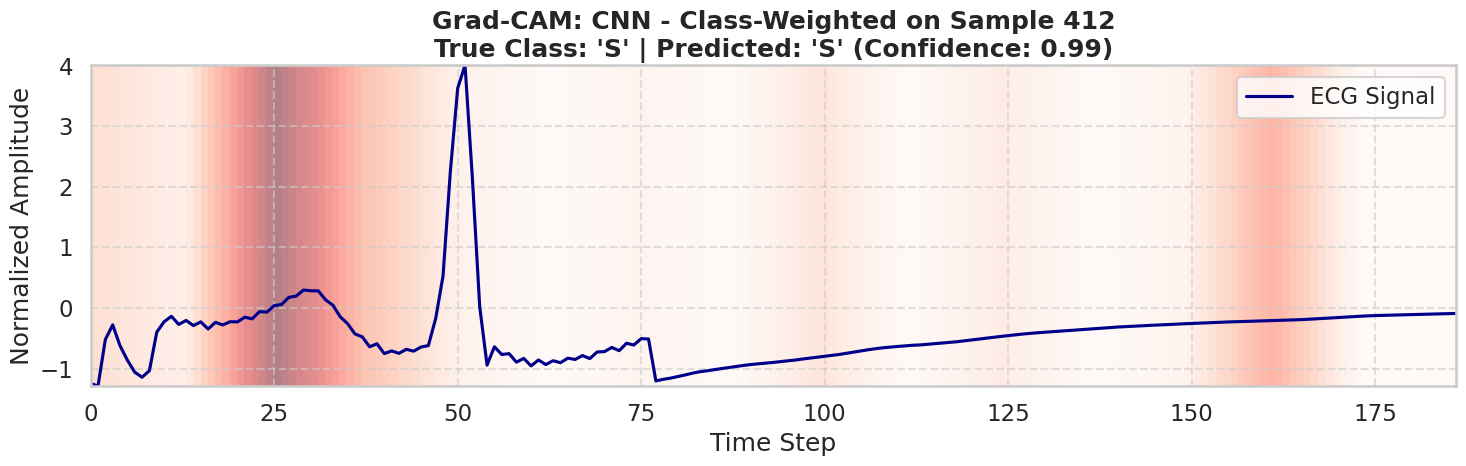

Using target layer for heatmap: 'conv1d_19'


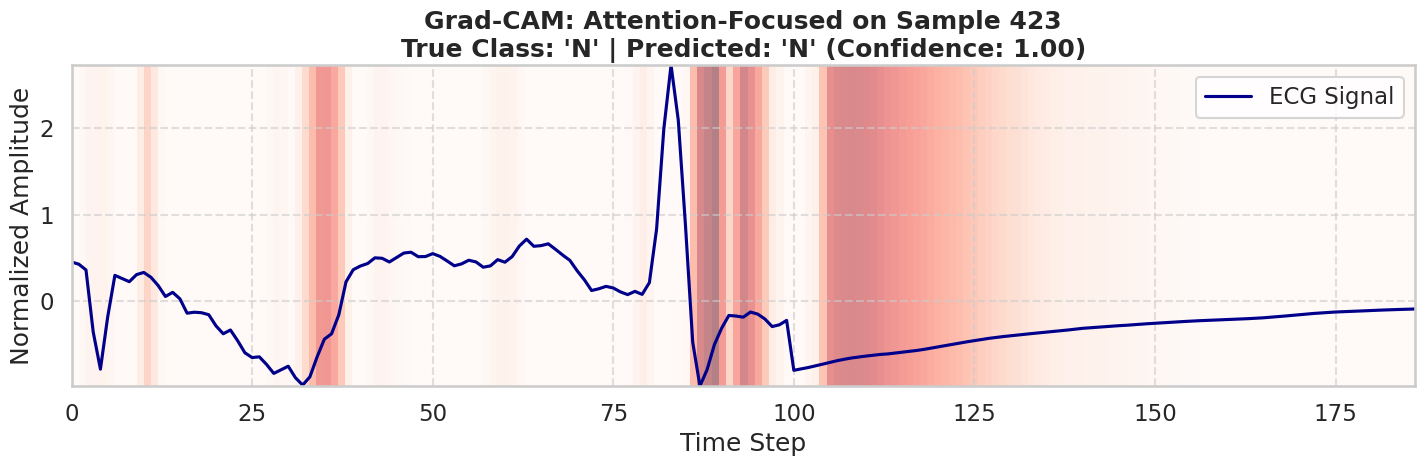

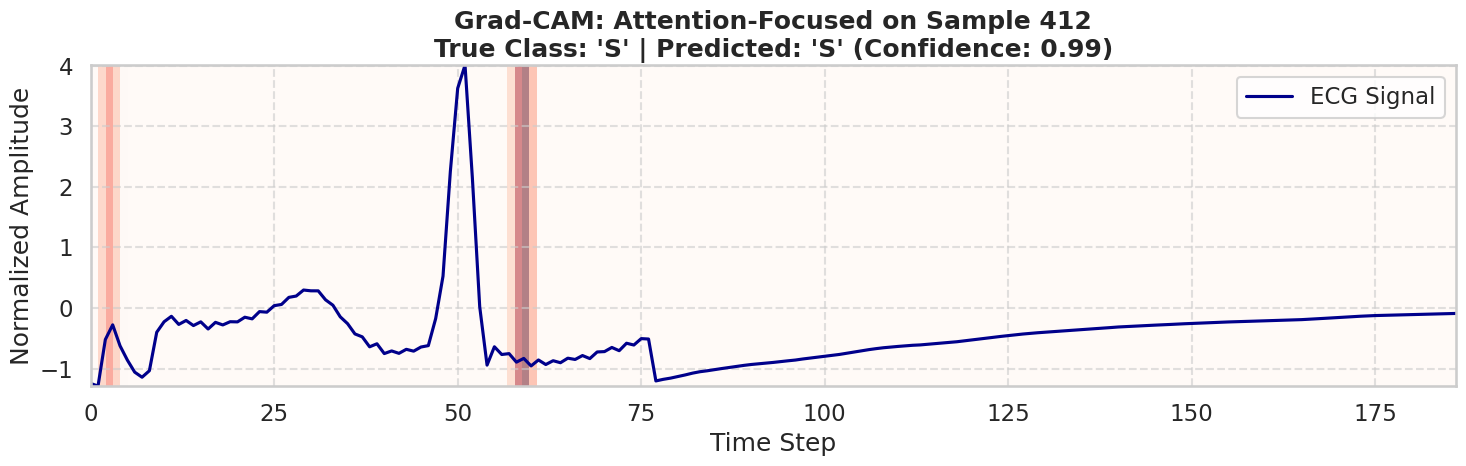

In [57]:
# ==============================================================================
# 9. Explainable AI (XAI) with Grad-CAM
# ==============================================================================
EXAMPLE_INDICES = [423, 412]
X_examples = X_test_r[EXAMPLE_INDICES]
y_true_labels = y_test[EXAMPLE_INDICES] 

def run_gradcam_and_plot(model, model_name, X_data_to_explain, true_labels, class_names_list):
    model_modifier = ReplaceToLinear()

    gradcam = Gradcam(model, model_modifier=model_modifier, clone=True)

    target_layer_name = None
    for layer in reversed(model.layers):
        if 'conv1d' in layer.name or 'gru' in layer.name or 'lstm' in layer.name:
            target_layer_name = layer.name
            break

    if not target_layer_name:
        raise ValueError(f"Could not find a suitable Conv1D or GRU layer in {model_name}")

    print(f"Using target layer for heatmap: '{target_layer_name}'")

    predictions = model.predict(X_data_to_explain, verbose=0)
    predicted_class_indices = np.argmax(predictions, axis=1)

    for i, single_example in enumerate(X_data_to_explain):
        true_class_index = int(np.round(true_labels[i])) 
        true_class_name = class_names_list[true_class_index]
        predicted_class_index = predicted_class_indices[i]
        predicted_class_name = class_names_list[predicted_class_index]
        confidence = predictions[i][predicted_class_index]

        score = CategoricalScore([predicted_class_index])

        heatmap = gradcam(score,
                          single_example[np.newaxis, ...],
                          penultimate_layer=target_layer_name)
        heatmap = np.squeeze(heatmap[0]) 


        fig, ax = plt.subplots(figsize=(15, 5))
        signal = np.squeeze(single_example)
        time_steps = np.arange(len(signal))


        ax.plot(time_steps, signal, color='darkblue', label='ECG Signal')

        ax.imshow(heatmap[np.newaxis, :],
                  cmap='Reds',
                  aspect='auto',
                  extent=[time_steps[0], time_steps[-1], np.min(signal), np.max(signal)],
                  alpha=0.5)

        ax.set_title(
            f"Grad-CAM: {model_name} on Sample {EXAMPLE_INDICES[i]}\n"
            f"True Class: '{true_class_name}' | Predicted: '{predicted_class_name}' (Confidence: {confidence:.2f})",
            fontweight='bold'
        )
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Normalized Amplitude")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


run_gradcam_and_plot(model=model_weight,
                     model_name='CNN - Class-Weighted',
                     X_data_to_explain=X_examples,
                     true_labels=y_true_labels,
                     class_names_list=CLASS_NAMES)

run_gradcam_and_plot(model=model_att,
                     model_name='Attention-Focused',
                     X_data_to_explain=X_examples,
                     true_labels=y_true_labels,
                     class_names_list=CLASS_NAMES)

### Explainable AI and Final Project Conclusion

This section integrates the findings from the Exploratory Data Analysis (EDA) and the quantitative model comparison with the visual evidence provided by Grad-CAM, confirming the underlying mechanisms of our best deep learning models.

---

### Connecting EDA Insights to Model Focus (Grad-CAM)

Our Exploratory Data Analysis (EDA) identified critical regions of the ECG signal for classification: the **QRS complex (25-75ms)** for maximum separation and the **T-wave region (post-75ms)** for distinguishing key pathological beats like 'F' and 'V'. The Grad-CAM visualizations strongly confirm that our deep learning models learned to focus on these exact regions.

| Model | Focus Region | EDA Confirmation |
| :---: | :---: | :---: |
| **CNN - Class-Weighted** | Broadly across **P-wave and QRS complex** (Time Steps 0-100). | The model correctly emphasizes the entire early beat morphology, leading to high Recall across classes. |
| **Attention-Focused** | Sharp, localized peaks around **QRS** and **P-wave** segments (e.g., Time Steps 5-15, 30-40, 75-85). | The model learned to identify the **most informative, non-linear shape changes** confirmed by our statistical feature analysis (Skewness, Kurtosis). |

#### Visual Evidence from Grad-CAM

The images illustrate how different architectures interpret the same 'N' (Normal) and 'S' (Supraventricular) samples:

1.  **CNN - Class-Weighted (Broad Focus):**
    * This model uses its last convolutional layer (`conv1d_11`) to generate a **broad, continuous heatmap** spanning much of the beat cycle (0-100 Time Steps).
    * This aligns with its goal: to capture all potential features to **maximize Recall** (as seen in its high performance on 'S' and 'F' classes), which is achieved by casting a wide net over the signal.

2.  **Attention-Focused (Localized Focus):**
    * This model uses the last convolutional layer (`conv1d_19`) and produces **sharp, localized peaks** of activation.
    * For the 'S' beat, the focus is intensely on the **initial P-wave** (Time Steps 0-15), which is crucial for distinguishing 'S' from 'N' or 'V'.
    * This confirms that the attention mechanism successfully learned to ignore redundant parts of the signal and concentrate its processing power on the few **salient morphological features** that drive the final prediction.


### Conclusion — ECG Heartbeat Classification: From Questions to Clinical Strategy

## Executive summary

This project moved from careful exploratory analysis to a set of validated models and concrete, deployable recommendations. The data are hard (strong class imbalance and heavy class overlap), and different modelling choices produce meaningful trade-offs: a single “best” model depends on **the user goal** — highest overall balanced accuracy vs. minimizing missed dangerous beats. The short takeaway:

* For **best balanced performance** the **Hybrid CNN-RNN** and **CNN - Class-Weighted** models are tied for the top spot.
* For **clinical safety** (minimizing false negatives on rare, dangerous classes S and F) the **class-weighted CNN** is the safest choice, while also achieving top-tier balanced performance.
* Among classical ML baselines, **Random Forest + SMOTE** is a strong, simple alternative and improved Macro-F1 substantially versus no resampling.

---

### Answering Our Initial Questions 

Our exploratory analysis and modeling experiments provided clear answers to the questions we set out to investigate.

**1. What’s hidden in the data?**
We found that classes are **statistically distinct but heavily overlap**.
* **Differences:** 'N' beats are stable (slow autocorrelation decay), while 'F' beats are chaotic (rapid decay, high-frequency FFT). 'V' beats are broad and smooth (low kurtosis), while 'N' and 'S' are sharp (high kurtosis).
* **"Tricksters":** While distinct on average, t-SNE and clustering (Silhouette Score: **0.191**) confirmed **massive overlap** between classes, explaining why classification is so challenging.
* **Informative Regions:** The **QRS complex (25-75ms)** showed maximum separation. Critically, the **T-wave region** was vital for identifying 'F' (which drops to zero) and 'V' (which stays elevated).

**2. What features matter most?**
**Both engineered and learned features** are critical.
* Our feature analysis confirmed that **statistical features** (skew, kurtosis, median), **frequency bands** (FFT), and **derivatives** all provide unique, separable information, as validated by our top-10 feature selection.
* However, the superior performance of **deep learning models** (CNNs) proves that automatically learned patterns from the raw signal capture subtle morphological details that hand-crafted features can miss.

**3. How to handle imbalance and noise?**
A specific strategy is **essential**.
* **Imbalance:** We proved that minority classes ('S', 'F') are ignored without intervention. While SMOTE boosted classical models, **class weighting** was the most effective strategy for our final deep learning models.
* **Noise/Outliers:** Our Z-score analysis found that most "outliers" were in the 'N' class and likely represented **rare physiological variations**, not errors. Removing them had minimal impact, so we retained them to build a more robust model.

**4. Can we visualize the heartbeat landscape?**
Yes, and it confirmed the data's complexity.
* t-SNE visualization showed a **single, dense, overlapping cloud** for most classes, with only 'V' beats showing some separation.
* This proves the feature space is **highly complex and non-linear**, justifying our decision to move beyond simple models and validating the low clustering scores.

**5. How stable are the signals and what variability matters?**
Pathological variability is quantifiable.
* **Normal ('N')** variability is low (stable autocorrelation).
* **Pathological ('V', 'F')** variability is high (chaotic, rapid autocorrelation decay). This "instability" is a key feature. Our models' strong performance on the test set implies these patterns **generalize well**.

**6. Which model families best capture these insights?**
**Deep learning models** best captured the complex, morphological patterns our EDA uncovered.
* While Random Forest provided a strong baseline, the **Hybrid CNN-RNN** and **Attention-Focused** models achieved superior performance.
* This confirms that the subtle, local shape changes in the waveform—the very things we saw in our EDA—are best captured by architectures designed for sequential, spatial data.

**7. Which model should we trust and recommend?**
This, our final question, depends entirely on the goal. Our analysis revealed a clear trade-off between balanced performance and clinical safety.

---

### Final Model Comparison

| Model | Macro F1 | S Recall | F Recall | Conclusion |
| :---: | :---: | :---: | :---: | :--- |
| **Hybrid CNN-RNN** | **0.92** | 0.82 | 0.83 | **Best Overall Balance (Tied):** Highest Macro-F1. |
| **CNN - Class-Weighted** | **0.92** | **0.91** | **0.90** | **Best Overall Balance (Tied)** & **Best for Clinical Safety.** |
| **Attention-Focused** | 0.91 | 0.87 | 0.84 | **Strong Balanced Performer:** Excellent use of features. |
| **HF + XGBoost** | 0.86 | 0.67 | 0.72 | Weakest performer; demonstrates deep learning's advantage. |

**Conclusion:**

* **Best for General-Purpose Classification:** The **Hybrid CNN-RNN model** and **CNN - Class-Weighted model** are tied, providing the most well-rounded performance with the highest Macro-F1 score (0.92).
* **Best for Clinical Safety:** The **CNN - Class-Weighted model** is the recommended choice when the primary goal is to maximize the detection of rare and critical arrhythmias, as its focus on Recall minimizes missed diagnoses.
* **Validation of Architecture:** The Grad-CAM results confirm that the deep learning models are fundamentally sound, basing their predictions on the **physiologically relevant waveform segments** identified during our initial EDA.
